**Цель:** Выявить признаки, связанные с целевой переменной, построить на их основе простую модель, а затем выявить ошибки и выбросы в данных. Выявить данные которые помогут решить эти ошибки.

In [3]:
import cufflinks as cf
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot  as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier   
from scipy.stats import shapiro, normaltest, jarque_bera, anderson
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency, pearsonr, spearmanr, f_oneway
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:

def _calculate_imbalance_degree(proportions):
    """Calculates a normalized imbalance score based on entropy."""
    n_categories = len(proportions)
    if n_categories <= 1:
        return 0.0

    entropy = -np.sum(proportions * np.log2(proportions.replace(0, 1e-12))) # Avoid log(0)
    max_entropy = np.log2(n_categories)
    
    if max_entropy == 0:
        return 1.0

    normalized_entropy = entropy / max_entropy
    imbalance_degree = 1 - normalized_entropy
    return imbalance_degree

def detect_categorical_imbalance(df, column_name, plot=True, 
                                 imbalance_threshold=0.1, cardinality_threshold_plot=25, top_n=15):
    """
    Analyzes the distribution of a categorical or discrete numerical feature, 
    detects imbalance, and handles high-cardinality features intelligently.
    Returns a final verdict on the degree of imbalance.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyze.
        plot (bool): If True, generates appropriate plots for the feature.
        imbalance_threshold (float): A proportion threshold (e.g., 0.1 for 10%) 
                                     to flag under-represented categories.
        cardinality_threshold_plot (int): The number of unique values above which 
                                          the feature is considered high-cardinality 
                                          for plotting purposes.
        top_n (int): The number of top/bottom categories to display for 
                     high-cardinality features.

    Returns:
        dict: A dictionary containing a full report on the feature's distribution 
              and a final verdict on imbalance.
    """
    
    # --- 1. Initial Validation and Basic Stats ---
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    col_data = df[column_name]
    n_unique = col_data.nunique()
    n_missing = col_data.isnull().sum()
    dtype = col_data.dtype

    print("="*60)
    print(f"Analyzing Feature: '{column_name}'")
    print("="*60)
    
    report = {
        'column_name': column_name,
        'dtype': str(dtype),
        'n_unique': n_unique,
        'n_missing': n_missing,
        'imbalance_info': {}
    }

    if n_unique <= 1:
        print(f"Data Type: {dtype}")
        print(f"Number of Unique Values: {n_unique}")
        print(f"Number of Missing Values: {n_missing} ({n_missing / len(df):.2%})")
        print("\n[!] Verdict: Balanced (Only one or zero categories present).")
        print("="*60)
        report['imbalance_info'] = {'degree': 0.0, 'verdict': 'Balanced'}
        return report

    # --- 2. Calculate Value Counts, Proportions, and Imbalance Degree ---
    value_counts = col_data.value_counts(dropna=True)
    proportions = col_data.value_counts(normalize=True, dropna=True)
    
    imbalance_degree = _calculate_imbalance_degree(proportions)
    if imbalance_degree < 0.2:
        imbalance_verdict = "Balanced"
    elif imbalance_degree < 0.4:
        imbalance_verdict = "Slightly Imbalanced"
    elif imbalance_degree < 0.6:
        imbalance_verdict = "Moderately Imbalanced"
    elif imbalance_degree < 0.8:
        imbalance_verdict = "Highly Imbalanced"
    else:
        imbalance_verdict = "Severely Imbalanced"
    
    report['imbalance_info'] = {'degree': imbalance_degree, 'verdict': imbalance_verdict}

    print(f"Data Type: {dtype}")
    print(f"Number of Unique Values: {n_unique}")
    print(f"Number of Missing Values: {n_missing} ({n_missing / len(df):.2%})")
    print("-" * 60)
    print(f"[!] IMBALANCE VERDICT: {imbalance_verdict.upper()} (Degree: {imbalance_degree:.3f})")
    print("-" * 60)
    
    if pd.api.types.is_numeric_dtype(dtype) and n_unique > 100 and n_unique / len(df.dropna(subset=[column_name])) > 0.5:
        print(f"Warning: Column '{column_name}' is numeric with very high cardinality.")
        print("It might be a continuous feature. A histogram is likely a better visualization.")
        report['type'] = 'likely_continuous_numeric'
        if plot:
            plt.figure(figsize=(10, 6))
            sns.histplot(df[column_name].dropna(), kde=True)
            plt.title(f'Histogram of Continuous Feature: {column_name}')
            plt.xlabel(column_name)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()
        return report

    if n_unique <= cardinality_threshold_plot:
        print("Feature treated as LOW-CARDINALITY.\n")
        report['type'] = 'low_cardinality'

        summary_df = pd.DataFrame({'Count': value_counts, 'Proportion': proportions})
        print(summary_df.to_string(formatters={'Proportion': '{:.2%}'.format}))
        
        under_represented = proportions[proportions < imbalance_threshold]
        if not under_represented.empty:
            report['imbalance_info']['under_represented_categories'] = under_represented.index.tolist()
            print(f"\n[!] Categories with proportion < {imbalance_threshold:.0%}:")
            for cat, prop in under_represented.items():
                print(f"  - {cat}: {prop:.2%}")
        
        if plot:
            plt.figure(figsize=(max(10, n_unique * 0.5), 6))
            sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
            plt.title(f'Distribution of {column_name} (Verdict: {imbalance_verdict})')
            plt.xlabel(column_name)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            if n_unique <= 10:
                plt.figure(figsize=(8, 8))
                
                # --- THIS IS THE FIX ---
                # Generate a list of colors instead of using cmap
                colors = sns.color_palette('Pastel1', n_colors=len(proportions))
                
                plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90, 
                        pctdistance=0.85, colors=colors) # Use 'colors' argument
                # --- END OF FIX ---
                
                plt.title(f'Proportion of {column_name} Categories')
                centre_circle = plt.Circle((0,0),0.70,fc='white')
                fig = plt.gcf()
                fig.gca().add_artist(centre_circle)
                plt.axis('equal')
                plt.tight_layout()
                plt.show()

    # --- High Cardinality Logic ---
    else:
        print(f"Feature treated as HIGH-CARDINALITY (Unique values > {cardinality_threshold_plot}).\n")
        report['type'] = 'high_cardinality'

        print(f"--- Top {top_n} Most Frequent Values ---")
        print(value_counts.head(top_n))
        print(f"\n--- Bottom {top_n} Least Frequent Values ---")
        print(value_counts.tail(top_n))

        top_n_coverage = proportions.head(top_n).sum()
        report['top_n_coverage'] = {'n': top_n, 'coverage_ratio': top_n_coverage}
        print(f"\n--- Concentration Analysis ---")
        print(f"[*] The top {top_n} categories account for {top_n_coverage:.2%} of the data.")
        
        if plot:
            plt.figure(figsize=(12, 7))
            top_n_counts = value_counts.head(top_n)
            sns.barplot(x=top_n_counts.index, y=top_n_counts.values, palette='mako', order=top_n_counts.index)
            plt.title(f'Top {top_n} Categories in {column_name} (Verdict: {imbalance_verdict})')
            plt.xlabel(column_name)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

    print("="*60)
    return report

def binary_analyze_categorical(df, f: str, y: str, alpha=0.05, treat_as_numeric=False):
    """
    Расширенный анализ связи между категориальным/дискретным признаком (f) и бинарной целевой переменной (y).
    Включает диагностику причин слабой связи, проверку нелинейности и обработку дискретных числовых признаков.
    
    Args:
        df (pd.DataFrame): Исходный DataFrame.
        f (str): Название категориального/дискретного признака (столбца).
        y (str): Название бинарной целевой переменной (столбца).
        alpha (float): Уровень значимости для статистических тестов.
        treat_as_numeric (bool): True если признак дискретный числовой, False если категориальный.
    """
    print(f"--- Расширенный анализ связи между '{f}' и '{y}' ---")
    original_size = len(df)
    df_clean = df[[f, y]].dropna()
    clean_size = len(df_clean)
    missing_rate = (original_size - clean_size) / original_size
    
    if df_clean.empty:
        print(f"❌ После удаления пропусков нет данных для анализа")
        return
    
    print(f"📊 Базовая информация:")
    print(f"   • Исходный размер выборки: {original_size}")
    print(f"   • После удаления пропусков: {clean_size}")
    print(f"   • Доля пропусков: {missing_rate:.2%}")
    
    # Проверка бинарности целевой переменной
    unique_targets = df_clean[y].unique()
    if len(unique_targets) != 2:
        print(f"❌ Целевая переменная должна быть бинарной. Найдено {len(unique_targets)} значений.")
        return
    
    # Автоматическое определение типа признака
    is_numeric = pd.api.types.is_numeric_dtype(df_clean[f]) or treat_as_numeric
    
    if is_numeric:
        print(f"   • Тип признака: Дискретный числовой")
        # Попытка конвертации в числовой тип
        try:
            df_clean[f] = pd.to_numeric(df_clean[f], errors='coerce')
            df_clean = df_clean.dropna()
        except:
            is_numeric = False
            print(f"   ⚠️  Не удалось конвертировать в числовой тип, обрабатываем как категориальный")
    else:
        print(f"   • Тип признака: Категориальный")
    
    feature_counts = df_clean[f].value_counts()
    n_categories = len(feature_counts)
    print(f"   • Количество уникальных значений в '{f}': {n_categories}")
    print(f"   • Размер групп целевой переменной: {dict(df_clean[y].value_counts())}")
    
    # Таблица сопряженности
    contingency_table = pd.crosstab(df_clean[f], df_clean[y])
    print(f"\n📋 Таблица сопряженности:")
    print(contingency_table)
    
    print(f"\n📊 Относительные частоты (по строкам):")
    proportions = pd.crosstab(df_clean[f], df_clean[y], normalize='index')
    print(proportions.round(3))
    
    # Статистические тесты
    print(f"\n🔬 Статистические тесты:")
    
    # Хи-квадрат тест
    try:
        chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"   • Хи-квадрат: χ² = {chi2:.4f}, df = {dof}")
        print(f"   • P-значение (χ²): {p_chi2:.10f}")
        print(f"   • Статистически значимая связь (χ²): {'Да' if p_chi2 < alpha else 'Нет'}")
    except Exception as e:
        print(f"   ❌ Ошибка в хи-квадрат тесте: {e}")
        chi2, p_chi2, dof, expected = 0, 1, 0, None
    
    # Коэффициент Крамера V
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1))) if chi2 > 0 else 0
    print(f"   • Коэффициент Крамера V: {cramers_v:.4f}")
    
    # Взаимная информация
    le_f = LabelEncoder()
    le_y = LabelEncoder()
    f_encoded = le_f.fit_transform(df_clean[f].astype(str))
    y_encoded = le_y.fit_transform(df_clean[y].astype(str))
    mi_score = mutual_info_classif(f_encoded.reshape(-1, 1), y_encoded, random_state=42)[0]
    print(f"   • Взаимная информация: {mi_score:.4f}")
    
    # Дополнительные тесты для числовых признаков
    if is_numeric:
        print(f"\n🔢 Дополнительные тесты для числового признака:")
        
        # Проверка нормальности в группах
        groups = [df_clean[df_clean[y] == val][f].values for val in unique_targets]
        for i, (val, group) in enumerate(zip(unique_targets, groups)):
            if len(group) >= 3:  # Минимум для теста Шапиро
                _, p_shapiro = stats.shapiro(group[:5000])  # Ограничиваем выборку для теста
                print(f"   • Нормальность в группе {val}: p = {p_shapiro:.6f} {'(норм.)' if p_shapiro > alpha else '(не норм.)'}")
        
        # Mann-Whitney U test (непараметрический)
        try:
            statistic_mw, p_mw = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
            print(f"   • Тест Манна-Уитни: U = {statistic_mw:.2f}, p = {p_mw:.10f}")
            print(f"   • Значимость (M-W): {'Да' if p_mw < alpha else 'Нет'}")
        except Exception as e:
            print(f"   ❌ Ошибка в тесте Манна-Уитни: {e}")
            p_mw = 1
        
        # Тест Крускала-Уоллиса (для множественных групп)
        if n_categories > 2:
            try:
                group_values = [df_clean[df_clean[f] == cat][y].values for cat in df_clean[f].unique()]
                group_values = [g for g in group_values if len(g) > 0]
                if len(group_values) >= 2:
                    statistic_kw, p_kw = stats.kruskal(*group_values)
                    print(f"   • Тест Крускала-Уоллиса: H = {statistic_kw:.4f}, p = {p_kw:.10f}")
                    print(f"   • Значимость (K-W): {'Да' if p_kw < alpha else 'Нет'}")
            except Exception as e:
                print(f"   ❌ Ошибка в тесте Крускала-Уоллиса: {e}")
        
        # Корреляция Спирмена (для оценки монотонности)
        try:
            spearman_corr, p_spearman = stats.spearmanr(df_clean[f], y_encoded)
            print(f"   • Корреляция Спирмена: ρ = {spearman_corr:.4f}, p = {p_spearman:.10f}")
            print(f"   • Монотонная связь: {'Да' if abs(spearman_corr) > 0.1 and p_spearman < alpha else 'Нет'}")
        except Exception as e:
            print(f"   ❌ Ошибка в корреляции Спирмена: {e}")
            spearman_corr = 0
    
    # Проверка нелинейности с помощью дерева решений
    print(f"\n🌳 Анализ нелинейности:")
    try:
        # Простая линейная модель (логистическая регрессия через пропорции)
        if is_numeric:
            # Для числовых признаков используем корреляцию как меру линейной связи
            linear_strength = abs(spearman_corr) if 'spearman_corr' in locals() else 0
        else:
            # Для категориальных - используем Крамера V
            linear_strength = cramers_v
        
        # Нелинейная модель (дерево решений)
        dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)
        dt.fit(f_encoded.reshape(-1, 1), y_encoded)
        
        # Качество модели дерева
        tree_scores = cross_val_score(dt, f_encoded.reshape(-1, 1), y_encoded, cv=3, scoring='roc_auc')
        tree_auc = tree_scores.mean()
        
        print(f"   • Линейная связь (мера): {linear_strength:.4f}")
        print(f"   • Нелинейная связь (AUC дерева): {tree_auc:.4f}")
        
        # Оценка нелинейности
        if tree_auc > 0.6 and tree_auc - linear_strength > 0.1:
            print(f"   • Обнаружена нелинейная связь: разница {tree_auc - linear_strength:.4f}")
        else:
            print(f"   • Нелинейная связь слабая или отсутствует")
            
    except Exception as e:
        print(f"   ❌ Ошибка в анализе нелинейности: {e}")
        tree_auc = 0.5
    
    # Визуализация
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Анализ признака {f} ({"числовой" if is_numeric else "категориальный"}) и целевой переменной {y}', fontsize=16)
    
    # График 1: Распределение по категориям/значениям
    if is_numeric and n_categories > 10:
        # Для числовых с большим количеством значений - гистограмма
        for target_val in unique_targets:
            subset = df_clean[df_clean[y] == target_val][f]
            axes[0,0].hist(subset, alpha=0.7, label=f'{y}={target_val}', bins=min(20, n_categories//2))
        axes[0,0].set_xlabel(f)
        axes[0,0].set_ylabel('Частота')
        axes[0,0].legend()
    else:
        # Для категориальных или малого количества значений
        sns.countplot(data=df_clean, x=f, hue=y, ax=axes[0,0])
        axes[0,0].tick_params(axis='x', rotation=45)
    
    axes[0,0].set_title('Распределение по значениям')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # График 2: Доли целевой переменной
    proportions.plot(kind='bar', ax=axes[0,1], width=0.8)
    axes[0,1].set_title('Доли целевой переменной по значениям')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(title=y)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # График 3: Таблица сопряженности
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
    axes[0,2].set_title('Таблица сопряженности')
    
    # График 4: Стандартизированные остатки
    if expected is not None:
        residuals = (contingency_table - expected) / np.sqrt(expected)
        sns.heatmap(residuals, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1,0])
        axes[1,0].set_title('Стандартизированные остатки')
    else:
        axes[1,0].text(0.5, 0.5, 'Остатки не рассчитаны', ha='center', va='center', transform=axes[1,0].transAxes)
    
    # График 5: Boxplot для числовых признаков
    if is_numeric:
        sns.boxplot(data=df_clean, x=y, y=f, ax=axes[1,1])
        axes[1,1].set_title('Распределение числового признака по группам')
    else:
        # Для категориальных - график важности категорий
        importance_data = []
        overall_rate = df_clean[y].value_counts(normalize=True)[unique_targets[1]]
        for cat in proportions.index:
            cat_rate = proportions.loc[cat, unique_targets[1]]
            importance = abs(cat_rate - overall_rate)
            importance_data.append({'category': cat, 'importance': importance})
        
        importance_df = pd.DataFrame(importance_data)
        axes[1,1].bar(importance_df['category'], importance_df['importance'])
        axes[1,1].set_title('Важность категорий (отклонение от общего уровня)')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    # График 6: Метрики качества
    metrics_data = {
        'Метрика': ['Cramer V', 'Mutual Info', 'Tree AUC'],
        'Значение': [cramers_v, mi_score, tree_auc]
    }
    axes[1,2].bar(metrics_data['Метрика'], metrics_data['Значение'])
    axes[1,2].set_title('Сравнение метрик связи')
    axes[1,2].set_ylim(0, 1)
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Диагностика проблем
    print(f"\n🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:")
    is_significant = p_chi2 < alpha
    issues_found = []
    recommendations = []
    rare_categories = []
    
    # Проверка пропусков
    if missing_rate > 0.1:
        issues_found.append(f"ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ ({missing_rate:.1%})")
        recommendations.append("• Проанализировать механизм пропусков и рассмотреть методы заполнения")
        
        # Анализ пропусков
        df_missing = df.copy()
        df_missing['is_missing'] = df_missing[f].isna()
        if not df_missing['is_missing'].isna().any() and len(df_missing[y].dropna().unique()) == 2:
            try:
                missing_contingency = pd.crosstab(df_missing['is_missing'], df_missing[y])
                chi2_missing, p_missing, _, _ = stats.chi2_contingency(missing_contingency)
                if p_missing < alpha:
                    issues_found.append("ПРОПУСКИ НЕ СЛУЧАЙНЫ (связаны с целевой переменной)")
                    recommendations.append("• Рассмотреть отдельную категорию для пропусков")
            except:
                pass
    
    # Проверка условий хи-квадрат теста
    if expected is not None:
        low_expected = (expected < 5).sum()
        total_cells = expected.size
        low_expected_rate = low_expected / total_cells
        print(f"   • Ячеек с ожидаемой частотой < 5: {low_expected}/{total_cells} ({low_expected_rate:.1%})")
        
        if low_expected_rate > 0.2:
            issues_found.append(f"НАРУШЕНЫ УСЛОВИЯ ХИ-КВАДРАТ ТЕСТА ({low_expected_rate:.1%} ячеек с частотой < 5)")
            recommendations.append("• Объединить редкие категории или использовать точный тест Фишера")
            rare_categories = feature_counts[feature_counts < 10].index.tolist()
            if rare_categories:
                issues_found.append(f"РЕДКИЕ КАТЕГОРИИ: {rare_categories}")
                recommendations.append(f"• Рассмотреть объединение категорий: {rare_categories}")
    
    # Проверка редких категорий
    if not rare_categories:
        rare_categories = feature_counts[feature_counts < 10].index.tolist()
    
    # Дисбаланс категорий
    min_category_size = feature_counts.min()
    max_category_size = feature_counts.max()
    category_imbalance = max_category_size / min_category_size if min_category_size > 0 else float('inf')
    
    if category_imbalance > 10:
        issues_found.append(f"СИЛЬНЫЙ ДИСБАЛАНС КАТЕГОРИЙ (разница в {category_imbalance:.1f}x)")
        recommendations.append("• Рассмотреть ресэмплинг или взвешивание классов")
    
    # Дисбаланс целевой переменной
    target_counts = df_clean[y].value_counts()
    target_imbalance = target_counts.max() / target_counts.min()
    min_target_rate = target_counts.min() / target_counts.sum()
    
    if min_target_rate < 0.1:
        issues_found.append(f"ДИСБАЛАНС ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ({min_target_rate:.1%} в меньшем классе)")
        recommendations.append("• Применить методы балансировки классов")
    
    # Неинформативные категории
    similar_categories = []
    overall_rate = df_clean[y].value_counts(normalize=True)[unique_targets[1]]
    for category in proportions.index:
        category_rate = proportions.loc[category, unique_targets[1]]
        if abs(category_rate - overall_rate) < 0.05:
            similar_categories.append(category)
    
    if len(similar_categories) > 1:
        issues_found.append(f"НЕИНФОРМАТИВНЫЕ КАТЕГОРИИ: {similar_categories}")
        recommendations.append("• Рассмотреть объединение категорий со схожим распределением")
    
    # Размер эффекта
    effect_size = max(cramers_v, mi_score, tree_auc - 0.5)
    if effect_size < 0.1:
        issues_found.append(f"СЛАБЫЙ РАЗМЕР ЭФФЕКТА (максимальная метрика = {effect_size:.4f})")
        recommendations.append("• Возможно, связь действительно слабая или отсутствует")
    
    # Точный тест Фишера для малых выборок
    if clean_size < 100 or (expected is not None and (expected < 5).any()):
        recommendations.append("• Рассмотреть точный тест Фишера для малых выборок")
        if contingency_table.shape == (2, 2):
            try:
                _, p_fisher = stats.fisher_exact(contingency_table)
                print(f"   • Точный тест Фишера: p = {p_fisher:.10f}")
                if p_fisher < alpha and p_chi2 >= alpha:
                    print("   ⚠️  Точный тест Фишера показывает значимость!")
            except:
                pass
    
    # Рекомендации по предобработке
    print(f"\n🛠️  РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ:")
    if len(rare_categories) > 0:
        print(f"   • Объединить редкие категории в группу 'Другие': {rare_categories}")
    
    if is_numeric:
        print("   • Для числового признака рассмотреть:")
        print("     - Биннинг (разбиение на интервалы)")
        print("     - Полиномиальные признаки для нелинейности")
        print("     - Логарифмическое или другое преобразование")
        if tree_auc > 0.6:
            print("     - Использование дерева решений для извлечения правил")
    else:
        if n_categories > 2:
            print("   • Рассмотреть различные методы кодирования:")
            print("     - One-Hot Encoding для независимых категорий")
            print("     - Target Encoding для категорий с разным влиянием")
            print("     - Binary Encoding для категорий с естественным порядком")
    
    # Итоговый анализ
    print(f"\n📋 ИТОГОВЫЙ АНАЛИЗ:")
    significant_tests = []
    if p_chi2 < alpha:
        significant_tests.append("χ²-тест")
    if is_numeric and 'p_mw' in locals() and p_mw < alpha:
        significant_tests.append("Манн-Уитни")
    if tree_auc > 0.6:
        significant_tests.append("Нелинейная связь")
    
    if significant_tests:
        print(f"✅ СВЯЗЬ ОБНАРУЖЕНА: {', '.join(significant_tests)}")
        print(f"   • Наилучшая метрика: {max(cramers_v, mi_score, tree_auc):.4f}")
        if tree_auc > max(cramers_v, mi_score) + 0.1:
            print("   • Преобладает нелинейная связь")
        elif cramers_v > 0.3 or mi_score > 0.3:
            print("   • Сильная связь между признаками")
        elif cramers_v > 0.1 or mi_score > 0.1:
            print("   • Умеренная связь между признаками")
        else:
            print("   • Слабая, но статистически значимая связь")
    else:
        print(f"❌ ЗНАЧИМАЯ СВЯЗЬ НЕ ОБНАРУЖЕНА")
        if issues_found:
            print(f"\n🚨 ВОЗМОЖНЫЕ ПРИЧИНЫ:")
            for issue in issues_found:
                print(f"   • {issue}")
            
            print(f"\n💡 РЕКОМЕНДАЦИИ:")
            for rec in recommendations:
                print(f"   {rec}")
        else:
            print("   • Возможно, связи действительно нет")
            print("   • Или связь слишком слабая для обнаружения")
    
    # Рекомендации по использованию
    print(f"\n🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:")
    best_metric = max(cramers_v, mi_score, tree_auc - 0.5)
    
    if len(significant_tests) > 0 or best_metric > 0.05:
        print("   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях")
        if best_metric > 0.2:
            print("   • Признак показывает хорошую предсказательную способность")
        if tree_auc > max(cramers_v, mi_score) + 0.1:
            print("   • Рекомендуются нелинейные модели (деревья, нейросети)")
        if is_numeric and n_categories <= 10:
            print("   • Можно использовать как категориальный (One-Hot)")
        elif is_numeric:
            print("   • Рекомендуется биннинг или преобразование")
        elif n_categories <= 10:
            print("   • Можно использовать One-Hot Encoding")
        else:
            print("   • Рассмотреть Target Encoding или группировку категорий")
    else:
        print("   ⚠️  НЕ РЕКОМЕНДУЕТСЯ использовать в текущем виде")
        if len(recommendations) > 0:
            print("   • Сначала применить рекомендованные преобразования")
        else:
            print("   • Возможно, признак не информативен для данной задачи")
    
    print(f"\n--- Конец расширенного анализа ---")
    print("-" * 80)
    
    # Возвращаем словарь с результатами для программного использования
    return {
        'chi2_pvalue': p_chi2,
        'cramers_v': cramers_v,
        'mutual_info': mi_score,
        'tree_auc': tree_auc,
        'is_significant': len(significant_tests) > 0,
        'best_metric': best_metric,
        'is_numeric': is_numeric,
        'recommendations': recommendations,
        'issues_found': issues_found
    }

def analyze_high_cardinality_categorical(df, f: str, y: str, alpha=0.05, 
                                        max_categories_show=20, min_frequency=5,
                                        extract_patterns=True, group_rare=True):
    """
    Расширенный анализ связи между высококардинальным категориальным признаком и бинарной целевой переменной.
    Специально разработан для признаков типа Cabin, Ticket, Name и других с большим количеством уникальных значений.
    
    Args:
        df (pd.DataFrame): Исходный DataFrame.
        f (str): Название категориального признака с высокой кардинальностью.
        y (str): Название бинарной целевой переменной.
        alpha (float): Уровень значимости для статистических тестов.
        max_categories_show (int): Максимальное количество категорий для отображения.
        min_frequency (int): Минимальная частота для отображения категории отдельно.
        extract_patterns (bool): Извлекать ли паттерны из строковых значений.
        group_rare (bool): Группировать ли редкие категории.
    """
    print(f"--- Анализ высококардинального категориального признака '{f}' и '{y}' ---")
    
    original_size = len(df)
    df_clean = df[[f, y]].dropna()
    clean_size = len(df_clean)
    missing_rate = (original_size - clean_size) / original_size
    
    if df_clean.empty:
        print(f"❌ После удаления пропусков нет данных для анализа")
        return
    
    print(f"📊 Базовая информация:")
    print(f"   • Исходный размер выборки: {original_size}")
    print(f"   • После удаления пропусков: {clean_size}")
    print(f"   • Доля пропусков: {missing_rate:.2%}")
    
    # Проверка бинарности целевой переменной
    unique_targets = df_clean[y].unique()
    if len(unique_targets) != 2:
        print(f"❌ Целевая переменная должна быть бинарной. Найдено {len(unique_targets)} значений.")
        return
    
    # Анализ кардинальности
    feature_counts = df_clean[f].value_counts()
    n_categories = len(feature_counts)
    cardinality_ratio = n_categories / clean_size
    
    print(f"   • Количество уникальных значений: {n_categories}")
    print(f"   • Отношение кардинальности к размеру выборки: {cardinality_ratio:.4f}")
    print(f"   • Размер групп целевой переменной: {dict(df_clean[y].value_counts())}")
    
    # Классификация по типу высокой кардинальности
    if cardinality_ratio > 0.9:
        cardinality_type = "Почти уникальный (ID-подобный)"
    elif cardinality_ratio > 0.5:
        cardinality_type = "Очень высокая кардинальность"
    elif cardinality_ratio > 0.1:
        cardinality_type = "Высокая кардинальность"
    else:
        cardinality_type = "Умеренная кардинальность"
    
    print(f"   • Тип кардинальности: {cardinality_type}")
    
    # Анализ распределения частот
    print(f"\n📈 Анализ распределения частот:")
    frequency_stats = feature_counts.describe()
    print(f"   • Среднее количество наблюдений на категорию: {frequency_stats['mean']:.2f}")
    print(f"   • Медианное количество: {frequency_stats['50%']:.0f}")
    print(f"   • Максимальное количество: {frequency_stats['max']:.0f}")
    print(f"   • Минимальное количество: {frequency_stats['min']:.0f}")
    
    # Анализ редких категорий
    rare_categories = feature_counts[feature_counts < min_frequency]
    frequent_categories = feature_counts[feature_counts >= min_frequency]
    
    print(f"   • Категории с частотой < {min_frequency}: {len(rare_categories)} ({len(rare_categories)/n_categories:.1%})")
    print(f"   • Частые категории (≥ {min_frequency}): {len(frequent_categories)} ({len(frequent_categories)/n_categories:.1%})")
    
    # Извлечение паттернов из строковых значений
    patterns_extracted = {}
    if extract_patterns and df_clean[f].dtype == 'object':
        print(f"\n🔍 Извлечение паттернов из строковых значений:")
        
        # Анализ длины строк
        string_lengths = df_clean[f].astype(str).str.len()
        print(f"   • Средняя длина строки: {string_lengths.mean():.1f}")
        print(f"   • Диапазон длин: {string_lengths.min()}-{string_lengths.max()}")
        
        # Извлечение префиксов (первые символы)
        prefixes = df_clean[f].astype(str).str[:2]  # Первые 2 символа
        prefix_counts = prefixes.value_counts()
        if len(prefix_counts) < n_categories * 0.8:  # Если префиксы существенно сокращают кардинальность
            patterns_extracted['prefixes'] = prefix_counts
            print(f"   • Уникальных префиксов (2 символа): {len(prefix_counts)}")
            
        # Извлечение числовых частей
        numeric_parts = df_clean[f].astype(str).str.extract(r'(\d+)', expand=False)
        numeric_parts = numeric_parts.dropna()
        if len(numeric_parts) > 0:
            numeric_counts = pd.cut(pd.to_numeric(numeric_parts, errors='coerce').dropna(), 
                                   bins=min(10, len(numeric_parts.unique())), 
                                   duplicates='drop').value_counts()
            patterns_extracted['numeric_ranges'] = numeric_counts
            print(f"   • Найдено числовых значений: {len(numeric_parts)}")
            
        # Извлечение буквенных частей
        alpha_parts = df_clean[f].astype(str).str.extract(r'([A-Za-z]+)', expand=False)
        alpha_parts = alpha_parts.dropna()
        if len(alpha_parts) > 0:
            alpha_counts = alpha_parts.value_counts()
            patterns_extracted['alpha_parts'] = alpha_counts
            print(f"   • Уникальных буквенных частей: {len(alpha_counts)}")
    
    # Создание групп для анализа
    df_analysis = df_clean.copy()
    
    if group_rare and len(rare_categories) > 0:
        print(f"\n🔄 Группировка редких категорий:")
        df_analysis[f + '_grouped'] = df_analysis[f].copy()
        rare_mask = df_analysis[f].isin(rare_categories.index)
        df_analysis.loc[rare_mask, f + '_grouped'] = 'RARE_CATEGORIES'
        
        grouped_counts = df_analysis[f + '_grouped'].value_counts()
        print(f"   • После группировки уникальных значений: {len(grouped_counts)}")
        print(f"   • Размер группы 'RARE_CATEGORIES': {grouped_counts.get('RARE_CATEGORIES', 0)}")
        
        analysis_feature = f + '_grouped'
    else:
        analysis_feature = f
    
    # Статистические тесты на сгруппированных данных
    print(f"\n🔬 Статистические тесты:")
    
    # Ограничиваем анализ топ-категориями для избежания проблем с разреженностью
    top_categories = df_analysis[analysis_feature].value_counts().head(min(max_categories_show, 50))
    df_top = df_analysis[df_analysis[analysis_feature].isin(top_categories.index)]
    
    # Таблица сопряженности для топ-категорий
    contingency_table = pd.crosstab(df_top[analysis_feature], df_top[y])
    print(f"   • Анализ проводится на топ-{len(top_categories)} категориях")
    
    # Хи-квадрат тест
    try:
        chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"   • Хи-квадрат: χ² = {chi2:.4f}, df = {dof}")
        print(f"   • P-значение (χ²): {p_chi2:.10f}")
        print(f"   • Статистически значимая связь: {'Да' if p_chi2 < alpha else 'Нет'}")
        
        # Проверка условий теста
        low_expected = (expected < 5).sum()
        total_cells = expected.size
        low_expected_rate = low_expected / total_cells
        print(f"   • Ячеек с ожидаемой частотой < 5: {low_expected}/{total_cells} ({low_expected_rate:.1%})")
        
    except Exception as e:
        print(f"   ❌ Ошибка в хи-квадрат тесте: {e}")
        chi2, p_chi2, dof, expected = 0, 1, 0, None
    
    # Коэффициент Крамера V
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1))) if chi2 > 0 else 0
    print(f"   • Коэффициент Крамера V: {cramers_v:.4f}")
    
    # Взаимная информация
    le_f = LabelEncoder()
    le_y = LabelEncoder()
    f_encoded = le_f.fit_transform(df_top[analysis_feature].astype(str))
    y_encoded = le_y.fit_transform(df_top[y].astype(str))
    mi_score = mutual_info_classif(f_encoded.reshape(-1, 1), y_encoded, random_state=42)[0]
    print(f"   • Взаимная информация: {mi_score:.4f}")
    
    # Target Encoding анализ
    print(f"\n🎯 Анализ Target Encoding:")
    target_means = df_top.groupby(analysis_feature)[y].agg(['mean', 'count', 'std']).fillna(0)
    overall_mean = df_top[y].mean()
    
    # Сортируем по отклонению от общего среднего
    target_means['deviation'] = abs(target_means['mean'] - overall_mean)
    target_means_sorted = target_means.sort_values('deviation', ascending=False)
    
    print(f"   • Общий средний уровень целевой переменной: {overall_mean:.3f}")
    print(f"   • Топ-5 категорий с наибольшим отклонением:")
    
    for i, (cat, row) in enumerate(target_means_sorted.head(5).iterrows()):
        if row['count'] >= min_frequency:  # Показываем только категории с достаточной частотой
            print(f"     {i+1}. {cat}: {row['mean']:.3f} (n={row['count']:.0f}, отклонение={row['deviation']:.3f})")
    
    # Анализ паттернов в целевой переменной
    if patterns_extracted:
        print(f"\n🔍 Анализ паттернов и целевой переменной:")
        
        for pattern_type, pattern_data in patterns_extracted.items():
            if len(pattern_data) <= 50:  # Анализируем только если паттернов не слишком много
                print(f"\n   📋 Анализ {pattern_type}:")
                
                if pattern_type == 'prefixes':
                    df_pattern = df_clean.copy()
                    df_pattern['pattern'] = df_pattern[f].astype(str).str[:2]
                elif pattern_type == 'numeric_ranges':
                    df_pattern = df_clean.copy()
                    numeric_vals = pd.to_numeric(
                        df_pattern[f].astype(str).str.extract(r'(\d+)', expand=False), 
                        errors='coerce'
                    )
                    df_pattern['pattern'] = pd.cut(numeric_vals, 
                                                  bins=min(10, len(numeric_vals.dropna().unique())), 
                                                  duplicates='drop')
                elif pattern_type == 'alpha_parts':
                    df_pattern = df_clean.copy()
                    df_pattern['pattern'] = df_pattern[f].astype(str).str.extract(r'([A-Za-z]+)', expand=False)
                
                # Убираем NaN значения
                df_pattern = df_pattern.dropna(subset=['pattern'])
                
                if len(df_pattern) > 0:
                    pattern_target_means = df_pattern.groupby('pattern')[y].agg(['mean', 'count'])
                    pattern_target_means['deviation'] = abs(pattern_target_means['mean'] - df_pattern[y].mean())
                    pattern_target_means_sorted = pattern_target_means.sort_values('deviation', ascending=False)
                    
                    print(f"     • Топ-3 паттерна с наибольшим отклонением:")
                    for i, (pattern, row) in enumerate(pattern_target_means_sorted.head(3).iterrows()):
                        if row['count'] >= 3:
                            print(f"       {i+1}. {pattern}: {row['mean']:.3f} (n={row['count']:.0f})")
    
    # Визуализация
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Анализ высококардинального признака {f} и целевой переменной {y}', fontsize=16)
    
    # График 1: Распределение частот категорий
    top_20 = feature_counts.head(20)
    axes[0,0].bar(range(len(top_20)), top_20.values)
    axes[0,0].set_title(f'Топ-20 категорий по частоте')
    axes[0,0].set_xlabel('Ранг категории')
    axes[0,0].set_ylabel('Частота')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # График 2: Логарифмическое распределение частот
    axes[0,1].hist(np.log1p(feature_counts.values), bins=30, alpha=0.7)
    axes[0,1].set_title('Распределение частот (лог-шкала)')
    axes[0,1].set_xlabel('log(частота + 1)')
    axes[0,1].set_ylabel('Количество категорий')
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # График 3: Target Rate для топ-категорий
    top_target_rates = target_means_sorted.head(15)
    x_pos = range(len(top_target_rates))
    axes[0,2].bar(x_pos, top_target_rates['mean'], 
                  yerr=top_target_rates['std']/np.sqrt(top_target_rates['count']), 
                  capsize=3)
    axes[0,2].axhline(y=overall_mean, color='red', linestyle='--', alpha=0.7, label=f'Общий уровень ({overall_mean:.3f})')
    axes[0,2].set_title('Target Rate по категориям (топ-15)')
    axes[0,2].set_ylabel('Target Rate')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].legend()
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # График 4: Распределение по количеству наблюдений
    freq_distribution = feature_counts.value_counts().sort_index()
    axes[1,0].bar(freq_distribution.index, freq_distribution.values)
    axes[1,0].set_title('Распределение категорий по частоте')
    axes[1,0].set_xlabel('Частота категории')
    axes[1,0].set_ylabel('Количество категорий')
    axes[1,0].set_yscale('log')
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # График 5: Отклонения от общего уровня
    deviations_top = target_means_sorted.head(20)['deviation']
    axes[1,1].bar(range(len(deviations_top)), deviations_top.values)
    axes[1,1].set_title('Отклонения от общего уровня (топ-20)')
    axes[1,1].set_xlabel('Ранг категории')
    axes[1,1].set_ylabel('Абсолютное отклонение')
    axes[1,1].grid(axis='y', alpha=0.3)
    
    # График 6: Сравнение метрик
    metrics_data = {
        'Метрика': ['Cramer V', 'Mutual Info', 'Max Deviation'],
        'Значение': [cramers_v, mi_score, target_means_sorted['deviation'].max()]
    }
    axes[1,2].bar(metrics_data['Метрика'], metrics_data['Значение'])
    axes[1,2].set_title('Сравнение метрик связи')
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Диагностика и рекомендации
    print(f"\n🔍 ДИАГНОСТИКА ВЫСОКОЙ КАРДИНАЛЬНОСТИ:")
    
    issues_found = []
    recommendations = []
    
    # Проверка пропусков
    if missing_rate > 0.1:
        issues_found.append(f"ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ ({missing_rate:.1%})")
        recommendations.append("• Создать отдельную категорию для пропусков")
    
    # Проблемы высокой кардинальности
    if cardinality_ratio > 0.5:
        issues_found.append("ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение")
        recommendations.append("• Обязательно применить регуляризацию в моделях")
        recommendations.append("• Рассмотреть частотное кодирование")
    
    if len(rare_categories) > n_categories * 0.5:
        issues_found.append(f"МНОГО РЕДКИХ КАТЕГОРИЙ ({len(rare_categories)}/{n_categories})")
        recommendations.append("• Группировать редкие категории")
        recommendations.append("• Использовать min_samples_leaf в деревьях")
    
    # Проблемы статистических тестов
    if expected is not None:
        low_expected_rate = (expected < 5).sum() / expected.size
        if low_expected_rate > 0.2:
            issues_found.append(f"РАЗРЕЖЕННАЯ ТАБЛИЦА СОПРЯЖЕННОСТИ ({low_expected_rate:.1%} ячеек < 5)")
            recommendations.append("• Использовать точные статистические тесты")
    
    # Рекомендации по кодированию
    print(f"\n💡 РЕКОМЕНДАЦИИ ПО КОДИРОВАНИЮ:")
    
    best_deviation = target_means_sorted['deviation'].max() if len(target_means_sorted) > 0 else 0
    
    if best_deviation > 0.1:
        print("   ✅ ВЫСОКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ")
        recommendations.extend([
            "• Target Encoding с кросс-валидацией",
            "• Bayesian Target Encoding для стабильности",
            "• Leave-One-Out Encoding"
        ])
    elif best_deviation > 0.05:
        print("   ⚠️  УМЕРЕННАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ")
        recommendations.extend([
            "• Комбинированное кодирование (Target + Frequency)",
            "• Группировка по схожим target rates"
        ])
    else:
        print("   ❌ НИЗКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ")
        recommendations.extend([
            "• Frequency/Count Encoding",
            "• Рассмотреть исключение признака"
        ])
    
    # Специальные рекомендации для извлеченных паттернов
    if patterns_extracted:
        print(f"\n🎨 РЕКОМЕНДАЦИИ ПО РАБОТЕ С ПАТТЕРНАМИ:")
        for pattern_type in patterns_extracted.keys():
            if pattern_type == 'prefixes':
                recommendations.append("• Использовать префиксы как отдельный признак")
            elif pattern_type == 'numeric_ranges':
                recommendations.append("• Извлечь числовые части и использовать биннинг")
            elif pattern_type == 'alpha_parts':
                recommendations.append("• Создать признаки на основе буквенных частей")
    
    # Рекомендации по моделям
    print(f"\n🤖 РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:")
    if cardinality_ratio > 0.3:
        print("   • Деревья решений с min_samples_leaf > 1")
        print("   • CatBoost (хорошо работает с категориальными)")
        print("   • Embedding слои в нейросетях")
        print("   • Избегать линейных моделей без регуляризации")
    else:
        print("   • Подходят большинство моделей")
        print("   • Регуляризация желательна, но не критична")
    
    # Итоговый анализ
    print(f"\n📋 ИТОГОВЫЙ АНАЛИЗ:")
    
    is_significant = p_chi2 < alpha
    max_metric = max(cramers_v, mi_score, best_deviation)
    
    if is_significant and max_metric > 0.1:
        print(f"✅ ПРИЗНАК РЕКОМЕНДУЕТСЯ К ИСПОЛЬЗОВАНИЮ")
        print(f"   • Наилучшая метрика: {max_metric:.4f}")
        print(f"   • Статистическая значимость: p = {p_chi2:.6f}")
        
        if best_deviation > 0.2:
            print("   • Очень сильная предсказательная способность")
        elif best_deviation > 0.1:
            print("   • Сильная предсказательная способность")
        else:
            print("   • Умеренная предсказательная способность")
            
    elif is_significant or max_metric > 0.05:
        print(f"⚠️  ПРИЗНАК МОЖЕТ БЫТЬ ПОЛЕЗЕН С ДОРАБОТКОЙ")
        print(f"   • Требуется тщательное кодирование")
        print(f"   • Рекомендуется feature engineering")
        
    else:
        print(f"❌ ПРИЗНАК НЕ РЕКОМЕНДУЕТСЯ В ТЕКУЩЕМ ВИДЕ")
        if cardinality_ratio > 0.8:
            print("   • Слишком высокая кардинальность")
        print("   • Рассмотреть удаление или радикальное преобразование")
    
    if issues_found:
        print(f"\n🚨 ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ:")
        for issue in issues_found:
            print(f"   • {issue}")
    
    if recommendations:
        print(f"\n🛠️  СПИСОК РЕКОМЕНДАЦИЙ:")
        for i, rec in enumerate(recommendations, 1):
            print(f"   {i}. {rec}")
    
    print(f"\n--- Конец анализа высококардинального признака ---")
    print("-" * 80)
    
    # Возвращаем подробные результаты
    return {
        'cardinality': n_categories,
        'cardinality_ratio': cardinality_ratio,
        'cardinality_type': cardinality_type,
        'missing_rate': missing_rate,
        'chi2_pvalue': p_chi2,
        'cramers_v': cramers_v,
        'mutual_info': mi_score,
        'max_deviation': best_deviation,
        'is_significant': is_significant,
        'rare_categories_count': len(rare_categories),
        'patterns_extracted': list(patterns_extracted.keys()) if patterns_extracted else [],
        'top_categories': top_categories.to_dict(),
        'target_encoding_potential': best_deviation,
        'recommendations': recommendations,
        'issues_found': issues_found,
        'best_metric': max_metric
    }

def binary_analyze_numerical(df, f: str, y: str, alpha=0.05):
    """
    Расширенный анализ связи между числовым признаком (f) и бинарной целевой переменной (y).
    Включает диагностику причин слабой связи: нелинейность, пропуски, распределение.
    
    Args:
        df (pd.DataFrame): Исходный DataFrame.
        f (str): Название числового признака (столбца).
        y (str): Название бинарной целевой переменной (столбца).
        alpha (float): Уровень значимости для статистических тестов.
    """
    print(f"--- Расширенный анализ связи между '{f}' и '{y}' ---")

    # Проверка наличия столбцов
    if f not in df.columns:
        print(f"❌ Столбец '{f}' не найден в DataFrame")
        return
    if y not in df.columns:
        print(f"❌ Столбец '{y}' не найден в DataFrame")
        return

    original_size = len(df)
    df_clean = df[[f, y]].dropna()
    clean_size = len(df_clean)
    missing_rate = (original_size - clean_size) / original_size
    
    if df_clean.empty:
        print(f"❌ После удаления пропусков нет данных для анализа")
        return
        
    print(f"📊 Базовая информация:")
    print(f"   • Исходный размер выборки: {original_size}")
    print(f"   • После удаления пропусков: {clean_size}")
    print(f"   • Доля пропусков: {missing_rate:.2%}")
    
    # Проверка бинарности целевой переменной
    df_clean[y] = df_clean[y].astype('category')
    unique_targets = df_clean[y].unique()
    if len(unique_targets) != 2:
        print(f"❌ Целевая переменная должна быть бинарной. Найдено {len(unique_targets)} значений: {unique_targets}")
        return
    
    # Разделение на группы
    group0 = df_clean[df_clean[y] == unique_targets[0]][f]
    group1 = df_clean[df_clean[y] == unique_targets[1]][f]
    
    if len(group0) < 2 or len(group1) < 2:
        print(f"❌ Недостаточно данных в группах: {len(group0)}, {len(group1)}")
        return
        
    print(f"   • Размер группы '{unique_targets[0]}': {len(group0)}")
    print(f"   • Размер группы '{unique_targets[1]}': {len(group1)}")
    
    # Описательная статистика
    print(f"\n📈 Описательная статистика по группам:")
    stats_df = df_clean.groupby(y)[f].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    print(stats_df.round(4))
    
    # ИСПРАВЛЕННАЯ ВИЗУАЛИЗАЦИЯ
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Анализ признака {f} по группам {y}', fontsize=16)
    
    # 1. Boxplot
    sns.boxplot(x=y, y=f, data=df_clean, ax=axes[0,0])
    axes[0,0].set_title('Boxplot по группам')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. ИСПРАВЛЕННЫЕ ГИСТОГРАММЫ
    # Определяем общий диапазон для обеих групп
    min_val = df_clean[f].min()
    max_val = df_clean[f].max()
    
    # Создаем одинаковые bins для обеих групп
    bins = np.linspace(min_val, max_val, 25)  # Увеличил количество bins для лучшего разрешения
    
    # Строим гистограммы с одинаковыми bins
    axes[0,1].hist(group0, bins=bins, alpha=0.7, label=f'{unique_targets[0]} (n={len(group0)})', 
                   density=True, color='steelblue')
    axes[0,1].hist(group1, bins=bins, alpha=0.7, label=f'{unique_targets[1]} (n={len(group1)})', 
                   density=True, color='orange')
    axes[0,1].set_title('Распределения по группам (нормализованные)')
    axes[0,1].set_xlabel(f)
    axes[0,1].set_ylabel('Плотность')
    axes[0,1].legend()
    axes[0,1].grid(alpha=0.3)
    
    # 3. Scatter plot
    df_clean['y_numeric'] = (df_clean[y] == unique_targets[1]).astype(int)
    
    # Добавляем jitter для лучшей визуализации
    y_jitter = df_clean['y_numeric'] + np.random.normal(0, 0.02, len(df_clean))
    
    axes[1,0].scatter(df_clean[f], y_jitter, alpha=0.6, s=20)
    axes[1,0].set_xlabel(f)
    axes[1,0].set_ylabel('Целевая переменная (0/1)')
    axes[1,0].set_title('Scatter plot (поиск нелинейности)')
    axes[1,0].set_ylim(-0.1, 1.1)
    axes[1,0].grid(alpha=0.3)
    
    # Добавляем средние значения по группам
    axes[1,0].axhline(y=0, color='steelblue', linestyle='--', alpha=0.7)
    axes[1,0].axhline(y=1, color='orange', linestyle='--', alpha=0.7)
    axes[1,0].axvline(x=group0.mean(), color='steelblue', linestyle=':', alpha=0.7, 
                      label=f'Среднее {unique_targets[0]}: {group0.mean():.2f}')
    axes[1,0].axvline(x=group1.mean(), color='orange', linestyle=':', alpha=0.7,
                      label=f'Среднее {unique_targets[1]}: {group1.mean():.2f}')
    axes[1,0].legend(fontsize=8)
    
    # 4. Q-Q plot
    stats.probplot(df_clean[f], dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q plot (проверка нормальности)')
    axes[1,1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Статистические тесты
    print(f"\n🔬 Статистические тесты:")
    
    # Тест на равенство дисперсий
    stat_levene, p_levene = stats.levene(group0, group1)
    print(f"   • Тест Левена (равенство дисперсий): p = {p_levene:.6f}")
    equal_var = p_levene >= alpha
    
    # t-тест
    t_stat, p_ttest = stats.ttest_ind(group0, group1, equal_var=equal_var)
    print(f"   • t-тест ({'Welch' if not equal_var else 'Student'}): статистика = {t_stat:.4f}, p = {p_ttest:.10f}")
    
    # U-тест Манна-Уитни
    try:
        u_stat, p_mann = stats.mannwhitneyu(group0, group1, alternative='two-sided')
        print(f"   • U-тест Манна-Уитни: статистика = {u_stat:.0f}, p = {p_mann:.10f}")
    except ValueError as e:
        print(f"   • U-тест Манна-Уитни: ошибка - {e}")
        p_mann = 1.0  # Устанавливаем большое p-value при ошибке
    
    # Корреляционный анализ
    try:
        mi_score = mutual_info_classif(df_clean[[f]], df_clean['y_numeric'], random_state=42)[0]
        spearman_corr, p_spearman = stats.spearmanr(df_clean[f], df_clean['y_numeric'])
        pearson_corr, p_pearson = stats.pearsonr(df_clean[f], df_clean['y_numeric'])
        
        print(f"   • Корреляция Пирсона: {pearson_corr:.4f} (p = {p_pearson:.6f})")
        print(f"   • Корреляция Спирмена: {spearman_corr:.4f} (p = {p_spearman:.6f})")
        print(f"   • Взаимная информация: {mi_score:.4f}")
    except Exception as e:
        print(f"   • Ошибка в корреляционном анализе: {e}")
        mi_score, spearman_corr, p_spearman = 0, 0, 1
    
    # ДИАГНОСТИКА
    print(f"\n🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:")
    is_significant = p_mann < alpha
    issues_found = []
    recommendations = []
    
    # 1. Анализ пропусков
    if missing_rate > 0.1: 
        issues_found.append(f"ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ ({missing_rate:.1%})")
        recommendations.append("• Рассмотреть методы заполнения пропусков или анализ механизма пропусков")
        
        # Проверка связи пропусков с целевой переменной
        try:
            df_temp = df.copy()
            df_temp['is_missing'] = df_temp[f].isna()
            if len(df_temp[y].dropna().unique()) == 2:
                contingency = pd.crosstab(df_temp['is_missing'], df_temp[y])
                chi2, p_chi2, _, _ = stats.chi2_contingency(contingency)
                if p_chi2 < alpha:
                    issues_found.append("ПРОПУСКИ НЕ СЛУЧАЙНЫ (связаны с целевой переменной)")
                    recommendations.append("• Пропуски могут нести информацию - рассмотреть индикаторные переменные")
        except:
            pass
    
    # 2. Проверка нелинейности
    if abs(spearman_corr) > abs(pearson_corr) * 1.2 and p_spearman < alpha:
        issues_found.append("ВОЗМОЖНА НЕЛИНЕЙНАЯ СВЯЗЬ")
        recommendations.append("• Рассмотреть полиномиальные признаки, биннинг или нелинейные модели")
        
        # Тест биннинга
        try:
            n_bins = min(10, len(df_clean) // 20)  # Адаптивное количество bins
            if n_bins >= 3:
                binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
                binned_feature = binner.fit_transform(df_clean[[f]]).ravel()
                binned_mi = mutual_info_classif(binned_feature.reshape(-1, 1), df_clean['y_numeric'], random_state=42)[0]
                if binned_mi > mi_score * 1.2:
                    recommendations.append(f"• Биннинг на {n_bins} групп может улучшить предсказательную способность")
        except:
            pass
    
    # 3. Тест нормальности
    sample_size = min(5000, len(df_clean))
    if sample_size >= 3:
        try:
            shapiro_stat, p_shapiro = stats.shapiro(df_clean[f].sample(sample_size, random_state=42))
            print(f"   • Тест Шапиро-Уилка (нормальность): p = {p_shapiro:.6f}")
            if p_shapiro < alpha:
                issues_found.append("ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ")
                recommendations.append("• Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы")
        except:
            print(f"   • Тест Шапиро-Уилка: невозможно выполнить")
    
    # 4. Анализ выбросов
    Q1 = df_clean[f].quantile(0.25)
    Q3 = df_clean[f].quantile(0.75)
    IQR = Q3 - Q1
    if IQR > 0:  # Избегаем деления на 0
        outliers = df_clean[(df_clean[f] < Q1 - 1.5*IQR) | (df_clean[f] > Q3 + 1.5*IQR)]
        outlier_rate = len(outliers) / len(df_clean)
        if outlier_rate > 0.05: 
            issues_found.append(f"МНОГО ВЫБРОСОВ ({outlier_rate:.1%})")
            recommendations.append("• Рассмотреть удаление или обработку выбросов")
    
    # 5. Баланс классов
    class_balance = df_clean[y].value_counts(normalize=True)
    min_class_ratio = class_balance.min()
    if min_class_ratio < 0.1: 
        issues_found.append(f"СИЛЬНЫЙ ДИСБАЛАНС КЛАССОВ (мин. класс: {min_class_ratio:.1%})")
        recommendations.append("• Рассмотреть методы балансировки классов")
    
    # 6. Размер эффекта и мощность
    pooled_std = np.sqrt(((len(group0)-1)*group0.var() + (len(group1)-1)*group1.var()) / (len(group0)+len(group1)-2))
    if pooled_std > 0:
        effect_size = abs(group0.mean() - group1.mean()) / pooled_std
        print(f"   • Размер эффекта (Cohen's d): {effect_size:.4f}")
        
        # Оценка необходимого размера выборки
        if effect_size > 0:
            required_n = (2 * (stats.norm.ppf(1-alpha/2) + stats.norm.ppf(0.8))**2) / (effect_size**2)
            if clean_size < required_n:
                issues_found.append(f"НЕДОСТАТОЧНЫЙ РАЗМЕР ВЫБОРКИ (нужно ~{required_n:.0f}, есть {clean_size})")
                recommendations.append("• Собрать больше данных или принять меньшую мощность теста")
    
    # ИТОГОВЫЙ АНАЛИЗ
    print(f"\n📋 ИТОГОВЫЙ АНАЛИЗ:")
    
    if is_significant:
        print(f"✅ СВЯЗЬ ОБНАРУЖЕНА: p = {p_mann:.6f} < {alpha}")
        print("   Признак статистически значимо связан с целевой переменной")
    else:
        print(f"❌ ЗНАЧИМАЯ СВЯЗЬ НЕ ОБНАРУЖЕНА: p = {p_mann:.6f} >= {alpha}")
        
    if issues_found:
        print(f"\n🚨 ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ:")
        for issue in issues_found:
            print(f"   • {issue}")
        print(f"\n💡 РЕКОМЕНДАЦИИ:")
        for rec in recommendations:
            print(f"   {rec}")
    else:
        if not is_significant:
            print("   • Возможно, связи действительно нет")
            print("   • Или связь слишком слабая для обнаружения")
    
    # Рекомендации по использованию
    print(f"\n🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:")
    if is_significant or mi_score > 0.01:
        print("   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях")
        if mi_score > 0.05:
            print("   • Признак показывает хорошую предсказательную способность")
        elif mi_score > 0.01:
            print("   • Признак показывает слабую, но заметную предсказательную способность")
    else:
        print("   ⚠️  НЕ РЕКОМЕНДУЕТСЯ использовать в текущем виде")
        print("   • Рассмотреть трансформации или создание новых признаков")
    
    print(f"\n--- Конец расширенного анализа ---")
    print("-" * 80)
    
    return {
        'p_value': p_mann,
        'effect_size': effect_size if 'effect_size' in locals() else None,
        'mutual_info': mi_score,
        'is_significant': is_significant,
        'issues_found': issues_found,
        'recommendations': recommendations
    }

def multivariate_eda_analysis(df, target_column=None, numerical_features=None, 
                             categorical_features=None, correlation_threshold=0.3,
                             outlier_contamination=0.1, random_state=42, 
                             figsize=(15, 10), save_plots=False, plot_dir='./plots/',
                             max_categories=20):
    """
    Улучшенная функция мультивариантного анализа с полной матрицей связей
    
    Новые параметры:
    - max_categories: максимальное количество уникальных значений для категориальных признаков
    """
    print("=" * 60)
    print("МУЛЬТИВАРИАНТНЫЙ EDA АНАЛИЗ (УЛУЧШЕННАЯ ВЕРСИЯ)")
    print("=" * 60)
    
    results = {}
    
    if numerical_features is None:
        numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
        if target_column and target_column in numerical_features:
            pass
    
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        if target_column and target_column in categorical_features:
            categorical_features.remove(target_column)
    
    filtered_categorical = []
    for feat in categorical_features:
        n_unique = df[feat].nunique()
        if n_unique <= max_categories:
            filtered_categorical.append(feat)
        else:
            print(f"⚠️  Признак '{feat}' исключен: слишком много уникальных значений ({n_unique})")
    
    categorical_features = filtered_categorical
    
    print(f"📊 Обнаружено {len(numerical_features)} числовых и {len(categorical_features)} категориальных признаков")
    print(f"🎯 Целевая переменная: {target_column}")
    print(f"📈 Числовые признаки: {numerical_features}")
    print(f"📋 Категориальные признаки: {categorical_features}")
    
    print("\n" + "=" * 60)
    print("🔗 АНАЛИЗ ВЗАИМОСВЯЗЕЙ МЕЖДУ ВСЕМИ ПРИЗНАКАМИ")
    print("=" * 60)
    
    print("""
    Корреляционная матрица — это таблица, которая показывает коэффициенты корреляции между парами признаков в вашем наборе данных. Коэффициент корреляции варьируется от -1 до 1:

    1: Сильная положительная линейная связь (если один признак растёт, другой тоже растёт).
    -1: Сильная отрицательная линейная связь (если один признак растёт, другой уменьшается).
    0: Линейной связи нет.
              
    Высокие значения (близкие к 1 или -1): Признаки сильно связаны. Это может указывать на:

    Мультиколлинеарность: Два признака содержат похожую информацию. Например, в данных о клиентах "возраст" и "доход" могут быть связаны.
    Возможность исключить один из признаков, чтобы упростить модель.
        """)
    
    print("""При обнаружении коллинеарности признаков в данных, для повышения стабильности и интерпретируемости модели, рекомендуется:
    Применять L2-регуляризацию (Ridge-регрессию): Это помогает сгладить веса сильно коррелирующих признаков, уменьшая их чувствительность к малым изменениям в данных и улучшая обобщающую способность модели.
    Удалить избыточные признаки: Если один признак почти полностью линейно зависим от других, его можно удалить, чтобы избежать дублирования информации и упростить модель без потери значимости.""")
   
    all_features = numerical_features + categorical_features
    if target_column and target_column not in all_features:
        all_features.append(target_column)
    
    # Создание матрицы ассоциаций
    association_matrix = pd.DataFrame(index=all_features, columns=all_features, dtype=float)
    association_details = []
    
    print("🔄 Вычисляем взаимосвязи между всеми парами признаков...")
    
    # Заполнение матрицы ассоциаций
    for i, feat1 in enumerate(all_features):
        for j, feat2 in enumerate(all_features):
            if i == j:
                association_matrix.loc[feat1, feat2] = 1.0
                continue
                
            # Проверяем, уже ли вычислена эта пара
            if not pd.isna(association_matrix.loc[feat1, feat2]):
                continue
                
            is_num1 = feat1 in numerical_features
            is_num2 = feat2 in numerical_features
            
            try:
                # Числовые - Числовые (Pearson correlation)
                if is_num1 and is_num2:
                    # Убираем NaN значения для вычисления корреляции
                    temp_df = df[[feat1, feat2]].dropna()
                    if len(temp_df) > 10:  # Минимум 10 наблюдений
                        corr_val = temp_df[feat1].corr(temp_df[feat2])
                        if not pd.isna(corr_val):
                            association_matrix.loc[feat1, feat2] = abs(corr_val)
                            association_matrix.loc[feat2, feat1] = abs(corr_val)
                            association_details.append({
                                'feature_1': feat1,
                                'feature_2': feat2,
                                'association_type': 'Pearson',
                                'value': corr_val,
                                'abs_value': abs(corr_val),
                                'n_observations': len(temp_df)
                            })
                        else:
                            association_matrix.loc[feat1, feat2] = 0.0
                            association_matrix.loc[feat2, feat1] = 0.0
                    else:
                        association_matrix.loc[feat1, feat2] = 0.0
                        association_matrix.loc[feat2, feat1] = 0.0
                
                # Категориальные - Категориальные (Cramer's V)
                elif not is_num1 and not is_num2:
                    # Убираем NaN значения
                    temp_df = df[[feat1, feat2]].dropna()
                    if len(temp_df) > 10:
                        contingency_table = pd.crosstab(temp_df[feat1], temp_df[feat2])
                        chi2, p_val, _, _ = stats.chi2_contingency(contingency_table)
                        n = contingency_table.sum().sum()
                        min_dim = min(contingency_table.shape) - 1
                        if min_dim > 0:
                            cramers_v_val = np.sqrt(chi2 / (n * min_dim))
                            association_matrix.loc[feat1, feat2] = cramers_v_val
                            association_matrix.loc[feat2, feat1] = cramers_v_val
                            association_details.append({
                                'feature_1': feat1,
                                'feature_2': feat2,
                                'association_type': 'Cramers_V',
                                'value': cramers_v_val,
                                'abs_value': cramers_v_val,
                                'p_value': p_val,
                                'n_observations': len(temp_df)
                            })
                        else:
                            association_matrix.loc[feat1, feat2] = 0.0
                            association_matrix.loc[feat2, feat1] = 0.0
                    else:
                        association_matrix.loc[feat1, feat2] = 0.0
                        association_matrix.loc[feat2, feat1] = 0.0
                
                # Числовые - Категориальные (Eta correlation)
                else:
                    if is_num1:
                        num_var, cat_var = feat1, feat2
                    else:
                        num_var, cat_var = feat2, feat1
                    
                    # Убираем NaN значения
                    temp_df = df[[num_var, cat_var]].dropna()
                    if len(temp_df) > 10:
                        grouped = temp_df.groupby(cat_var)[num_var]
                        if len(grouped) > 1:  # Минимум 2 группы
                            overall_mean = temp_df[num_var].mean()
                            ssb = sum(grouped.size() * (grouped.mean() - overall_mean) ** 2)
                            sst = sum((temp_df[num_var] - overall_mean) ** 2)
                            eta_squared = ssb / sst if sst != 0 else 0
                            eta = np.sqrt(eta_squared)
                            association_matrix.loc[feat1, feat2] = eta
                            association_matrix.loc[feat2, feat1] = eta
                            association_details.append({
                                'feature_1': feat1,
                                'feature_2': feat2,
                                'association_type': 'Eta',
                                'value': eta,
                                'abs_value': eta,
                                'n_observations': len(temp_df)
                            })
                        else:
                            association_matrix.loc[feat1, feat2] = 0.0
                            association_matrix.loc[feat2, feat1] = 0.0
                    else:
                        association_matrix.loc[feat1, feat2] = 0.0
                        association_matrix.loc[feat2, feat1] = 0.0
            
            except Exception as e:
                print(f"⚠️  Ошибка при вычислении связи {feat1} - {feat2}: {str(e)}")
                association_matrix.loc[feat1, feat2] = 0.0
                association_matrix.loc[feat2, feat1] = 0.0
    
    # Заполняем оставшиеся NaN нулями
    association_matrix = association_matrix.fillna(0.0)
    
    results['association_matrix'] = association_matrix
    results['association_details'] = association_details
    
    # Анализ сильных связей
    strong_associations = [detail for detail in association_details 
                          if detail['abs_value'] >= correlation_threshold]
    results['strong_associations'] = strong_associations
    
    print(f"\n📊 РЕЗУЛЬТАТЫ АНАЛИЗА СВЯЗЕЙ:")
    print(f"   • Всего проанализировано пар: {len(association_details)}")
    print(f"   • Сильных связей (≥ {correlation_threshold}): {len(strong_associations)}")
    
    if strong_associations:
        print(f"\n⚠️  СИЛЬНЫЕ ВЗАИМОСВЯЗИ:")
        for assoc in sorted(strong_associations, key=lambda x: x['abs_value'], reverse=True):
            print(f"   • {assoc['feature_1']} ↔ {assoc['feature_2']}: "
                  f"{assoc['association_type']} = {assoc['value']:.3f} "
                  f"(n={assoc.get('n_observations', 'N/A')})")
    
    # Поиск важных связей для обработки пропусков
    print(f"\n🔍 ВАЖНЫЕ СВЯЗИ ДЛЯ ОБРАБОТКИ ПРОПУСКОВ:")
    important_pairs = []
    for detail in association_details:
        if detail['abs_value'] >= 0.2:  # Понижаем порог для выявления важных связей
            important_pairs.append(detail)
    
    if important_pairs:
        for pair in sorted(important_pairs, key=lambda x: x['abs_value'], reverse=True):
            print(f"   • {pair['feature_1']} ↔ {pair['feature_2']}: "
                  f"{pair['association_type']} = {pair['value']:.3f}")
    else:
        print("   Умеренные связи не обнаружены")
    
    # Создание полной тепловой карты (БЕЗ МАСКИ!)
    plt.figure(figsize=(max(12, len(all_features)*0.8), max(10, len(all_features)*0.8)))
    
    # УБИРАЕМ МАСКУ - показываем всю матрицу!
    sns.heatmap(association_matrix.astype(float), 
                annot=True, 
                fmt='.2f',
                cmap='viridis',
                square=True, 
                linewidths=0.5,
                cbar_kws={"shrink": .8},
                vmin=0, vmax=1)  # Фиксируем диапазон от 0 до 1
    
    plt.title('ПОЛНАЯ Матрица ассоциаций между всеми признаками\n' +
              '(Pearson для числовых, Cramer\'s V для категориальных, Eta для смешанных)',
              fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{plot_dir}full_association_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Дополнительная корреляционная матрица только для числовых признаков
    if len(numerical_features) > 1:
        print("\n" + "=" * 50)
        print("📊 КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ")
        print("=" * 50)
        
        # Создаем DataFrame только с числовыми признаками, убирая NaN
        num_df = df[numerical_features].select_dtypes(include=[np.number])
        corr_matrix = num_df.corr()
        results['correlation_matrix'] = corr_matrix
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, 
                   annot=True, 
                   cmap='RdBu_r', 
                   center=0,
                   square=True, 
                   linewidths=0.5, 
                   cbar_kws={"shrink": .5},
                   vmin=-1, vmax=1)
        plt.title('Корреляционная матрица числовых признаков', fontsize=16, pad=20)
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{plot_dir}numerical_correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Анализ корреляций для числовых признаков
        strong_correlations = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                correlation = corr_matrix.iloc[i, j]
                if not pd.isna(correlation) and abs(correlation) >= correlation_threshold:
                    strong_correlations.append({
                        'feature_1': corr_matrix.columns[i],
                        'feature_2': corr_matrix.columns[j],
                        'correlation': correlation
                    })
        
        results['strong_correlations'] = strong_correlations
        
        if strong_correlations:
            print(f"⚠️  Сильные корреляции между числовыми признаками:")
            for corr in strong_correlations:
                print(f"   • {corr['feature_1']} ↔ {corr['feature_2']}: r = {corr['correlation']:.3f}")
    
    # Анализ пропусков
    print("\n" + "=" * 50)
    print("🕳️  АНАЛИЗ ПРОПУСКОВ И РЕКОМЕНДАЦИИ")
    print("=" * 50)
    
    missing_info = df[all_features].isnull().sum()
    missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
    
    if len(missing_info) > 0:
        print("Пропуски в данных:")
        for feature, count in missing_info.items():
            pct = (count / len(df)) * 100
            print(f"   • {feature}: {count} ({pct:.1f}%)")
            
            # Ищем связанные признаки для заполнения пропусков
            related_features = []
            for detail in association_details:
                if ((detail['feature_1'] == feature or detail['feature_2'] == feature) 
                    and detail['abs_value'] >= 0.2):
                    other_feature = (detail['feature_2'] if detail['feature_1'] == feature 
                                   else detail['feature_1'])
                    related_features.append((other_feature, detail['abs_value'], detail['association_type']))
            
            if related_features:
                related_features.sort(key=lambda x: x[1], reverse=True)
                print(f"     💡 Для заполнения можно использовать: {related_features[0][0]} "
                      f"(связь: {related_features[0][2]} = {related_features[0][1]:.3f})")
    else:
        print("✅ Пропуски не обнаружены")
    
    print("\n" + "=" * 50)
    print("💡 ИТОГОВЫЕ РЕКОМЕНДАЦИИ")
    print("=" * 50)
    
    recommendations = []
    
    if strong_associations:
        recommendations.append(f"Проанализируйте {len(strong_associations)} сильных связей между признаками")
    
    if len(missing_info) > 0:
        recommendations.append("Используйте обнаруженные связи для заполнения пропусков")
    
    if not recommendations:
        recommendations.append("Данные в хорошем состоянии для моделирования!")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    print("\n📋 ИНТЕРПРЕТАЦИЯ МЕТРИК:")
    print("   • Pearson: Линейная корреляция (-1 до 1, 0 = нет связи)")
    print("   • Cramer's V: Связь между категориями (0 до 1, 0 = независимы)")
    print("   • Eta: Связь числовое-категориальное (0 до 1, 0 = нет связи)")
    print(f"   • Порог сильной связи: {correlation_threshold}")
    
    print("\n" + "=" * 60)
    print("✅ АНАЛИЗ ЗАВЕРШЕН")
    print("=" * 60)
    
    return results

def analyze_normality(df, feature, figsize=(15, 10)):
    """
    Комплексный анализ нормальности распределения
    
    Parameters:
    df: DataFrame
    feature: название колонки для анализа
    figsize: размер фигуры
    """
    
    # Проверяем наличие колонки
    if feature not in df.columns:
        print(f"Колонка '{feature}' не найдена в DataFrame")
        return
    
    # Удаляем пропущенные значения и бесконечные значения
    data = df[feature].dropna()
    
    # Проверяем и удаляем бесконечные значения
    if np.any(np.isinf(data)):
        inf_count = np.sum(np.isinf(data))
        print(f"⚠️  Найдено {inf_count} бесконечных значений в '{feature}', они будут исключены из анализа")
        data = data[np.isfinite(data)]
    
    if len(data) == 0:
        print(f"Нет конечных данных для анализа в колонке '{feature}'")
        return
    
    if len(data) < 3:
        print(f"Слишком мало данных для анализа в колонке '{feature}' (найдено {len(data)} значений)")
        return
    
    # Создаем фигуру с подграфиками
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Анализ нормальности распределения: {feature}', fontsize=16, fontweight='bold')
    
    # 1. Гистограмма с наложенной нормальной кривой
    ax1 = axes[0, 0]
    ax1.hist(data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Наложение нормальной кривой
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    normal_curve = stats.norm.pdf(x, mu, sigma)
    ax1.plot(x, normal_curve, 'r-', linewidth=2, label=f'Норм. кривая\nμ={mu:.2f}, σ={sigma:.2f}')
    ax1.set_title('Гистограмма с нормальной кривой')
    ax1.set_xlabel('Значения')
    ax1.set_ylabel('Плотность')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Q-Q график
    ax2 = axes[0, 1]
    stats.probplot(data, dist="norm", plot=ax2)
    ax2.set_title('Q-Q график (нормальное распределение)')
    ax2.grid(True, alpha=0.3)
    
    # 3. P-P график
    ax3 = axes[0, 2]
    # Сортируем данные
    sorted_data = np.sort(data)
    n = len(sorted_data)
    
    # Теоретические квантили
    theoretical_quantiles = [(i - 0.5) / n for i in range(1, n + 1)]
    
    # Эмпирические квантили (стандартизированные)
    standardized_data = (sorted_data - np.mean(data)) / np.std(data)
    empirical_quantiles = stats.norm.cdf(standardized_data)
    
    ax3.scatter(theoretical_quantiles, empirical_quantiles, alpha=0.6)
    ax3.plot([0, 1], [0, 1], 'r-', linewidth=2)
    ax3.set_title('P-P график')
    ax3.set_xlabel('Теоретические квантили')
    ax3.set_ylabel('Наблюдаемые квантили')
    ax3.grid(True, alpha=0.3)
    
    # 4. Boxplot
    ax4 = axes[1, 0]
    ax4.boxplot(data, vert=True)
    ax4.set_title('Boxplot')
    ax4.set_ylabel('Значения')
    ax4.grid(True, alpha=0.3)
    
    # 5. Плотность распределения
    ax5 = axes[1, 1]
    ax5.hist(data, bins=30, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
    
    # KDE
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        x_kde = np.linspace(data.min(), data.max(), 100)
        ax5.plot(x_kde, kde(x_kde), 'b-', linewidth=2, label='KDE')
    except:
        pass
    
    # Нормальная кривая
    ax5.plot(x, normal_curve, 'r-', linewidth=2, label='Нормальная кривая')
    ax5.set_title('Сравнение с нормальным распределением')
    ax5.set_xlabel('Значения')
    ax5.set_ylabel('Плотность')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Статистические тесты
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Проводим статистические тесты
    tests_results = []
    
    # Тест Шапиро-Уилка (для выборок < 5000)
    if len(data) <= 5000:
        shapiro_stat, shapiro_p = shapiro(data)
        tests_results.append(f"Тест Шапиро-Уилка:\nСтатистика: {shapiro_stat:.4f}\np-value: {shapiro_p:.4f}")
        if shapiro_p > 0.05:
            tests_results.append("✓ Нормально (p > 0.05)")
        else:
            tests_results.append("✗ Не нормально (p ≤ 0.05)")
    else:
        tests_results.append("Тест Шапиро-Уилка:\nНе применим (n > 5000)")
    
    tests_results.append("")
    
    # Тест Д'Агостино-Пирсона
    try:
        dagostino_stat, dagostino_p = normaltest(data)
        tests_results.append(f"Тест Д'Агостино-Пирсона:\nСтатистика: {dagostino_stat:.4f}\np-value: {dagostino_p:.4f}")
        if dagostino_p > 0.05:
            tests_results.append("✓ Нормально (p > 0.05)")
        else:
            tests_results.append("✗ Не нормально (p ≤ 0.05)")
    except:
        tests_results.append("Тест Д'Агостино-Пирсона:\nНе удалось выполнить")
    
    tests_results.append("")
    
    # Тест Жака-Бера
    try:
        jb_stat, jb_p = jarque_bera(data)
        tests_results.append(f"Тест Жака-Бера:\nСтатистика: {jb_stat:.4f}\np-value: {jb_p:.4f}")
        if jb_p > 0.05:
            tests_results.append("✓ Нормально (p > 0.05)")
        else:
            tests_results.append("✗ Не нормально (p ≤ 0.05)")
    except:
        tests_results.append("Тест Жака-Бера:\nНе удалось выполнить")
    
    tests_results.append("")
    
    # Тест Андерсона-Дарлинга
    try:
        ad_result = anderson(data, dist='norm')
        tests_results.append(f"Тест Андерсона-Дарлинга:\nСтатистика: {ad_result.statistic:.4f}")
        
        # Проверяем критические значения
        significance_levels = [15, 10, 5, 2.5, 1]  # проценты
        for i, (sl, cv) in enumerate(zip(significance_levels, ad_result.critical_values)):
            if ad_result.statistic < cv:
                tests_results.append(f"✓ Нормально на уровне {sl/100:.3f}")
                break
        else:
            tests_results.append("✗ Не нормально на всех уровнях")
    except:
        tests_results.append("Тест Андерсона-Дарлинга:\nНе удалось выполнить")
    
    # Добавляем описательную статистику
    tests_results.extend([
        "",
        "Описательная статистика:",
        f"Среднее: {np.mean(data):.4f}",
        f"Медиана: {np.median(data):.4f}",
        f"Ст. отклонение: {np.std(data):.4f}",
        f"Асимметрия: {stats.skew(data):.4f}",
        f"Эксцесс: {stats.kurtosis(data):.4f}",
        f"Размер выборки: {len(data)}"
    ])
    
    # Отображаем результаты тестов
    test_text = '\n'.join(tests_results)
    ax6.text(0.05, 0.95, test_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Выводим заключение
    print("\n" + "="*60)
    print(f"ЗАКЛЮЧЕНИЕ О НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ: {feature}")
    print("="*60)
    
    # Подсчитываем количество тестов, указывающих на нормальность
    normal_indicators = 0
    total_tests = 0
    
    if len(data) <= 5000:
        total_tests += 1
        if shapiro_p > 0.05:
            normal_indicators += 1
    
    try:
        dagostino_stat, dagostino_p = normaltest(data)
        total_tests += 1
        if dagostino_p > 0.05:
            normal_indicators += 1
    except:
        pass
    
    try:
        jb_stat, jb_p = jarque_bera(data)
        total_tests += 1
        if jb_p > 0.05:
            normal_indicators += 1
    except:
        pass
    
    try:
        ad_result = anderson(data, dist='norm')
        total_tests += 1
        if ad_result.statistic < ad_result.critical_values[2]:  # 5% уровень
            normal_indicators += 1
    except:
        pass
    
    normality_ratio = normal_indicators / total_tests if total_tests > 0 else 0
    
    print(f"Тестов указывает на нормальность: {normal_indicators} из {total_tests}")
    print(f"Степень нормальности: {normality_ratio:.1%}")
    
    # Визуальная оценка
    skewness = abs(stats.skew(data))
    kurtosis_val = abs(stats.kurtosis(data))
    
    visual_score = 0
    if skewness < 0.5:
        visual_score += 1
    if kurtosis_val < 0.5:
        visual_score += 1
    
    print(f"Визуальная оценка: {visual_score}/2 критериев")
    
    # Итоговое заключение
    if normality_ratio >= 0.75 and visual_score >= 1:
        conclusion = "🟢 ВЕРОЯТНО НОРМАЛЬНОЕ распределение"
    elif normality_ratio >= 0.5:
        conclusion = "🟡 СОМНИТЕЛЬНО - требует дополнительной проверки"
    else:
        conclusion = "🔴 СКОРЕЕ ВСЕГО НЕ НОРМАЛЬНОЕ распределение"
    
    print(f"\nИТОГ: {conclusion}")
    print("="*60)


In [5]:
class MissingValueAnalyzer:
    """
    Инструмент для комплексного анализа пропусков в данных
    """
    
    def __init__(self, df):
        """
        Инициализация анализатора
        
        Parameters:
        df (pd.DataFrame): исходный датафрейм для анализа
        """
        self.df = df.copy()
        self.missing_summary = None
        self.complete_cases = None
        self.incomplete_cases = None
        self.missing_patterns = None
        
    def basic_missing_analysis(self):
        """
        Базовый анализ пропусков
        """
        print("=== БАЗОВЫЙ АНАЛИЗ ПРОПУСКОВ ===")
        
        # Общая статистика
        total_cells = self.df.size
        missing_cells = self.df.isnull().sum().sum()
        missing_percentage = (missing_cells / total_cells) * 100
        
        print(f"Общее количество ячеек: {total_cells}")
        print(f"Количество пропусков: {missing_cells}")
        print(f"Процент пропусков: {missing_percentage:.2f}%")
        print()
        
        # Пропуски по столбцам
        missing_by_column = self.df.isnull().sum()
        missing_by_column_pct = (missing_by_column / len(self.df)) * 100
        
        self.missing_summary = pd.DataFrame({
            'Пропуски': missing_by_column,
            'Процент': missing_by_column_pct
        }).sort_values('Пропуски', ascending=False)
        
        print("Пропуски по столбцам:")
        print(self.missing_summary[self.missing_summary['Пропуски'] > 0])
        print()
        
        return self.missing_summary
    
    def split_by_completeness(self, target_columns=None):
        """
        Разделение данных на полные и неполные случаи
        
        Parameters:
        target_columns (list): список столбцов для анализа (если None, то все)
        """
        print("=== РАЗДЕЛЕНИЕ НА ПОЛНЫЕ И НЕПОЛНЫЕ СЛУЧАИ ===")
        
        if target_columns is None:
            target_columns = self.df.columns.tolist()
        
        # Полные случаи (без пропусков в указанных столбцах)
        self.complete_cases = self.df[target_columns].dropna()
        
        # Неполные случаи (с пропусками в указанных столбцах)
        mask_incomplete = self.df[target_columns].isnull().any(axis=1)
        self.incomplete_cases = self.df[mask_incomplete]
        
        print(f"Полные случаи: {len(self.complete_cases)} ({len(self.complete_cases)/len(self.df)*100:.1f}%)")
        print(f"Неполные случаи: {len(self.incomplete_cases)} ({len(self.incomplete_cases)/len(self.df)*100:.1f}%)")
        print()
        
        return self.complete_cases, self.incomplete_cases
    
    def analyze_missing_patterns(self):
        """
        Анализ паттернов пропусков
        """
        print("=== АНАЛИЗ ПАТТЕРНОВ ПРОПУСКОВ ===")
        
        # Создание матрицы пропусков
        missing_matrix = self.df.isnull()
        
        # Подсчет уникальных паттернов
        pattern_counts = missing_matrix.value_counts()
        self.missing_patterns = pattern_counts
        
        print(f"Найдено {len(pattern_counts)} уникальных паттернов пропусков:")
        print(pattern_counts.head(10))
        print()
        
        return self.missing_patterns
    
    def compare_groups_statistics(self, numerical_cols=None, categorical_cols=None):
        """
        Сравнение статистических характеристик между группами
        """
        print("=== СРАВНЕНИЕ СТАТИСТИК МЕЖДУ ГРУППАМИ ===")
        
        if numerical_cols is None:
            numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        if categorical_cols is None:
            categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        results = {}
        
        # Сравнение численных переменных
        if numerical_cols:
            print("Численные переменные:")
            for col in numerical_cols:
                if col in self.complete_cases.columns and col in self.incomplete_cases.columns:
                    complete_values = self.complete_cases[col].dropna()
                    incomplete_values = self.incomplete_cases[col].dropna()
                    
                    if len(complete_values) > 0 and len(incomplete_values) > 0:
                        # t-тест
                        t_stat, p_value = stats.ttest_ind(complete_values, incomplete_values)
                        
                        # Описательная статистика
                        complete_mean = complete_values.mean()
                        incomplete_mean = incomplete_values.mean()
                        
                        results[col] = {
                            'type': 'numerical',
                            'complete_mean': complete_mean,
                            'incomplete_mean': incomplete_mean,
                            't_statistic': t_stat,
                            'p_value': p_value,
                            'significant': p_value < 0.05
                        }
                        
                        print(f"  {col}:")
                        print(f"    Полные случаи - среднее: {complete_mean:.3f}")
                        print(f"    Неполные случаи - среднее: {incomplete_mean:.3f}")
                        print(f"    t-статистика: {t_stat:.3f}, p-value: {p_value:.3f}")
                        print(f"    Значимо: {'Да' if p_value < 0.05 else 'Нет'}")
                        print()
        
        # Сравнение категориальных переменных
        if categorical_cols:
            print("Категориальные переменные:")
            for col in categorical_cols:
                if col in self.complete_cases.columns and col in self.incomplete_cases.columns:
                    complete_counts = self.complete_cases[col].value_counts()
                    incomplete_counts = self.incomplete_cases[col].value_counts()
                    
                    # Хи-квадрат тест
                    try:
                        # Создание таблицы сопряженности
                        all_categories = set(complete_counts.index) | set(incomplete_counts.index)
                        contingency_table = pd.DataFrame({
                            'complete': [complete_counts.get(cat, 0) for cat in all_categories],
                            'incomplete': [incomplete_counts.get(cat, 0) for cat in all_categories]
                        }, index=list(all_categories))
                        
                        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table.values)
                        
                        results[col] = {
                            'type': 'categorical',
                            'chi2_statistic': chi2,
                            'p_value': p_value,
                            'significant': p_value < 0.05
                        }
                        
                        print(f"  {col}:")
                        print(f"    Хи-квадрат: {chi2:.3f}, p-value: {p_value:.3f}")
                        print(f"    Значимо: {'Да' if p_value < 0.05 else 'Нет'}")
                        print()
                    except:
                        print(f"  {col}: Не удалось провести тест")
        
        return results
    
    def feature_importance_for_missingness(self, target_column):
        """
        Анализ важности признаков для предсказания пропусков
        """
        print(f"=== ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРОПУСКОВ В '{target_column}' ===")
        
        if target_column not in self.df.columns:
            print(f"Столбец '{target_column}' не найден!")
            return None
        
        # Создание целевой переменной (1 - есть пропуск, 0 - нет пропуска)
        y = self.df[target_column].isnull().astype(int)
        
        # Подготовка признаков (исключаем целевой столбец)
        feature_cols = [col for col in self.df.columns if col != target_column]
        X = self.df[feature_cols].copy()
        
        # Обработка пропусков в признаках (заполнение медианой/модой)
        for col in X.columns:
            if X[col].dtype in ['float64', 'int64']:
                X[col].fillna(X[col].median(), inplace=True)
            else:
                X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown', inplace=True)
        
        # Кодирование категориальных переменных
        X_encoded = pd.get_dummies(X, drop_first=True)
        
        # Обучение Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_encoded, y)
        
        # Получение важности признаков
        feature_importance = pd.DataFrame({
            'feature': X_encoded.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Топ-10 признаков по важности для предсказания пропусков:")
        print(feature_importance.head(10))
        print()
        
        return feature_importance
    
    def visualize_missing_patterns(self, figsize=(12, 8)):
        """
        Визуализация паттернов пропусков
        """
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. Тепловая карта пропусков
        missing_matrix = self.df.isnull()
        sns.heatmap(missing_matrix, cbar=True, ax=axes[0,0], cmap='viridis')
        axes[0,0].set_title('Тепловая карта пропусков')
        
        # 2. Количество пропусков по столбцам
        missing_counts = self.df.isnull().sum()
        missing_counts = missing_counts[missing_counts > 0].sort_values()
        missing_counts.plot(kind='barh', ax=axes[0,1])
        axes[0,1].set_title('Количество пропусков по столбцам')
        
        # 3. Распределение пропусков по строкам
        missing_per_row = self.df.isnull().sum(axis=1)
        axes[1,0].hist(missing_per_row, bins=20, edgecolor='black')
        axes[1,0].set_title('Распределение пропусков по строкам')
        axes[1,0].set_xlabel('Количество пропусков в строке')
        
        # 4. Корреляция между пропусками
        missing_corr = self.df.isnull().corr()
        sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
        axes[1,1].set_title('Корреляция между пропусками')
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """
        Генерация полного отчета
        """
        print("=" * 60)
        print("ПОЛНЫЙ ОТЧЕТ ПО АНАЛИЗУ ПРОПУСКОВ")
        print("=" * 60)
        
        # Базовый анализ
        self.basic_missing_analysis()
        
        # Разделение на группы
        self.split_by_completeness()
        
        # Анализ паттернов
        self.analyze_missing_patterns()
        
        # Сравнение групп
        comparison_results = self.compare_groups_statistics()
        
        # Визуализация
        self.visualize_missing_patterns()
        
        return {
            'missing_summary': self.missing_summary,
            'complete_cases': self.complete_cases,
            'incomplete_cases': self.incomplete_cases,
            'missing_patterns': self.missing_patterns,
            'comparison_results': comparison_results
        }

In [7]:

def reduce_by_RFE(df, target_column='Survived', estimator=None, n_features_to_select=None, step=1, apply_scaling=True):
    """
    Применяет Recursive Feature Elimination (RFE) для отбора признаков.

    Args:
        df (pd.DataFrame): Входной DataFrame, содержащий признаки и целевую переменную.
        target_column (str): Название столбца с целевой переменной. По умолчанию 'Survived'.
        estimator: Модель-оценщик (например, LogisticRegression, RandomForestClassifier).
                   Должна иметь атрибут `coef_` или `feature_importances_`.
                   Если None, будет использоваться LogisticRegression по умолчанию.
        n_features_to_select (int, optional): Количество признаков для выбора.
                                            Если None, RFE выберет половину признаков.
        step (int or float, optional): Количество признаков, отсекаемых на каждой итерации.
                                       Если int, то это количество признаков.
                                       Если float (0.0 < step < 1.0), то это процент признаков.
                                       По умолчанию 1.
        apply_scaling (bool): Применять ли StandardScaler к числовым признакам перед RFE.
                              Рекомендуется для линейных моделей. По умолчанию True.

    Returns:
        pd.DataFrame: DataFrame, содержащий только выбранные признаки и целевую переменную.
        list: Список названий выбранных признаков.
        RFE: Обученный объект RFE.
    """

    # Разделение признаков (X) и целевой переменной (y)
    if target_column not in df.columns:
        raise ValueError(f"Целевой столбец '{target_column}' не найден в DataFrame.")
    
    X = df.drop(columns=[target_column]).copy()
    y = df[target_column].copy()

    # Проверка, что все признаки числовые
    # RFE не работает напрямую с нечисловыми признаками
    non_numeric_cols = X.select_dtypes(exclude=np.number).columns
    if len(non_numeric_cols) > 0:
        raise TypeError(
            f"Нечисловые признаки обнаружены: {list(non_numeric_cols)}. "
            "Пожалуйста, закодируйте категориальные признаки перед использованием RFE."
        )
    
    # Обработка пропущенных значений (если они есть)
    # RFE не работает с NaN. Здесь можно использовать простую импутацию,
    # но в реальном проекте вы бы обработали их заранее и более тщательно.
    if X.isnull().sum().sum() > 0:
        print("Внимание: Обнаружены NaN в признаках. Заполнение медианой для целей RFE.")
        for col in X.columns:
            if X[col].isnull().any():
                X[col].fillna(X[col].median(), inplace=True)

    # Масштабирование признаков, если требуется
    if apply_scaling:
        numeric_cols = X.select_dtypes(include=np.number).columns
        if len(numeric_cols) > 0:
            scaler = StandardScaler()
            X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
            print("Числовые признаки масштабированы с помощью StandardScaler.")
        else:
            print("Нет числовых признаков для масштабирования.")

    # Выбор оценщика по умолчанию
    if estimator is None:
        # LogisticRegression - хороший выбор по умолчанию для RFE, так как она проста
        # и её коэффициенты хорошо интерпретируются.
        estimator = LogisticRegression(random_state=42, solver='liblinear') # solver='liblinear' для небольших датасетов

    # Инициализация RFE
    rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=step)

    # Обучение RFE
    print(f"Запуск RFE с оценщиком: {estimator.__class__.__name__}, "
          f"количество признаков для выбора: {n_features_to_select if n_features_to_select else 'половина'}, "
          f"шаг: {step}")
    rfe_selector.fit(X, y)

    # Получение выбранных признаков
    selected_features = X.columns[rfe_selector.support_].tolist()
    print(f"Выбрано {len(selected_features)} признаков из {X.shape[1]}:")
    print(selected_features)

    # Возврат DataFrame с выбранными признаками и целевой переменной
    return df[selected_features + [target_column]], selected_features, rfe_selector

def extract_features_from_high_cardinality(df, feature_col: str, target_col: str = None, 
                                          min_frequency=5, cv_folds=5):
    """
    Извлечение новых признаков из высококардинального категориального столбца.
    Специально разработано для признаков типа Cabin, Ticket, Name в датасете Титаник.
    
    Args:
        df (pd.DataFrame): Исходный DataFrame.
        feature_col (str): Название столбца с высокой кардинальностью.
        target_col (str): Название целевой переменной (для target encoding).
        min_frequency (int): Минимальная частота для сохранения категории.
        cv_folds (int): Количество фолдов для кросс-валидации в target encoding.
    
    Returns:
        pd.DataFrame: DataFrame с дополнительными признаками.
    """
    print(f"🔧 Извлечение признаков из '{feature_col}'...")
    
    result_df = df.copy()
    feature_name = feature_col
    
    # 1. Обработка пропусков
    result_df[f'{feature_name}_is_missing'] = result_df[feature_col].isna().astype(int)
    
    # 2. Частотное кодирование
    value_counts = result_df[feature_col].value_counts()
    result_df[f'{feature_name}_frequency'] = result_df[feature_col].map(value_counts).fillna(0)
    
    # 3. Редкие категории
    rare_categories = value_counts[value_counts < min_frequency].index
    result_df[f'{feature_name}_is_rare'] = result_df[feature_col].isin(rare_categories).astype(int)
    
    # 4. Группировка редких категорий
    result_df[f'{feature_name}_grouped'] = result_df[feature_col].copy()
    result_df.loc[result_df[f'{feature_name}_is_rare'] == 1, f'{feature_name}_grouped'] = 'RARE_CATEGORY'
    
    # 5. Ранговое кодирование по частоте
    frequency_ranks = value_counts.rank(method='dense', ascending=False)
    result_df[f'{feature_name}_frequency_rank'] = result_df[feature_col].map(frequency_ranks).fillna(frequency_ranks.max() + 1)
    
    # 6. Извлечение признаков из строковых значений
    if result_df[feature_col].dtype == 'object':
        string_col = result_df[feature_col].astype(str).fillna('')
        
        # Длина строки
        result_df[f'{feature_name}_length'] = string_col.str.len()
        
        # Количество слов
        result_df[f'{feature_name}_word_count'] = string_col.str.split().str.len()
        
        # Количество цифр
        result_df[f'{feature_name}_digit_count'] = string_col.str.count(r'\d')
        
        # Количество букв
        result_df[f'{feature_name}_alpha_count'] = string_col.str.count(r'[A-Za-z]')
        
        # Количество специальных символов
        result_df[f'{feature_name}_special_count'] = string_col.str.count(r'[^A-Za-z0-9\s]')
        
        # Префикс (первые 2 символа)
        result_df[f'{feature_name}_prefix'] = string_col.str[:2]
        
        # Суффикс (последние 2 символа)
        result_df[f'{feature_name}_suffix'] = string_col.str[-2:]
        
        # Первая цифра
        first_digit = string_col.str.extract(r'(\d)', expand=False)
        result_df[f'{feature_name}_first_digit'] = first_digit
        
        # Первая буква
        first_letter = string_col.str.extract(r'([A-Za-z])', expand=False)
        result_df[f'{feature_name}_first_letter'] = first_letter
        
        # Все цифры как число
        all_digits = string_col.str.extract(r'(\d+)', expand=False)
        result_df[f'{feature_name}_numeric_part'] = pd.to_numeric(all_digits, errors='coerce')
        
        # Все буквы
        all_letters = string_col.str.extract(r'([A-Za-z]+)', expand=False)
        result_df[f'{feature_name}_alpha_part'] = all_letters
        
    
    # 7. Target Encoding с кросс-валидацией (если указана целевая переменная)
    if target_col is not None and target_col in result_df.columns:
        print(f"   Применяется Target Encoding для '{feature_col}'...")
        
        # Простой target encoding с регуляризацией
        global_mean = result_df[target_col].mean()
        category_stats = result_df.groupby(feature_col)[target_col].agg(['mean', 'count']).fillna(global_mean)
        
        # Сглаживание (smoothing) - больше наблюдений = больше доверия к категории
        smoothing_factor = 10
        category_stats['smoothed_mean'] = (
            (category_stats['mean'] * category_stats['count'] + global_mean * smoothing_factor) /
            (category_stats['count'] + smoothing_factor)
        )
        
        result_df[f'{feature_name}_target_encoded'] = result_df[feature_col].map(
            category_stats['smoothed_mean']
        ).fillna(global_mean)
        
        # Target encoding для сгруппированной версии
        grouped_stats = result_df.groupby(f'{feature_name}_grouped')[target_col].agg(['mean', 'count']).fillna(global_mean)
        grouped_stats['smoothed_mean'] = (
            (grouped_stats['mean'] * grouped_stats['count'] + global_mean * smoothing_factor) /
            (grouped_stats['count'] + smoothing_factor)
        )
        
        result_df[f'{feature_name}_grouped_target_encoded'] = result_df[f'{feature_name}_grouped'].map(
            grouped_stats['smoothed_mean']
        ).fillna(global_mean)
        
        # Target encoding для извлеченных паттернов
        if result_df[feature_col].dtype == 'object':
            # Для префиксов
            if f'{feature_name}_prefix' in result_df.columns:
                prefix_stats = result_df.groupby(f'{feature_name}_prefix')[target_col].agg(['mean', 'count']).fillna(global_mean)
                prefix_stats['smoothed_mean'] = (
                    (prefix_stats['mean'] * prefix_stats['count'] + global_mean * smoothing_factor) /
                    (prefix_stats['count'] + smoothing_factor)
                )
                result_df[f'{feature_name}_prefix_target_encoded'] = result_df[f'{feature_name}_prefix'].map(
                    prefix_stats['smoothed_mean']
                ).fillna(global_mean)
            
            # Для первой буквы
            if f'{feature_name}_first_letter' in result_df.columns:
                letter_stats = result_df.groupby(f'{feature_name}_first_letter')[target_col].agg(['mean', 'count']).fillna(global_mean)
                letter_stats['smoothed_mean'] = (
                    (letter_stats['mean'] * letter_stats['count'] + global_mean * smoothing_factor) /
                    (letter_stats['count'] + smoothing_factor)
                )
                result_df[f'{feature_name}_first_letter_target_encoded'] = result_df[f'{feature_name}_first_letter'].map(
                    letter_stats['smoothed_mean']
                ).fillna(global_mean)
    
    # 8. Статистические признаки на основе числовых извлечений
    if f'{feature_name}_numeric_part' in result_df.columns:
        numeric_col = result_df[f'{feature_name}_numeric_part']
        if numeric_col.notna().sum() > 0:
            # Биннинг числовой части
            result_df[f'{feature_name}_numeric_bin'] = pd.qcut(
                numeric_col, q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'], duplicates='drop'
            )
            
            # Логарифм числовой части
            result_df[f'{feature_name}_numeric_log'] = np.log1p(numeric_col.fillna(0))
            
            # Квадратный корень
            result_df[f'{feature_name}_numeric_sqrt'] = np.sqrt(numeric_col.fillna(0))
    
    # 9. Комбинированные признаки
    result_df[f'{feature_name}_length_to_words_ratio'] = (
        result_df[f'{feature_name}_length'] / result_df[f'{feature_name}_word_count'].replace(0, 1)
    )
    
    result_df[f'{feature_name}_digits_to_length_ratio'] = (
        result_df[f'{feature_name}_digit_count'] / result_df[f'{feature_name}_length'].replace(0, 1)
    )
    
    # 10. Кластеризация похожих значений (для очень высокой кардинальности)
    if len(value_counts) > 100:
        print(f"   Применяется кластеризация для снижения кардинальности...")
        
        # Создаем векторы признаков для кластеризации
        clustering_features = []
        
        if f'{feature_name}_length' in result_df.columns:
            clustering_features.append(f'{feature_name}_length')
        if f'{feature_name}_digit_count' in result_df.columns:
            clustering_features.append(f'{feature_name}_digit_count')
        if f'{feature_name}_alpha_count' in result_df.columns:
            clustering_features.append(f'{feature_name}_alpha_count')
        if f'{feature_name}_frequency' in result_df.columns:
            clustering_features.append(f'{feature_name}_frequency')
        
        if len(clustering_features) >= 2:
            from sklearn.cluster import KMeans
            from sklearn.preprocessing import StandardScaler
            
            # Подготовка данных для кластеризации
            cluster_data = result_df[clustering_features].fillna(0)
            scaler = StandardScaler()
            cluster_data_scaled = scaler.fit_transform(cluster_data)
            
            # Кластеризация
            n_clusters = min(20, len(value_counts) // 10)  # Разумное количество кластеров
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            result_df[f'{feature_name}_cluster'] = kmeans.fit_predict(cluster_data_scaled)
    
    # Отчет о созданных признаках
    new_features = [col for col in result_df.columns if col.startswith(f'{feature_name}_') and col != feature_col]
    print(f"   ✅ Создано {len(new_features)} новых признаков:")
    
    feature_types = {
        'Базовые': [f for f in new_features if any(x in f for x in ['_is_missing', '_frequency', '_is_rare', '_grouped'])],
        'Строковые': [f for f in new_features if any(x in f for x in ['_length', '_word_count', '_digit_count', '_alpha_count', '_prefix', '_suffix'])],
        'Извлеченные': [f for f in new_features if any(x in f for x in ['_first_', '_numeric_part', '_alpha_part', '_deck', '_room_', '_ticket_'])],
        'Target Encoding': [f for f in new_features if 'target_encoded' in f],
        'Трансформации': [f for f in new_features if any(x in f for x in ['_log', '_sqrt', '_bin', '_ratio', '_cluster'])]
    }
    
    for category, features in feature_types.items():
        if features:
            print(f"     {category}: {len(features)} признаков")
            for f in features[:3]:  # Показываем первые 3
                print(f"       - {f}")
            if len(features) > 3:
                print(f"       ... и еще {len(features) - 3}")
    
    return result_df

def apply_encoding_recommendations(df, feature_col: str, target_col: str, encoding_type: str = 'auto'):
    """
    Применение рекомендованного кодирования для высококардинального признака.
    
    Args:
        df (pd.DataFrame): DataFrame с данными.
        feature_col (str): Название категориального признака.
        target_col (str): Название целевой переменной.
        encoding_type (str): Тип кодирования ('target', 'frequency', 'combined', 'auto').
    
    Returns:
        pd.DataFrame: DataFrame с закодированным признаком.
    """
    print(f"🎯 Применение кодирования '{encoding_type}' для признака '{feature_col}'...")
    
    result_df = df.copy()
    n_unique = result_df[feature_col].nunique()
    
    # Автоматический выбор кодирования
    if encoding_type == 'auto':
        if n_unique > 100:
            encoding_type = 'combined'
        elif n_unique > 20:
            encoding_type = 'target'
        else:
            encoding_type = 'frequency'
        print(f"   Автоматически выбрано кодирование: {encoding_type}")
    
    # Применение кодирования
    if encoding_type == 'target':
        # Target encoding с регуляризацией
        global_mean = result_df[target_col].mean()
        category_stats = result_df.groupby(feature_col)[target_col].agg(['mean', 'count'])
        
        smoothing = 10
        category_stats['encoded'] = (
            (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) /
            (category_stats['count'] + smoothing)
        )
        
        result_df[f'{feature_col}_encoded'] = result_df[feature_col].map(category_stats['encoded']).fillna(global_mean)
        
    elif encoding_type == 'frequency':
        # Частотное кодирование
        value_counts = result_df[feature_col].value_counts()
        result_df[f'{feature_col}_encoded'] = result_df[feature_col].map(value_counts).fillna(0)
        
    elif encoding_type == 'combined':
        # Комбинированное кодирование
        global_mean = result_df[target_col].mean()
        category_stats = result_df.groupby(feature_col)[target_col].agg(['mean', 'count'])
        
        # Target encoding
        smoothing = 10
        category_stats['target_encoded'] = (
            (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) /
            (category_stats['count'] + smoothing)
        )
        
        result_df[f'{feature_col}_target_encoded'] = result_df[feature_col].map(category_stats['target_encoded']).fillna(global_mean)
        
        # Frequency encoding
        result_df[f'{feature_col}_frequency_encoded'] = result_df[feature_col].map(category_stats['count']).fillna(0)
        
        # Комбинированный признак
        result_df[f'{feature_col}_encoded'] = (
            result_df[f'{feature_col}_target_encoded'] * 0.7 + 
            result_df[f'{feature_col}_frequency_encoded'] / result_df[f'{feature_col}_frequency_encoded'].max() * 0.3
        )
    
    print(f"   ✅ Кодирование применено. Создан признак: {feature_col}_encoded")
    return result_df

def pca_feature_elimination(df, target_col, variance_threshold=0.95, max_components=None):
    """
    PCA для отбора признаков с оценкой качества
    
    Args:
        df: датафрейм с признаками и целевой переменной
        target_col: название целевой переменной
        variance_threshold: сколько дисперсии объяснять (0.95 = 95%)
        max_components: максимальное количество компонент
    
    Returns:
        dict с результатами PCA
    """

    # Разделяем признаки и цель
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Стандартизация (обязательно для PCA!)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA с нужным количеством компонент
    if max_components:
        n_components = min(max_components, X.shape[1])
    else:
        # Сначала полный PCA для определения оптимального числа компонент
        pca_full = PCA()
        pca_full.fit(X_scaled)
        cumsum = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumsum >= variance_threshold) + 1
    
    # Финальный PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Оценка качества через кросс-валидацию
    model = LogisticRegression(random_state=42, max_iter=1000)
    cv_original = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc').mean()
    cv_pca = cross_val_score(model, X_pca, y, cv=5, scoring='roc_auc').mean()
    
    results = {
        'pca_model': pca,
        'scaler': scaler,
        'X_transformed': X_pca,
        'n_components': n_components,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
        'original_features': X.shape[1],
        'cv_score_original': cv_original,
        'cv_score_pca': cv_pca,
        'improvement': cv_pca - cv_original
    }
    
    print(f"Исходных признаков: {X.shape[1]}")
    print(f"PCA компонент: {n_components}")
    print(f"Объясненная дисперсия: {results['cumulative_variance'][-1]:.3f}")
    print(f"CV Score (исходные): {cv_original:.3f}")
    print(f"CV Score (PCA): {cv_pca:.3f}")
    print(f"Улучшение: {cv_pca - cv_original:+.3f}")
    
    return results

def apply_one_hot_encoding(df, column_name, drop_first=False, handle_unknown=False):
    """
    Расширенная версия с дополнительными опциями.
    
    Args:
        df (pd.DataFrame): Исходный DataFrame.
        column_name (str): Имя столбца для кодирования.
        drop_first (bool): Удалить первый столбец для избежания мультиколлинеарности.
        handle_unknown (bool): Обработка неизвестных категорий.
        
    Returns:
        pd.DataFrame: DataFrame с One-Hot Encoding.
    """
    if column_name not in df.columns:
        raise ValueError(f"Столбец '{column_name}' не найден в DataFrame.")
    
    result_df = df.copy()
    
    # Применяем One-Hot Encoding с дополнительными параметрами
    one_hot_encoded = pd.get_dummies(
        result_df[column_name], 
        prefix=column_name, 
        dtype=int,
        drop_first=drop_first
    )
    
    # Удаляем исходный столбец
    result_df = result_df.drop(columns=[column_name])
    
    # Объединяем
    result_df = pd.concat([result_df, one_hot_encoded], axis=1)
    
    return result_df

def safe_log_transform(series, method='log1p'):
    """
    Безопасное логарифмирование с обработкой нулевых и отрицательных значений
    
    Parameters:
    series: pandas Series для трансформации
    method: 'log1p' (рекомендуется) или 'log_shift'
    
    Returns:
    pandas Series с трансформированными значениями
    """
    if method == 'log1p':
        # log(1 + x) - лучше для данных с нулями
        return np.log1p(series)
    elif method == 'log_shift':
        # Сдвигаем данные, чтобы минимум был > 0
        min_val = series.min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            print(f"Сдвигаем данные на {shift} для избежания log(0)")
            return np.log(series + shift)
        else:
            return np.log(series)
    else:
        raise ValueError("method должен быть 'log1p' или 'log_shift'")
    
def replace_vibros_after_normalizing(df, f: str):   
    mean = df[f].mean()
    std = df[f].std()
    threshold = 3
    df = df[(df[f] < mean + threshold * std) & (df[f] > mean - threshold * std)]

def determine_type(df, var, var_type='auto'):
    """Определение типа переменной"""
    if var_type != 'auto':
        return var_type
    
    if df[var].dtype in ['object', 'category']:
        return 'categorical'
    elif df[var].nunique() <= 10:  # Числовая переменная с малым количеством уникальных значений
        return 'categorical'
    else:
        return 'numerical'

def analyze_variable_relationship(df, var1: str, var2: str, alpha=0.05, 
                                var1_type='auto', var2_type='auto', 
                                figsize=(16, 12), save_plots=False, plot_dir='./plots/'):
    """
    Улучшенный анализ связи между двумя переменными с информативной визуализацией
    """
    print("=" * 80)
    print(f"🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: '{var1}' ↔ '{var2}'")
    print("=" * 80)
    
    # Базовая информация
    df_clean = df[[var1, var2]].dropna()
    original_size = len(df)
    clean_size = len(df_clean)
    missing_rate = (original_size - clean_size) / original_size
    
    print(f"📊 БАЗОВАЯ ИНФОРМАЦИЯ:")
    print(f"   • Исходный размер выборки: {original_size:,}")
    print(f"   • После удаления пропусков: {clean_size:,}")
    print(f"   • Доля пропусков: {missing_rate:.2%}")
    
    if df_clean.empty:
        print(f"❌ После удаления пропусков нет данных для анализа")
        return None
    
    unique_var1 = df_clean[var1].nunique()
    unique_var2 = df_clean[var2].nunique()
    print(f"   • Уникальных значений в '{var1}': {unique_var1:,}")
    print(f"   • Уникальных значений в '{var2}': {unique_var2:,}")
    
    if unique_var1 <= 1 or unique_var2 <= 1:
        print(f"❌ Одна из переменных имеет только одно уникальное значение. Анализ невозможен.")
        return None
    
    # Определение типов
    var1_type_actual = determine_type(df_clean, var1, var1_type)
    var2_type_actual = determine_type(df_clean, var2, var2_type)
    print(f"   • Тип '{var1}': {var1_type_actual}")
    print(f"   • Тип '{var2}': {var2_type_actual}")
    
    # Анализ в зависимости от типов переменных
    if var1_type_actual == 'categorical' and var2_type_actual == 'categorical':
        result = analyze_cat_cat_improved(df_clean, var1, var2, alpha, figsize, save_plots, plot_dir)
    elif var1_type_actual == 'numerical' and var2_type_actual == 'numerical':
        result = analyze_num_num_improved(df_clean, var1, var2, alpha, figsize, save_plots, plot_dir)
    elif var1_type_actual == 'categorical' and var2_type_actual == 'numerical':
        result = analyze_cat_num_improved(df_clean, var1, var2, alpha, figsize, save_plots, plot_dir)
    elif var1_type_actual == 'numerical' and var2_type_actual == 'categorical':
        result = analyze_cat_num_improved(df_clean, var2, var1, alpha, figsize, save_plots, plot_dir)
    else:
        print("❌ Не удалось определить типы переменных")
        return None
    
    print("\n" + "=" * 80)
    print("✅ АНАЛИЗ ЗАВЕРШЕН")
    print("=" * 80)
    
    return result

def analyze_cat_cat_improved(df, var1, var2, alpha, figsize, save_plots, plot_dir):
    """
    Улучшенный анализ связи между двумя категориальными переменными
    """
    print(f"\n📋 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ ↔ КАТЕГОРИАЛЬНАЯ")
    print("-" * 50)
    
    # Создание таблицы сопряженности
    contingency_table = pd.crosstab(df[var1], df[var2], margins=True)
    print(f"📊 Таблица сопряженности:")
    print(contingency_table)
    
    # Статистические тесты
    ct_no_margins = pd.crosstab(df[var1], df[var2])
    chi2, p_value, dof, expected = chi2_contingency(ct_no_margins)
    n = ct_no_margins.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(ct_no_margins.shape) - 1)))
    
    print(f"\n📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:")
    print(f"   • Chi-square статистика: {chi2:.4f}")
    print(f"   • p-value: {p_value:.6f}")
    print(f"   • Степени свободы: {dof}")
    print(f"   • Cramer's V: {cramers_v:.4f}")
    
    significance = "значимая" if p_value < alpha else "незначимая"
    print(f"   • Связь: {significance} (α = {alpha})")
    
    # Интерпретация силы связи
    if cramers_v < 0.1:
        strength = "очень слабая"
    elif cramers_v < 0.3:
        strength = "слабая"
    elif cramers_v < 0.5:
        strength = "умеренная"
    else:
        strength = "сильная"
    
    print(f"   • Сила связи: {strength}")
    
    # Создание комплексной визуализации
    fig = plt.figure(figsize=figsize)
    
    # 1. Heatmap таблицы сопряженности
    plt.subplot(2, 3, 1)
    sns.heatmap(ct_no_margins, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Частота'})
    plt.title(f'Таблица сопряженности\n{var1} × {var2}', fontweight='bold')
    plt.xlabel(var2)
    plt.ylabel(var1)
    
    # 2. Нормализованная heatmap (по строкам)
    plt.subplot(2, 3, 2)
    ct_normalized = ct_no_margins.div(ct_no_margins.sum(axis=1), axis=0)
    sns.heatmap(ct_normalized, annot=True, fmt='.2f', cmap='Oranges', 
                cbar_kws={'label': 'Доля'}, vmin=0, vmax=1)
    plt.title(f'Условные вероятности\nP({var2}|{var1})', fontweight='bold')
    plt.xlabel(var2)
    plt.ylabel(var1)
    
    # 3. Stacked bar chart
    plt.subplot(2, 3, 3)
    ct_normalized.plot(kind='bar', stacked=True, ax=plt.gca(), 
                      colormap='Set3', width=0.8)
    plt.title(f'Распределение {var2}\nпо категориям {var1}', fontweight='bold')
    plt.xlabel(var1)
    plt.ylabel('Доля')
    plt.legend(title=var2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    
    # 4. Grouped bar chart
    plt.subplot(2, 3, 4)
    ct_no_margins.plot(kind='bar', ax=plt.gca(), colormap='viridis', width=0.8)
    plt.title(f'Абсолютные частоты\n{var1} × {var2}', fontweight='bold')
    plt.xlabel(var1)
    plt.ylabel('Частота')
    plt.legend(title=var2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    
    # 5. Остатки (residuals)
    plt.subplot(2, 3, 5)
    residuals = (ct_no_margins - expected) / np.sqrt(expected)
    sns.heatmap(residuals, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Стандартизованные остатки'})
    plt.title('Стандартизованные остатки\n(>2 = значимое отклонение)', fontweight='bold')
    plt.xlabel(var2)
    plt.ylabel(var1)
    
    # 6. Статистическая сводка
    plt.subplot(2, 3, 6)
    plt.axis('off')
    stats_text = f"""
СТАТИСТИЧЕСКАЯ СВОДКА

Chi-square: {chi2:.4f}
p-value: {p_value:.6f}
Cramer's V: {cramers_v:.4f}

Связь: {significance}
Сила связи: {strength}

Размер выборки: {n:,}
Степени свободы: {dof}

Интерпретация:
• |остатки| > 2: значимо
• Cramer's V > 0.3: умеренная связь
• p < {alpha}: статистически значимо
    """
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{plot_dir}cat_cat_analysis_{var1}_{var2}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'test_type': 'Chi-square',
        'statistic': chi2,
        'p_value': p_value,
        'effect_size': cramers_v,
        'effect_size_name': 'Cramers_V',
        'significant': p_value < alpha,
        'contingency_table': ct_no_margins,
        'residuals': residuals
    }

def analyze_num_num_improved(df, var1, var2, alpha, figsize, save_plots, plot_dir):
    """
    Улучшенный анализ связи между двумя числовыми переменными
    """
    print(f"\n📊 АНАЛИЗ: ЧИСЛОВАЯ ↔ ЧИСЛОВАЯ")
    print("-" * 50)
    
    # Статистические тесты
    pearson_r, pearson_p = pearsonr(df[var1], df[var2])
    spearman_r, spearman_p = spearmanr(df[var1], df[var2])
    
    print(f"📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:")
    print(f"   • Pearson r: {pearson_r:.4f} (p = {pearson_p:.6f})")
    print(f"   • Spearman ρ: {spearman_r:.4f} (p = {spearman_p:.6f})")
    
    # Интерпретация корреляций
    def interpret_correlation(r):
        if abs(r) < 0.1:
            return "очень слабая"
        elif abs(r) < 0.3:
            return "слабая"
        elif abs(r) < 0.5:
            return "умеренная"
        elif abs(r) < 0.7:
            return "сильная"
        else:
            return "очень сильная"
    
    pearson_strength = interpret_correlation(pearson_r)
    spearman_strength = interpret_correlation(spearman_r)
    
    print(f"   • Сила линейной связи (Pearson): {pearson_strength}")
    print(f"   • Сила монотонной связи (Spearman): {spearman_strength}")
    
    # Создание комплексной визуализации
    fig = plt.figure(figsize=figsize)
    
    # 1. Scatter plot с регрессионной линией
    plt.subplot(2, 3, 1)
    sns.scatterplot(data=df, x=var1, y=var2, alpha=0.6)
    sns.regplot(data=df, x=var1, y=var2, scatter=False, color='red', line_kws={'linewidth': 2})
    plt.title(f'Диаграмма рассеяния\nr = {pearson_r:.3f}', fontweight='bold')
    plt.xlabel(var1)
    plt.ylabel(var2)
    
    # 2. Scatter plot с LOWESS
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=df, x=var1, y=var2, alpha=0.6)
    sns.regplot(data=df, x=var1, y=var2, scatter=False, lowess=True, 
                color='green', line_kws={'linewidth': 2})
    plt.title(f'Нелинейная зависимость\nρ = {spearman_r:.3f}', fontweight='bold')
    plt.xlabel(var1)
    plt.ylabel(var2)
    
    # 3. Hexbin plot для плотности
    plt.subplot(2, 3, 3)
    plt.hexbin(df[var1], df[var2], gridsize=20, cmap='Blues')
    plt.colorbar(label='Частота')
    plt.title('Плотность точек\n(Hexbin)', fontweight='bold')
    plt.xlabel(var1)
    plt.ylabel(var2)
    
    # Если это часть subplot, то убедитесь, что родительский subplot настроен правильно:
    plt.subplot(2, 3, 4) # Если это часть общего layout

    # Определяем общие границы для гистограмм
    min_val = min(df[var1].min(), df[var2].min())
    max_val = max(df[var1].max(), df[var2].max())
    num_bins = 30 # Количество столбцов
    bins = np.linspace(min_val, max_val, num_bins + 1)

    plt.hist(df[var1], bins=bins, alpha=0.7, label=var1, color='blue', density=True)
    plt.hist(df[var2], bins=bins, alpha=0.7, label=var2, color='orange', density=True)

    plt.title('Распределения переменных', fontweight='bold')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(axis='y', alpha=0.75) # Добавим сетку для лучшей читаемости



    # 5. Остатки регрессии
    plt.subplot(2, 3, 5)
    from sklearn.linear_model import LinearRegression
    X = df[var1].values.reshape(-1, 1)
    y = df[var2].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Остатки регрессии\n(для проверки линейности)', fontweight='bold')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    
    # 6. Статистическая сводка
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # R-squared
    r_squared = pearson_r ** 2
    
    stats_text = f"""
СТАТИСТИЧЕСКАЯ СВОДКА

Pearson r: {pearson_r:.4f}
p-value: {pearson_p:.6f}
R²: {r_squared:.4f}

Spearman ρ: {spearman_r:.4f}
p-value: {spearman_p:.6f}

Размер выборки: {len(df):,}

Интерпретация:
• Линейная связь: {pearson_strength}
• Монотонная связь: {spearman_strength}
• Объясненная дисперсия: {r_squared*100:.1f}%

Рекомендации:
• |r| > 0.3: умеренная связь
• Если |ρ| >> |r|: нелинейная связь
• p < {alpha}: статистически значимо
    """
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{plot_dir}num_num_analysis_{var1}_{var2}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'test_type': 'Correlation',
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'r_squared': r_squared,
        'significant_pearson': pearson_p < alpha,
        'significant_spearman': spearman_p < alpha,
        'residuals': residuals
    }

def analyze_cat_num_improved(df, cat_var, num_var, alpha, figsize, save_plots, plot_dir):
    """
    Улучшенный анализ связи между категориальной и числовой переменными
    """
    print(f"\n📊 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ ({cat_var}) ↔ ЧИСЛОВАЯ ({num_var})")
    print("-" * 50)
    
    # Описательная статистика по группам
    group_stats = df.groupby(cat_var)[num_var].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    print(f"📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА ПО ГРУППАМ:")
    print(group_stats.round(3))
    
    # ANOVA
    groups = [group[num_var].values for name, group in df.groupby(cat_var)]
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Effect size (Eta-squared)
    overall_mean = df[num_var].mean()
    ssb = sum(len(group) * (group.mean() - overall_mean) ** 2 for group in groups)
    sst = sum((df[num_var] - overall_mean) ** 2)
    eta_squared = ssb / sst if sst != 0 else 0
    
    print(f"\n📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:")
    print(f"   • F-статистика: {f_stat:.4f}")
    print(f"   • p-value: {p_value:.6f}")
    print(f"   • Eta-squared: {eta_squared:.4f}")
    
    significance = "значимые" if p_value < alpha else "незначимые"
    print(f"   • Различия между группами: {significance}")
    
    # Интерпретация размера эффекта
    if eta_squared < 0.01:
        effect_size = "очень малый"
    elif eta_squared < 0.06:
        effect_size = "малый"
    elif eta_squared < 0.14:
        effect_size = "средний"
    else:
        effect_size = "большой"
    
    print(f"   • Размер эффекта: {effect_size}")
    
    # Post-hoc тесты (если групп > 2 и различия значимы)
    if len(groups) > 2 and p_value < alpha:
        from scipy.stats import tukey_hsd
        try:
            tukey_result = tukey_hsd(*groups)
            print(f"\n📋 POST-HOC ТЕСТ (Tukey HSD):")
            categories = df[cat_var].unique()
            for i, cat1 in enumerate(categories):
                for j, cat2 in enumerate(categories):
                    if i < j:
                        pvalue = tukey_result.pvalue[i, j]
                        significant = "значимо" if pvalue < alpha else "незначимо"
                        print(f"   • {cat1} vs {cat2}: p = {pvalue:.4f} ({significant})")
        except:
            print(f"   ⚠️ Post-hoc тест не удалось выполнить")
    
    # Создание комплексной визуализации
    fig = plt.figure(figsize=figsize)
    
    # 1. Box plot
    plt.subplot(2, 3, 1)
    sns.boxplot(data=df, x=cat_var, y=num_var)
    plt.title(f'Распределение {num_var}\nпо категориям {cat_var}', fontweight='bold')
    plt.xticks(rotation=45)
    
    # 2. Violin plot
    plt.subplot(2, 3, 2)
    sns.violinplot(data=df, x=cat_var, y=num_var)
    plt.title(f'Плотность распределения\n{num_var} по {cat_var}', fontweight='bold')
    plt.xticks(rotation=45)
    
    # 3. Strip plot with means
    plt.subplot(2, 3, 3)
    sns.stripplot(data=df, x=cat_var, y=num_var, size=4, alpha=0.6)
    means = df.groupby(cat_var)[num_var].mean()
    for i, (cat, mean_val) in enumerate(means.items()):
        plt.plot(i, mean_val, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=2)
    plt.title(f'Индивидуальные значения\n+ средние (красные точки)', fontweight='bold')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 3, 4)

    # Определяем единые границы bins для всех групп
    all_values = df[num_var].dropna()
    bins = np.linspace(all_values.min(), all_values.max(), 21)  # 20 интервалов

    # Строим гистограммы с одинаковыми bins
    for cat in df[cat_var].unique():
        subset = df[df[cat_var] == cat][num_var].dropna()
        plt.hist(subset, bins=bins, alpha=0.6, label=f'{cat} (n={len(subset)})', 
                density=True, edgecolor='black', linewidth=0.5)

    plt.title(f'Распределения {num_var}\nпо группам', fontweight='bold')
    plt.xlabel(num_var)
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Средние значения с доверительными интервалами
    plt.subplot(2, 3, 5)
    means = []
    ci_lower = []
    ci_upper = []
    categories = []
    
    for cat in df[cat_var].unique():
        subset = df[df[cat_var] == cat][num_var]
        mean_val = subset.mean()
        std_err = subset.std() / np.sqrt(len(subset))
        ci = 1.96 * std_err  # 95% доверительный интервал
        
        means.append(mean_val)
        ci_lower.append(mean_val - ci)
        ci_upper.append(mean_val + ci)
        categories.append(cat)
    
    x_pos = range(len(categories))
    plt.bar(x_pos, means, yerr=[np.array(means) - np.array(ci_lower), 
                                np.array(ci_upper) - np.array(means)], 
            capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xticks(x_pos, categories, rotation=45)
    plt.title(f'Средние значения {num_var}\nс 95% ДИ', fontweight='bold')
    plt.ylabel(f'Среднее {num_var}')
    
    # 6. Статистическая сводка
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    stats_text = f"""
СТАТИСТИЧЕСКАЯ СВОДКА

ANOVA F: {f_stat:.4f}
p-value: {p_value:.6f}
Eta²: {eta_squared:.4f}

Различия: {significance}
Размер эффекта: {effect_size}

Группы: {len(groups)}
Общий размер: {len(df):,}

Групповые размеры:
"""
    
    for cat in df[cat_var].unique():
        n = len(df[df[cat_var] == cat])
        stats_text += f"• {cat}: {n}\n"
    
    stats_text += f"""
Интерпретация:
• Eta² > 0.06: средний эффект
• p < {alpha}: статистически значимо
• F > 1: различия больше случайных
    """
    
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=9, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{plot_dir}cat_num_analysis_{cat_var}_{num_var}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'test_type': 'ANOVA',
        'f_statistic': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'significant': p_value < alpha,
        'group_stats': group_stats,
        'n_groups': len(groups)
    }

# EDA

## Первичная оценка данных

In [8]:
df = pd.read_csv("d1.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Анализ связей признаков с целевой переменной (Бивариантный анализ)

--- Расширенный анализ связи между 'Fare' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Размер группы '0': 549
   • Размер группы '1': 342

📈 Описательная статистика по группам:
          count     mean  median      std  min       max
Survived                                                
0           549  22.1179    10.5  31.3882  0.0  263.0000
1           342  48.3954    26.0  66.5970  0.0  512.3292


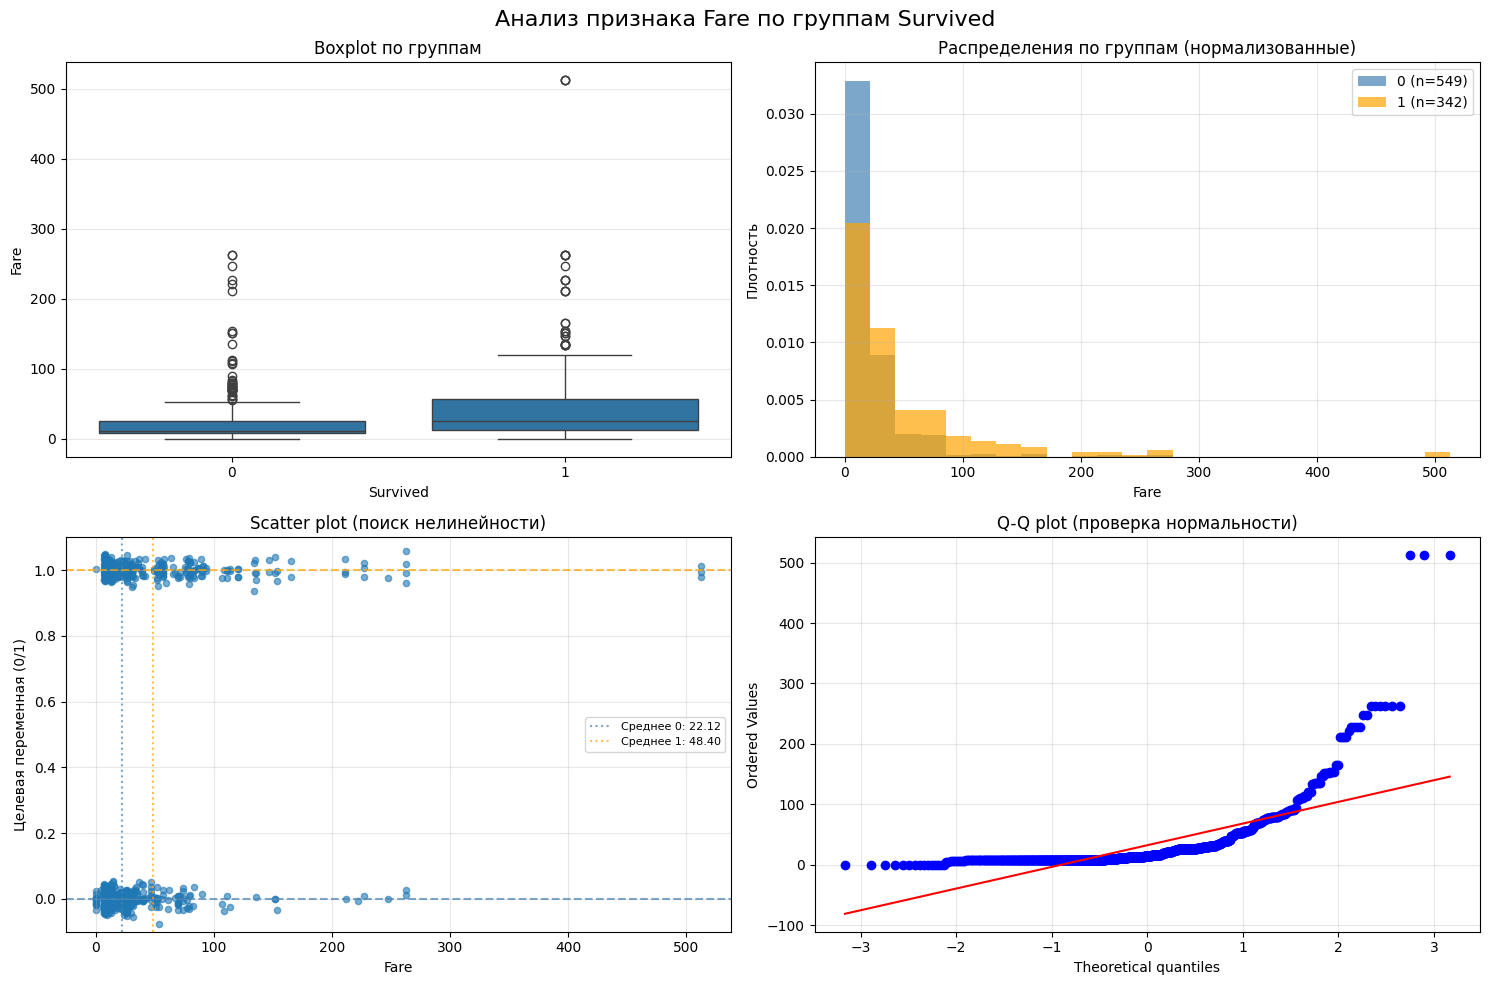


🔬 Статистические тесты:
   • Тест Левена (равенство дисперсий): p = 0.000000
   • t-тест (Welch): статистика = -6.8391, p = 0.0000000000
   • U-тест Манна-Уитни: статистика = 57806, p = 0.0000000000
   • Корреляция Пирсона: 0.2573 (p = 0.000000)
   • Корреляция Спирмена: 0.3237 (p = 0.000000)
   • Взаимная информация: 0.1235

🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Тест Шапиро-Уилка (нормальность): p = 0.000000
   • Размер эффекта (Cohen's d): 0.5469

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ СВЯЗЬ ОБНАРУЖЕНА: p = 0.000000 < 0.05
   Признак статистически значимо связан с целевой переменной

🚨 ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ:
   • ВОЗМОЖНА НЕЛИНЕЙНАЯ СВЯЗЬ
   • ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ
   • МНОГО ВЫБРОСОВ (13.0%)

💡 РЕКОМЕНДАЦИИ:
   • Рассмотреть полиномиальные признаки, биннинг или нелинейные модели
   • Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы
   • Рассмотреть удаление или обработку выбросов

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ использовать в моде

{'p_value': np.float64(4.553477179250237e-22),
 'effect_size': np.float64(0.54691006153194),
 'mutual_info': np.float64(0.1235317678682577),
 'is_significant': np.True_,
 'issues_found': ['ВОЗМОЖНА НЕЛИНЕЙНАЯ СВЯЗЬ',
  'ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ',
  'МНОГО ВЫБРОСОВ (13.0%)'],
 'recommendations': ['• Рассмотреть полиномиальные признаки, биннинг или нелинейные модели',
  '• Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы',
  '• Рассмотреть удаление или обработку выбросов']}

In [10]:
binary_analyze_numerical(df, 'Fare', 'Survived')

--- Расширенный анализ связи между 'Age' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 714
   • Доля пропусков: 19.87%
   • Размер группы '0': 424
   • Размер группы '1': 290

📈 Описательная статистика по группам:
          count     mean  median      std   min   max
Survived                                             
0           424  30.6262    28.0  14.1721  1.00  74.0
1           290  28.3437    28.0  14.9510  0.42  80.0


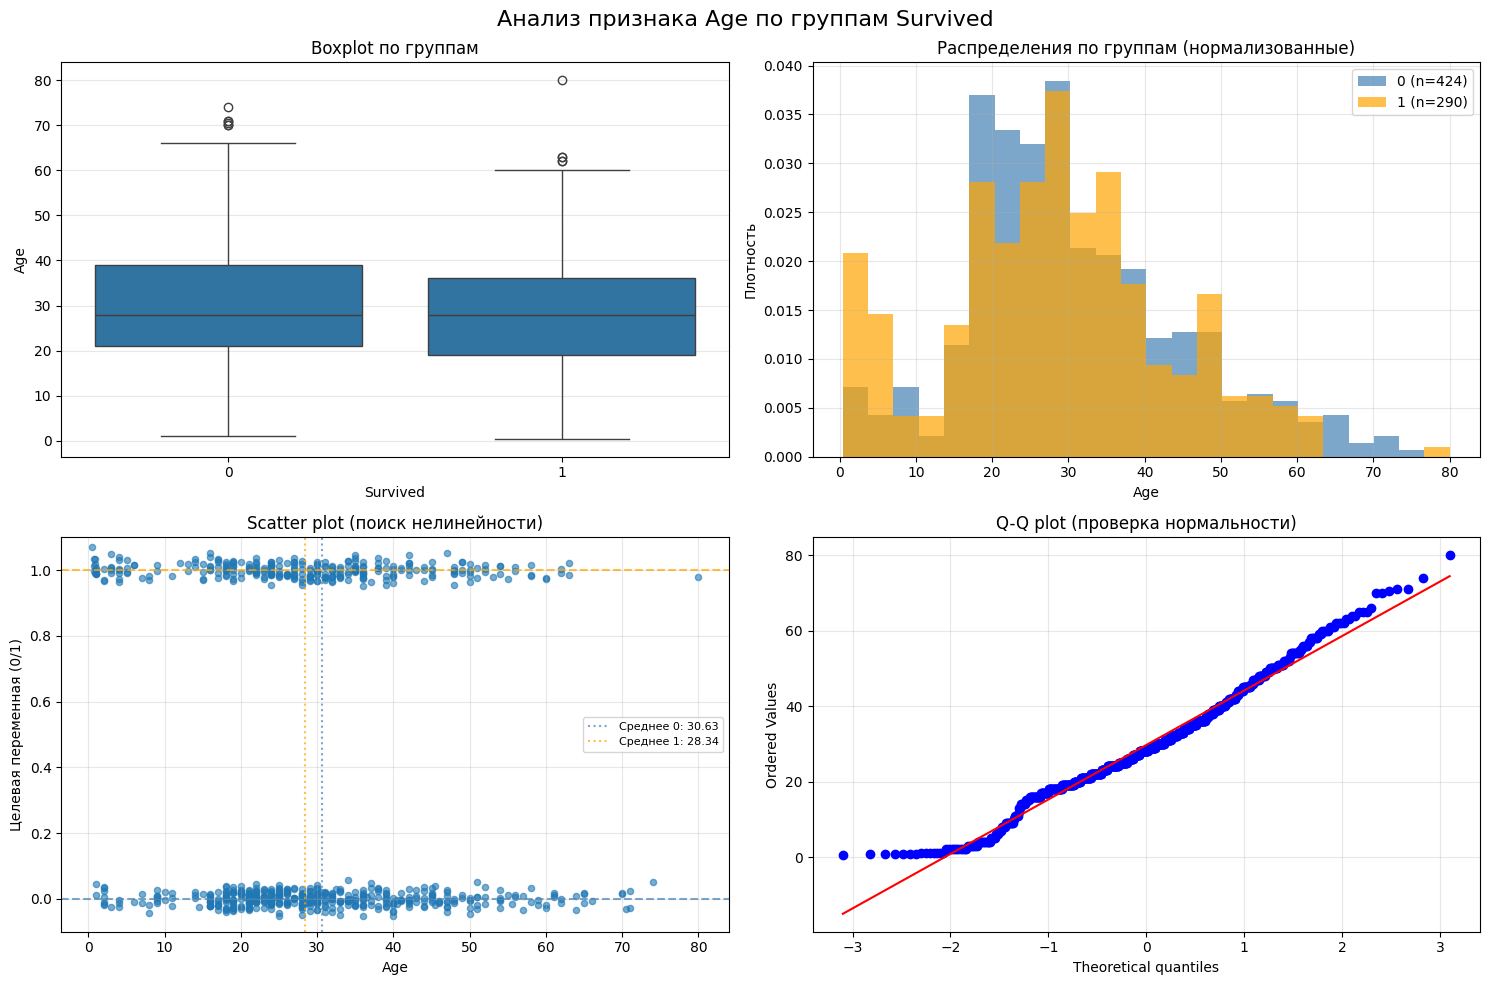


🔬 Статистические тесты:
   • Тест Левена (равенство дисперсий): p = 0.274616
   • t-тест (Student): статистика = 2.0667, p = 0.0391246540
   • U-тест Манна-Уитни: статистика = 65278, p = 0.1604925248
   • Корреляция Пирсона: -0.0772 (p = 0.039125)
   • Корреляция Спирмена: -0.0526 (p = 0.160589)
   • Взаимная информация: 0.0227

🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Тест Шапиро-Уилка (нормальность): p = 0.000000
   • Размер эффекта (Cohen's d): 0.1575

📋 ИТОГОВЫЙ АНАЛИЗ:
❌ ЗНАЧИМАЯ СВЯЗЬ НЕ ОБНАРУЖЕНА: p = 0.160493 >= 0.05

🚨 ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ:
   • ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (19.9%)
   • ПРОПУСКИ НЕ СЛУЧАЙНЫ (связаны с целевой переменной)
   • ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ

💡 РЕКОМЕНДАЦИИ:
   • Рассмотреть методы заполнения пропусков или анализ механизма пропусков
   • Пропуски могут нести информацию - рассмотреть индикаторные переменные
   • Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ 

{'p_value': np.float64(0.16049252477737763),
 'effect_size': np.float64(0.15748597191363295),
 'mutual_info': np.float64(0.022721189886358406),
 'is_significant': np.False_,
 'issues_found': ['ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (19.9%)',
  'ПРОПУСКИ НЕ СЛУЧАЙНЫ (связаны с целевой переменной)',
  'ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ'],
 'recommendations': ['• Рассмотреть методы заполнения пропусков или анализ механизма пропусков',
  '• Пропуски могут нести информацию - рассмотреть индикаторные переменные',
  '• Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы']}

In [11]:
binary_analyze_numerical(df, 'Age', 'Survived')

--- Расширенный анализ связи между 'SibSp' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Тип признака: Дискретный числовой
   • Количество уникальных значений в 'SibSp': 7
   • Размер групп целевой переменной: {0: np.int64(549), 1: np.int64(342)}

📋 Таблица сопряженности:
Survived    0    1
SibSp             
0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0

📊 Относительные частоты (по строкам):
Survived      0      1
SibSp                 
0         0.655  0.345
1         0.464  0.536
2         0.536  0.464
3         0.750  0.250
4         0.833  0.167
5         1.000  0.000
8         1.000  0.000

🔬 Статистические тесты:
   • Хи-квадрат: χ² = 37.2718, df = 6
   • P-значение (χ²): 0.0000015586
   • Статистически значимая связь (χ²): Да
   • Коэффициент Крамера V: 0.2045
   • Взаимная информация: 0.0242

🔢 Допо

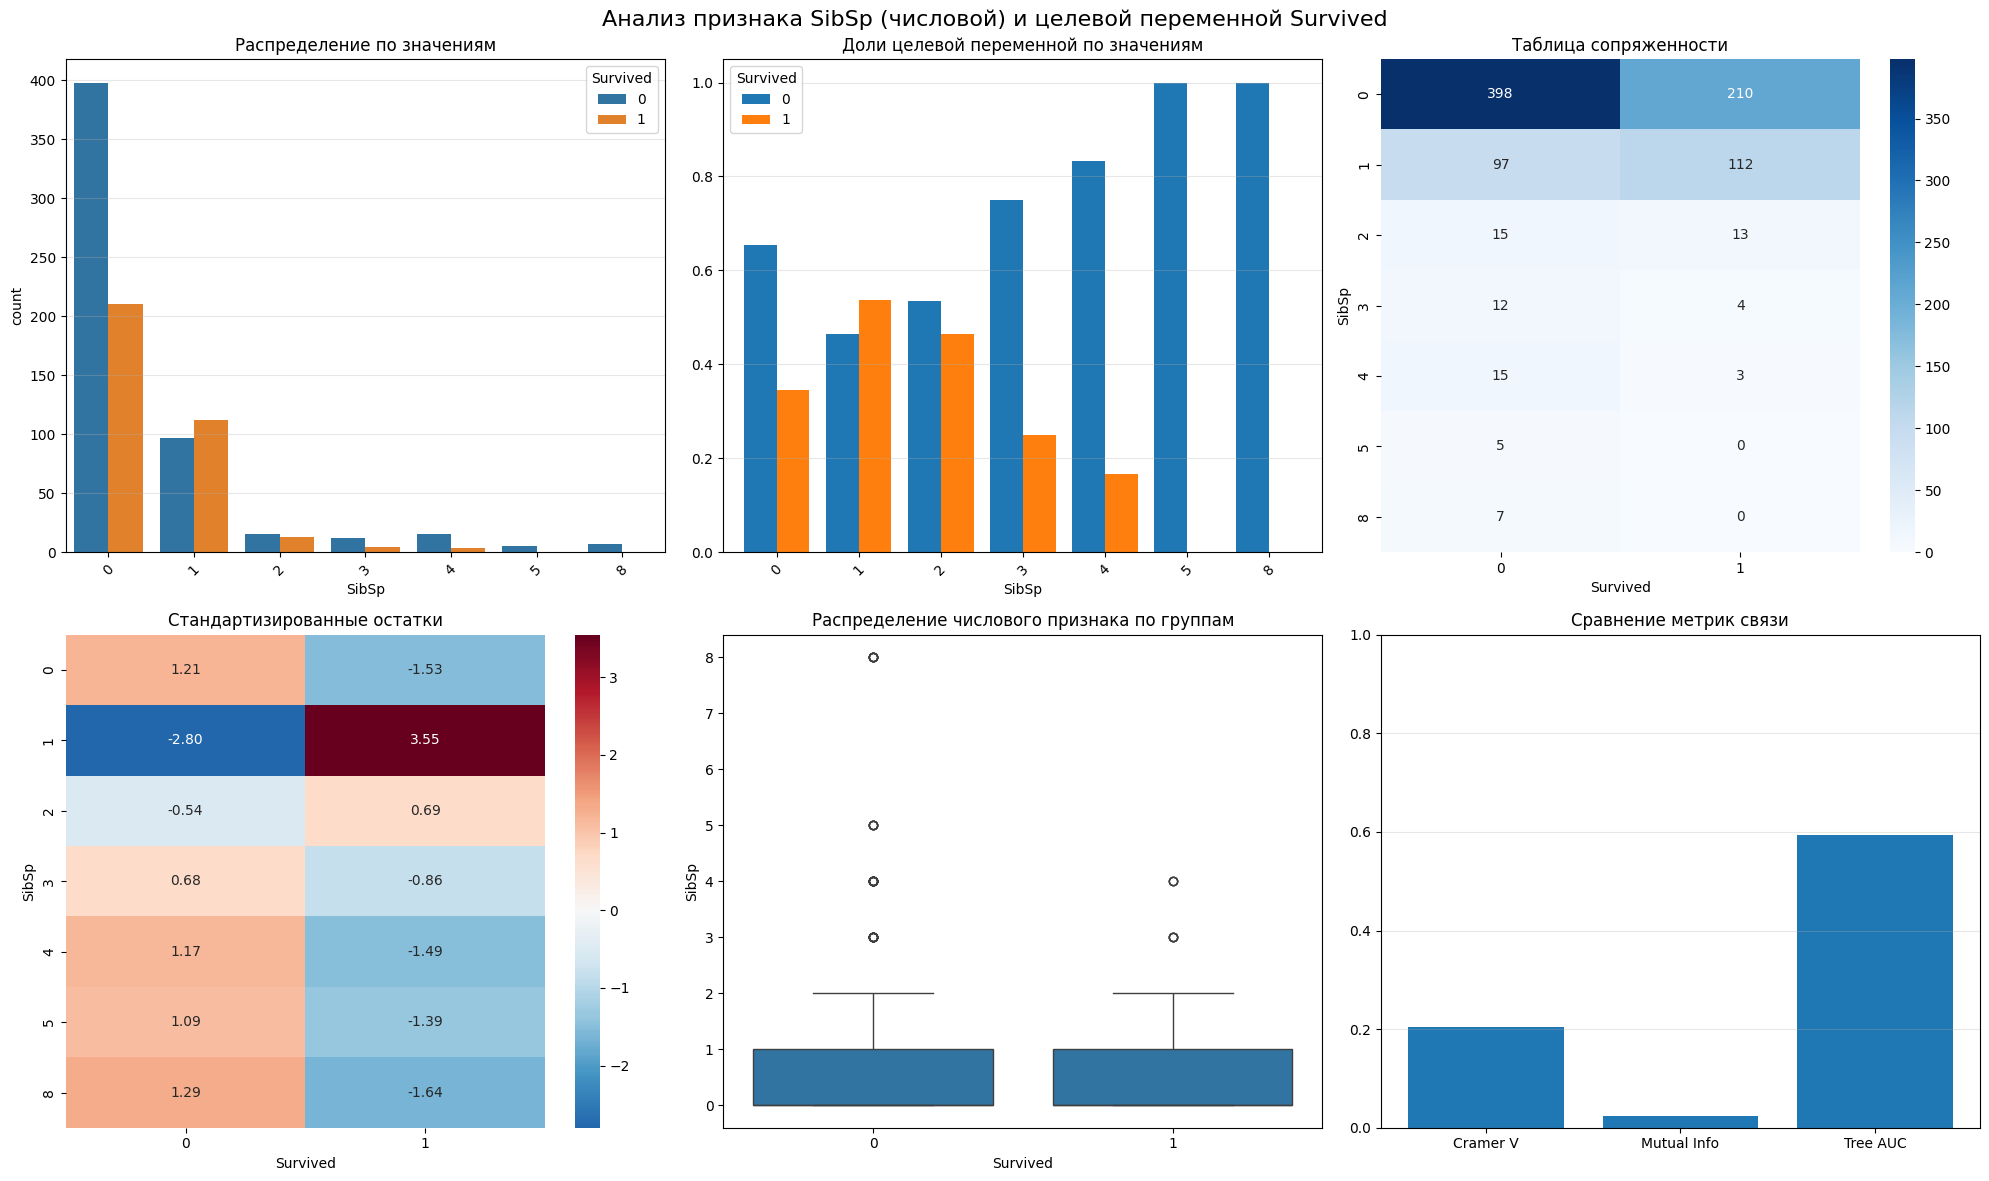


🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Ячеек с ожидаемой частотой < 5: 4/14 (28.6%)

🛠️  РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ:
   • Объединить редкие категории в группу 'Другие': [8, 5]
   • Для числового признака рассмотреть:
     - Биннинг (разбиение на интервалы)
     - Полиномиальные признаки для нелинейности
     - Логарифмическое или другое преобразование

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ СВЯЗЬ ОБНАРУЖЕНА: χ²-тест, Манн-Уитни
   • Наилучшая метрика: 0.5943
   • Преобладает нелинейная связь

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях
   • Признак показывает хорошую предсказательную способность
   • Рекомендуются нелинейные модели (деревья, нейросети)
   • Можно использовать как категориальный (One-Hot)

--- Конец расширенного анализа ---
--------------------------------------------------------------------------------


{'chi2_pvalue': np.float64(1.5585810465902147e-06),
 'cramers_v': np.float64(0.2045273023663305),
 'mutual_info': np.float64(0.024192476763929216),
 'tree_auc': np.float64(0.5942862621033457),
 'is_significant': True,
 'best_metric': np.float64(0.2045273023663305),
 'is_numeric': True,
 'recommendations': ['• Объединить редкие категории или использовать точный тест Фишера',
  '• Рассмотреть объединение категорий: [8, 5]',
  '• Рассмотреть ресэмплинг или взвешивание классов',
  '• Рассмотреть точный тест Фишера для малых выборок'],
 'issues_found': ['НАРУШЕНЫ УСЛОВИЯ ХИ-КВАДРАТ ТЕСТА (28.6% ячеек с частотой < 5)',
  'РЕДКИЕ КАТЕГОРИИ: [8, 5]',
  'СИЛЬНЫЙ ДИСБАЛАНС КАТЕГОРИЙ (разница в 121.6x)']}

In [12]:
binary_analyze_categorical(df, 'SibSp', 'Survived')

--- Расширенный анализ связи между 'Parch' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Тип признака: Дискретный числовой
   • Количество уникальных значений в 'Parch': 7
   • Размер групп целевой переменной: {0: np.int64(549), 1: np.int64(342)}

📋 Таблица сопряженности:
Survived    0    1
Parch             
0         445  233
1          53   65
2          40   40
3           2    3
4           4    0
5           4    1
6           1    0

📊 Относительные частоты (по строкам):
Survived      0      1
Parch                 
0         0.656  0.344
1         0.449  0.551
2         0.500  0.500
3         0.400  0.600
4         1.000  0.000
5         0.800  0.200
6         1.000  0.000

🔬 Статистические тесты:
   • Хи-квадрат: χ² = 27.9258, df = 6
   • P-значение (χ²): 0.0000970353
   • Статистически значимая связь (χ²): Да
   • Коэффициент Крамера V: 0.1770
   • Взаимная информация: 0.0096

🔢 Допо

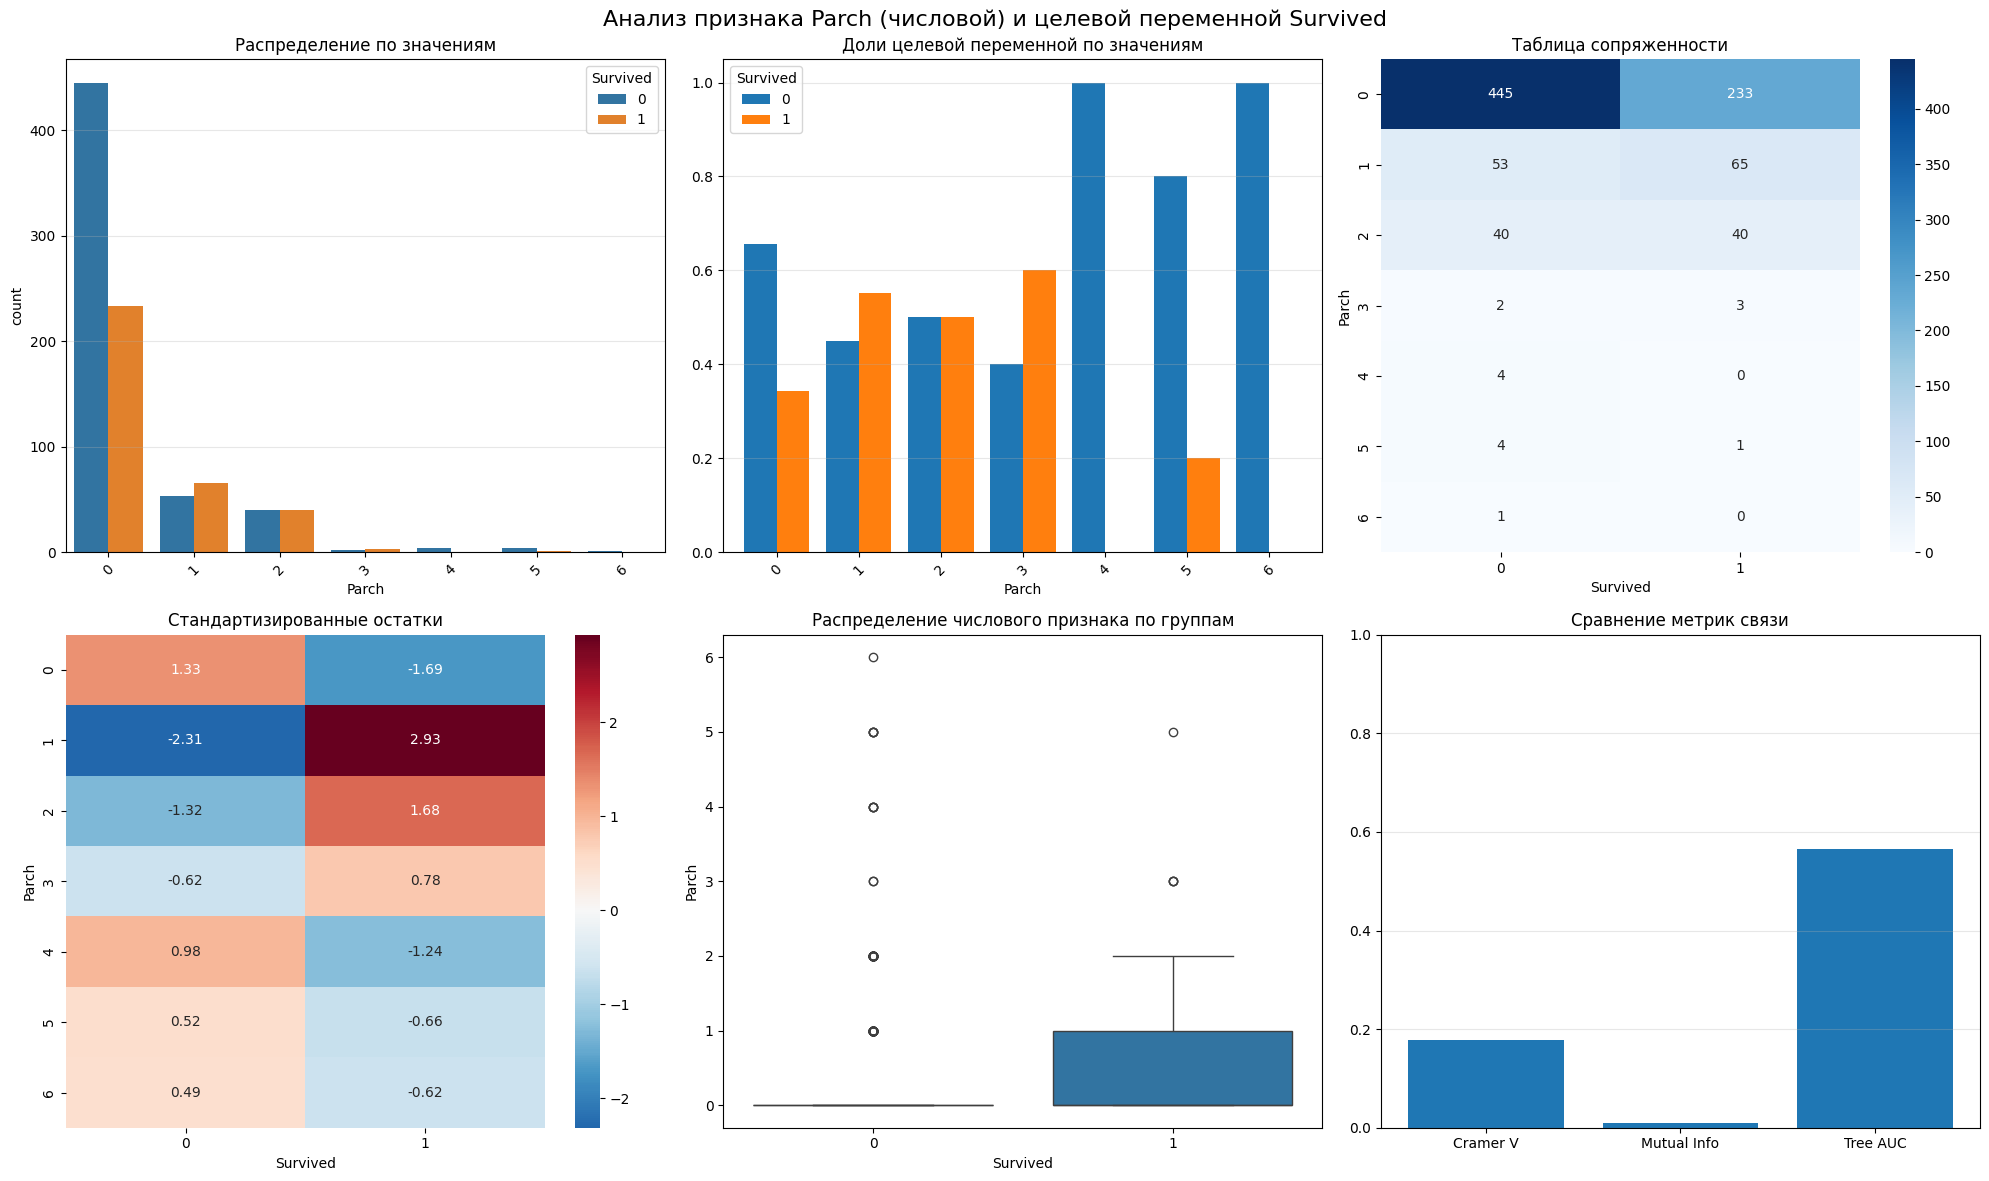


🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Ячеек с ожидаемой частотой < 5: 8/14 (57.1%)

🛠️  РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ:
   • Объединить редкие категории в группу 'Другие': [5, 3, 4, 6]
   • Для числового признака рассмотреть:
     - Биннинг (разбиение на интервалы)
     - Полиномиальные признаки для нелинейности
     - Логарифмическое или другое преобразование

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ СВЯЗЬ ОБНАРУЖЕНА: χ²-тест, Манн-Уитни
   • Наилучшая метрика: 0.5645
   • Преобладает нелинейная связь

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях
   • Рекомендуются нелинейные модели (деревья, нейросети)
   • Можно использовать как категориальный (One-Hot)

--- Конец расширенного анализа ---
--------------------------------------------------------------------------------


{'chi2_pvalue': np.float64(9.703526421039996e-05),
 'cramers_v': np.float64(0.177036916072161),
 'mutual_info': np.float64(0.009616127177211053),
 'tree_auc': np.float64(0.5644952545297671),
 'is_significant': True,
 'best_metric': np.float64(0.177036916072161),
 'is_numeric': True,
 'recommendations': ['• Объединить редкие категории или использовать точный тест Фишера',
  '• Рассмотреть объединение категорий: [5, 3, 4, 6]',
  '• Рассмотреть ресэмплинг или взвешивание классов',
  '• Рассмотреть точный тест Фишера для малых выборок'],
 'issues_found': ['НАРУШЕНЫ УСЛОВИЯ ХИ-КВАДРАТ ТЕСТА (57.1% ячеек с частотой < 5)',
  'РЕДКИЕ КАТЕГОРИИ: [5, 3, 4, 6]',
  'СИЛЬНЫЙ ДИСБАЛАНС КАТЕГОРИЙ (разница в 678.0x)']}

In [13]:
binary_analyze_categorical(df, 'Parch', 'Survived')

--- Расширенный анализ связи между 'Pclass' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Тип признака: Дискретный числовой
   • Количество уникальных значений в 'Pclass': 3
   • Размер групп целевой переменной: {0: np.int64(549), 1: np.int64(342)}

📋 Таблица сопряженности:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

📊 Относительные частоты (по строкам):
Survived      0      1
Pclass                
1         0.370  0.630
2         0.527  0.473
3         0.758  0.242

🔬 Статистические тесты:
   • Хи-квадрат: χ² = 102.8890, df = 2
   • P-значение (χ²): 0.0000000000
   • Статистически значимая связь (χ²): Да
   • Коэффициент Крамера V: 0.3398
   • Взаимная информация: 0.0477

🔢 Дополнительные тесты для числового признака:
   • Нормальность в группе 0: p = 0.000000 (не норм.)
   • Нормальность в группе 1: p = 0.000000 (не норм.)
   • Тест Манна-

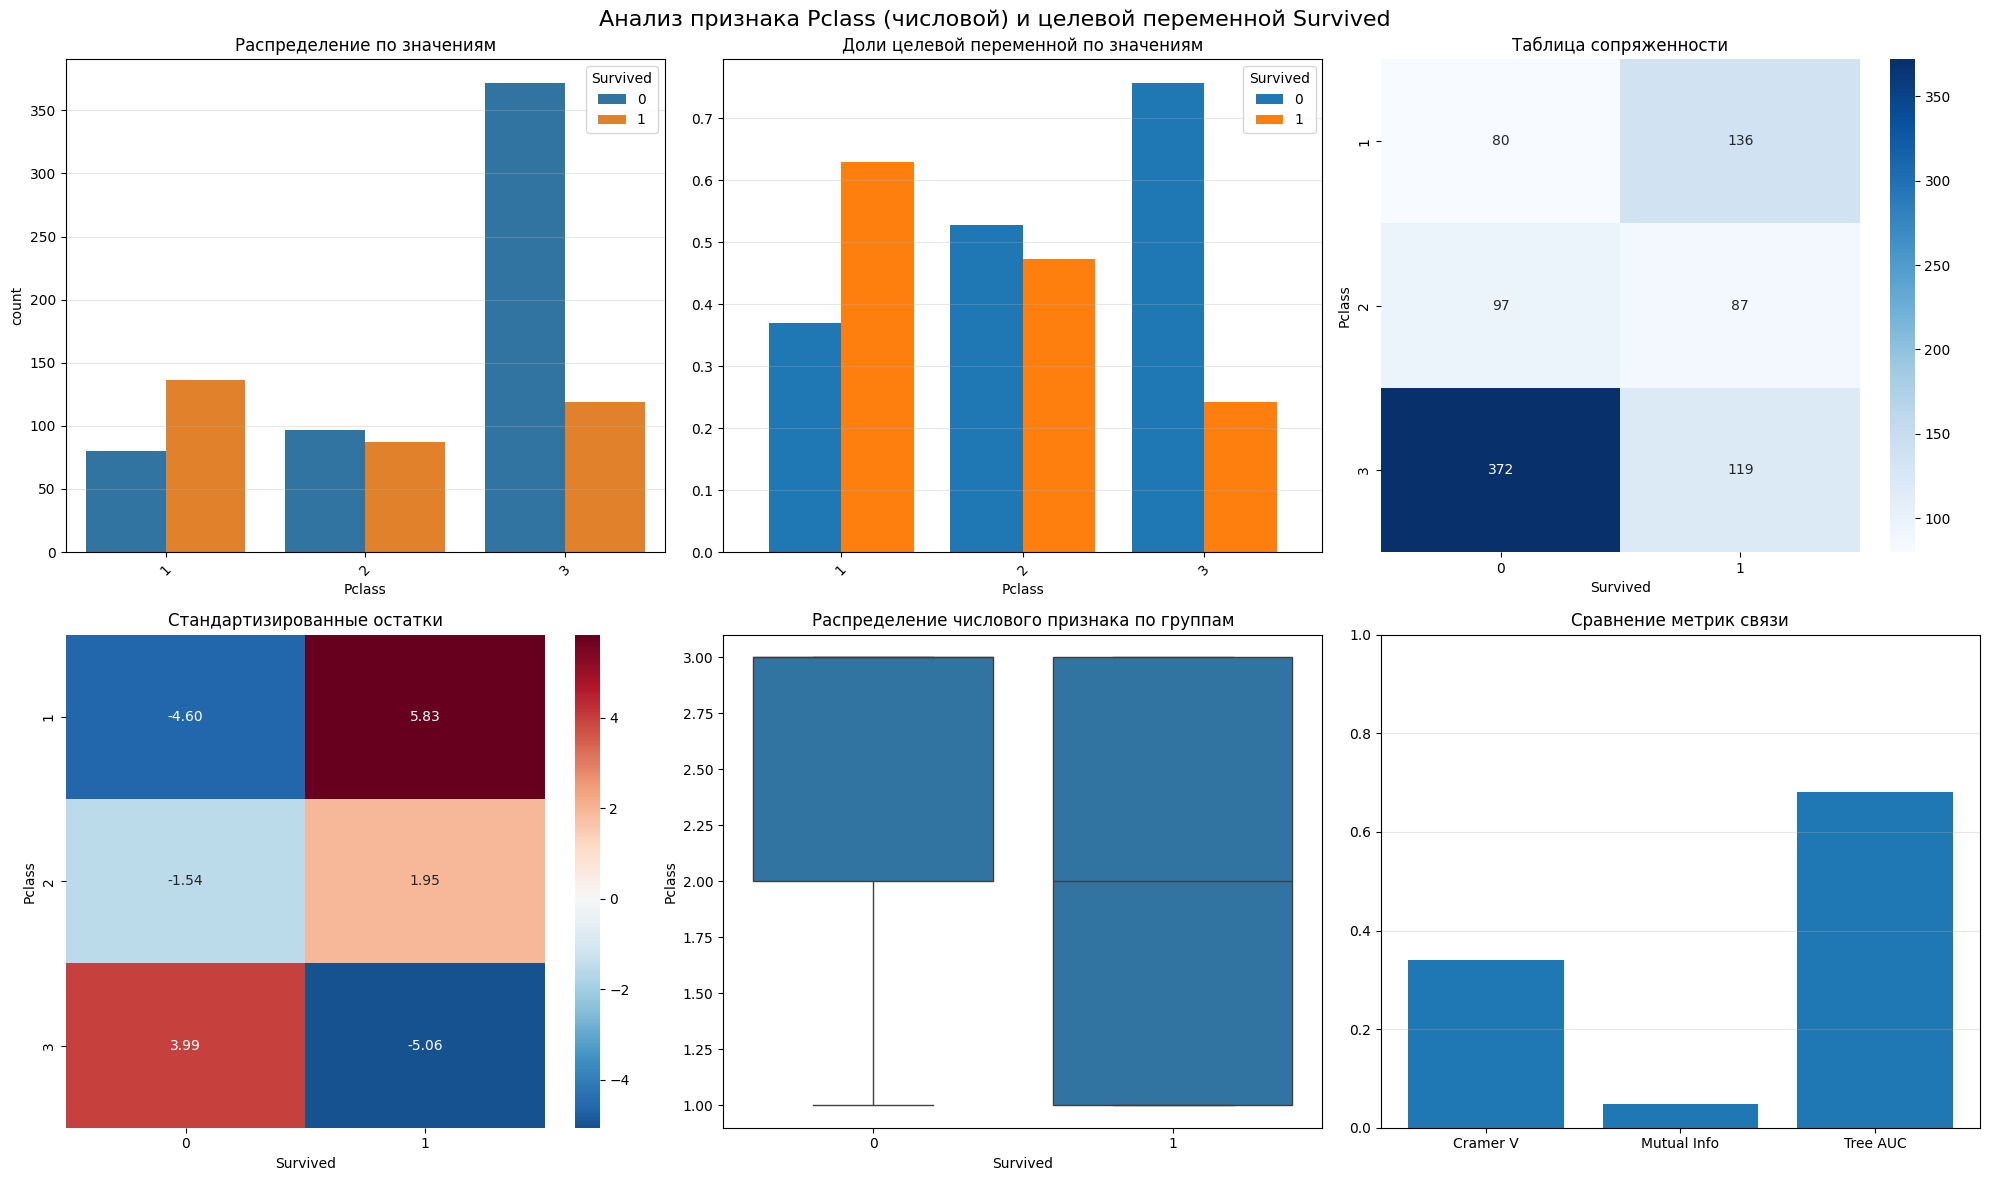


🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Ячеек с ожидаемой частотой < 5: 0/6 (0.0%)

🛠️  РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ:
   • Для числового признака рассмотреть:
     - Биннинг (разбиение на интервалы)
     - Полиномиальные признаки для нелинейности
     - Логарифмическое или другое преобразование
     - Использование дерева решений для извлечения правил

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ СВЯЗЬ ОБНАРУЖЕНА: χ²-тест, Манн-Уитни, Нелинейная связь
   • Наилучшая метрика: 0.6812
   • Преобладает нелинейная связь

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях
   • Признак показывает хорошую предсказательную способность
   • Рекомендуются нелинейные модели (деревья, нейросети)
   • Можно использовать как категориальный (One-Hot)

--- Конец расширенного анализа ---
--------------------------------------------------------------------------------


{'chi2_pvalue': np.float64(4.549251711298793e-23),
 'cramers_v': np.float64(0.33981738800531175),
 'mutual_info': np.float64(0.04771648198998624),
 'tree_auc': np.float64(0.681150736586457),
 'is_significant': True,
 'best_metric': np.float64(0.33981738800531175),
 'is_numeric': True,
 'recommendations': [],
 'issues_found': []}

In [14]:
binary_analyze_categorical(df, 'Pclass', 'Survived')

--- Расширенный анализ связи между 'Sex' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Тип признака: Категориальный
   • Количество уникальных значений в 'Sex': 2
   • Размер групп целевой переменной: {0: np.int64(549), 1: np.int64(342)}

📋 Таблица сопряженности:
Survived    0    1
Sex               
female     81  233
male      468  109

📊 Относительные частоты (по строкам):
Survived      0      1
Sex                   
female    0.258  0.742
male      0.811  0.189

🔬 Статистические тесты:
   • Хи-квадрат: χ² = 260.7170, df = 1
   • P-значение (χ²): 0.0000000000
   • Статистически значимая связь (χ²): Да
   • Коэффициент Крамера V: 0.5409
   • Взаимная информация: 0.1423

🌳 Анализ нелинейности:
   • Линейная связь (мера): 0.5409
   • Нелинейная связь (AUC дерева): 0.7669
   • Обнаружена нелинейная связь: разница 0.2259


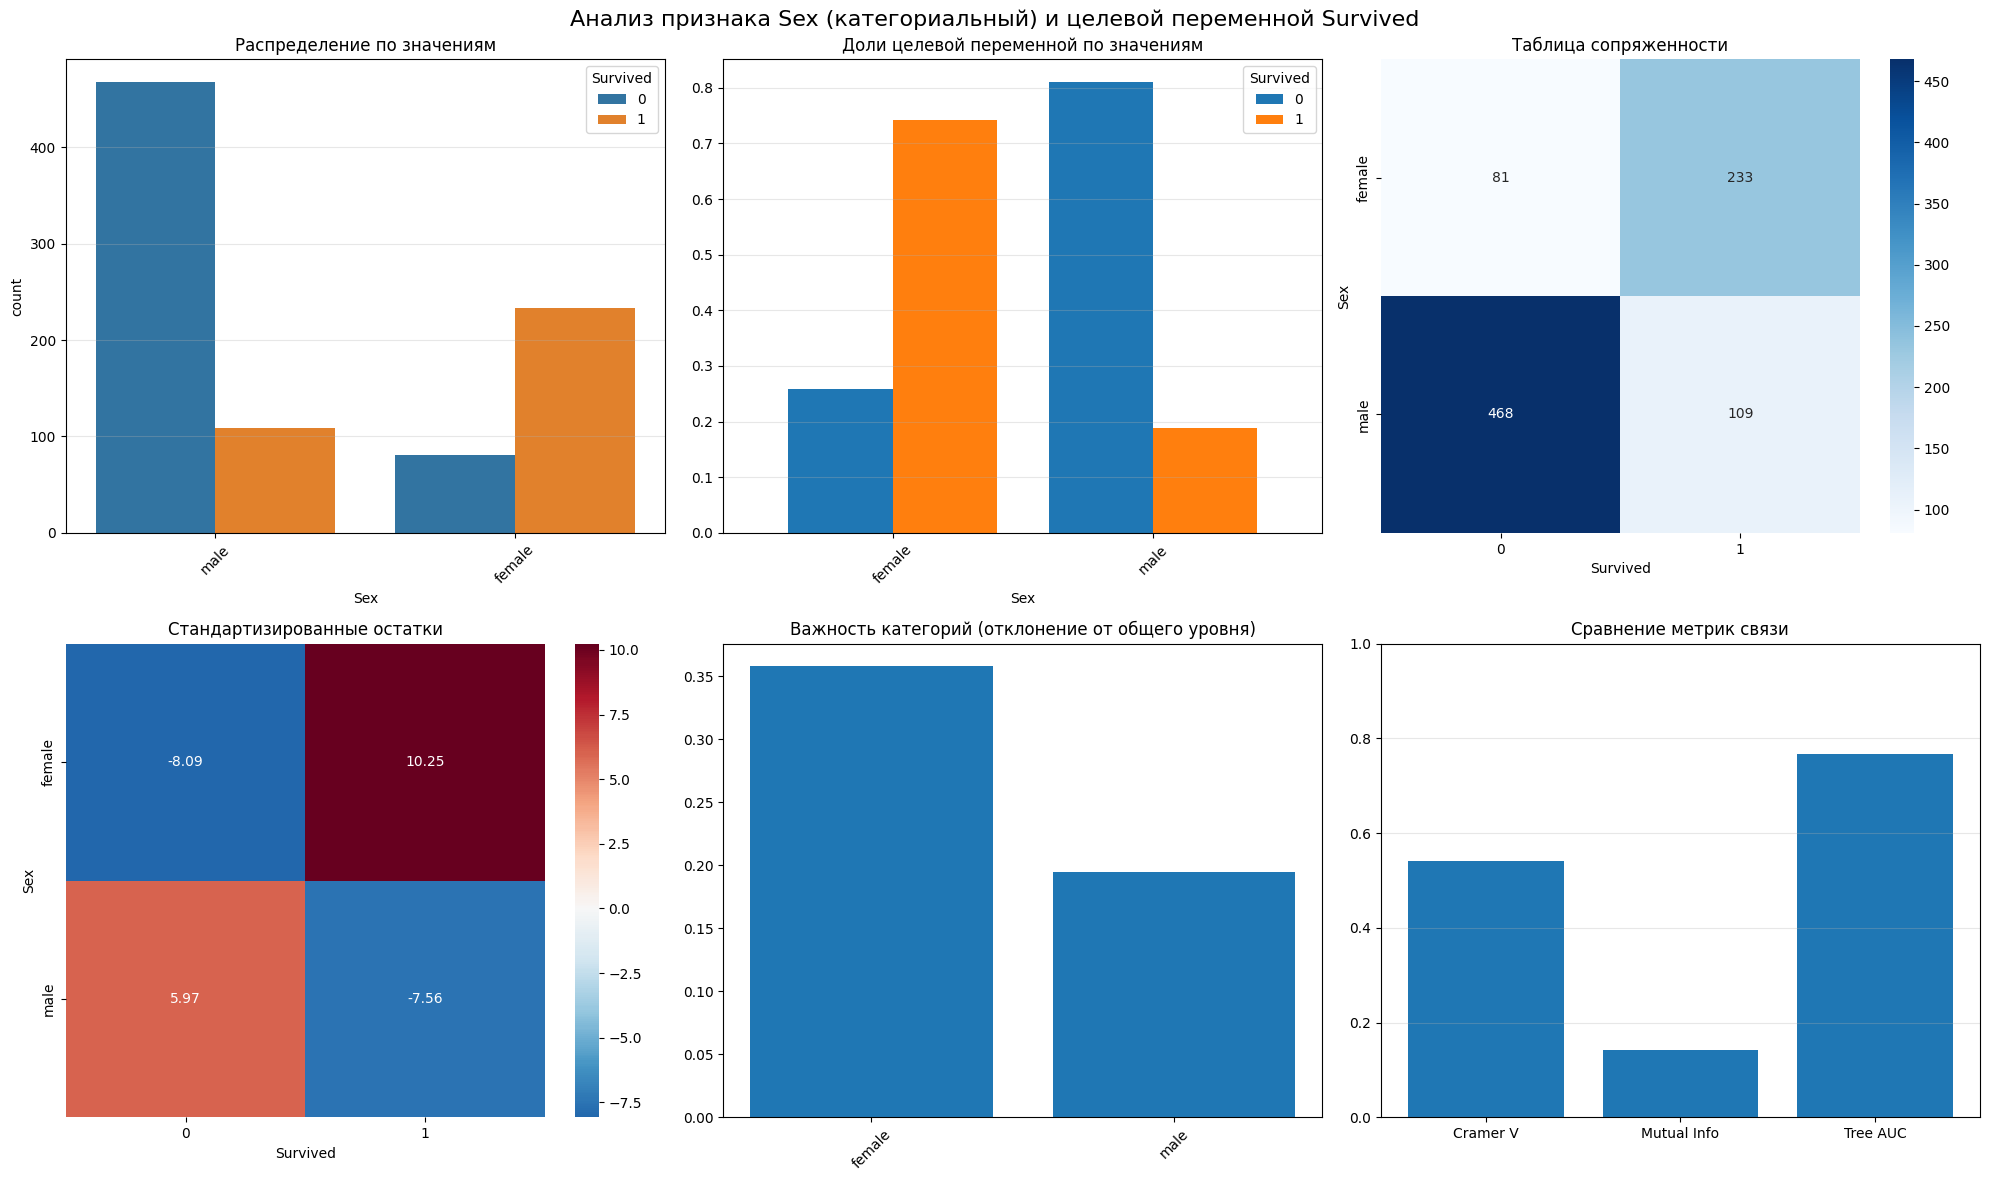


🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Ячеек с ожидаемой частотой < 5: 0/4 (0.0%)

🛠️  РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ:

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ СВЯЗЬ ОБНАРУЖЕНА: χ²-тест, Нелинейная связь
   • Наилучшая метрика: 0.7669
   • Преобладает нелинейная связь

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях
   • Признак показывает хорошую предсказательную способность
   • Рекомендуются нелинейные модели (деревья, нейросети)
   • Можно использовать One-Hot Encoding

--- Конец расширенного анализа ---
--------------------------------------------------------------------------------


{'chi2_pvalue': np.float64(1.1973570627755645e-58),
 'cramers_v': np.float64(0.5409359434469282),
 'mutual_info': np.float64(0.14231076523705433),
 'tree_auc': np.float64(0.7668727830505224),
 'is_significant': True,
 'best_metric': np.float64(0.5409359434469282),
 'is_numeric': False,
 'recommendations': [],
 'issues_found': []}

In [15]:
binary_analyze_categorical(df, 'Sex', 'Survived')

--- Расширенный анализ связи между 'Embarked' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 889
   • Доля пропусков: 0.22%
   • Тип признака: Категориальный
   • Количество уникальных значений в 'Embarked': 3
   • Размер групп целевой переменной: {0: np.int64(549), 1: np.int64(340)}

📋 Таблица сопряженности:
Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  217

📊 Относительные частоты (по строкам):
Survived      0      1
Embarked              
C         0.446  0.554
Q         0.610  0.390
S         0.663  0.337

🔬 Статистические тесты:
   • Хи-квадрат: χ² = 26.4891, df = 2
   • P-значение (χ²): 0.0000017699
   • Статистически значимая связь (χ²): Да
   • Коэффициент Крамера V: 0.1726
   • Взаимная информация: 0.0411

🌳 Анализ нелинейности:
   • Линейная связь (мера): 0.1726
   • Нелинейная связь (AUC дерева): 0.5540
   • Нелинейная связь слабая или отсутствует


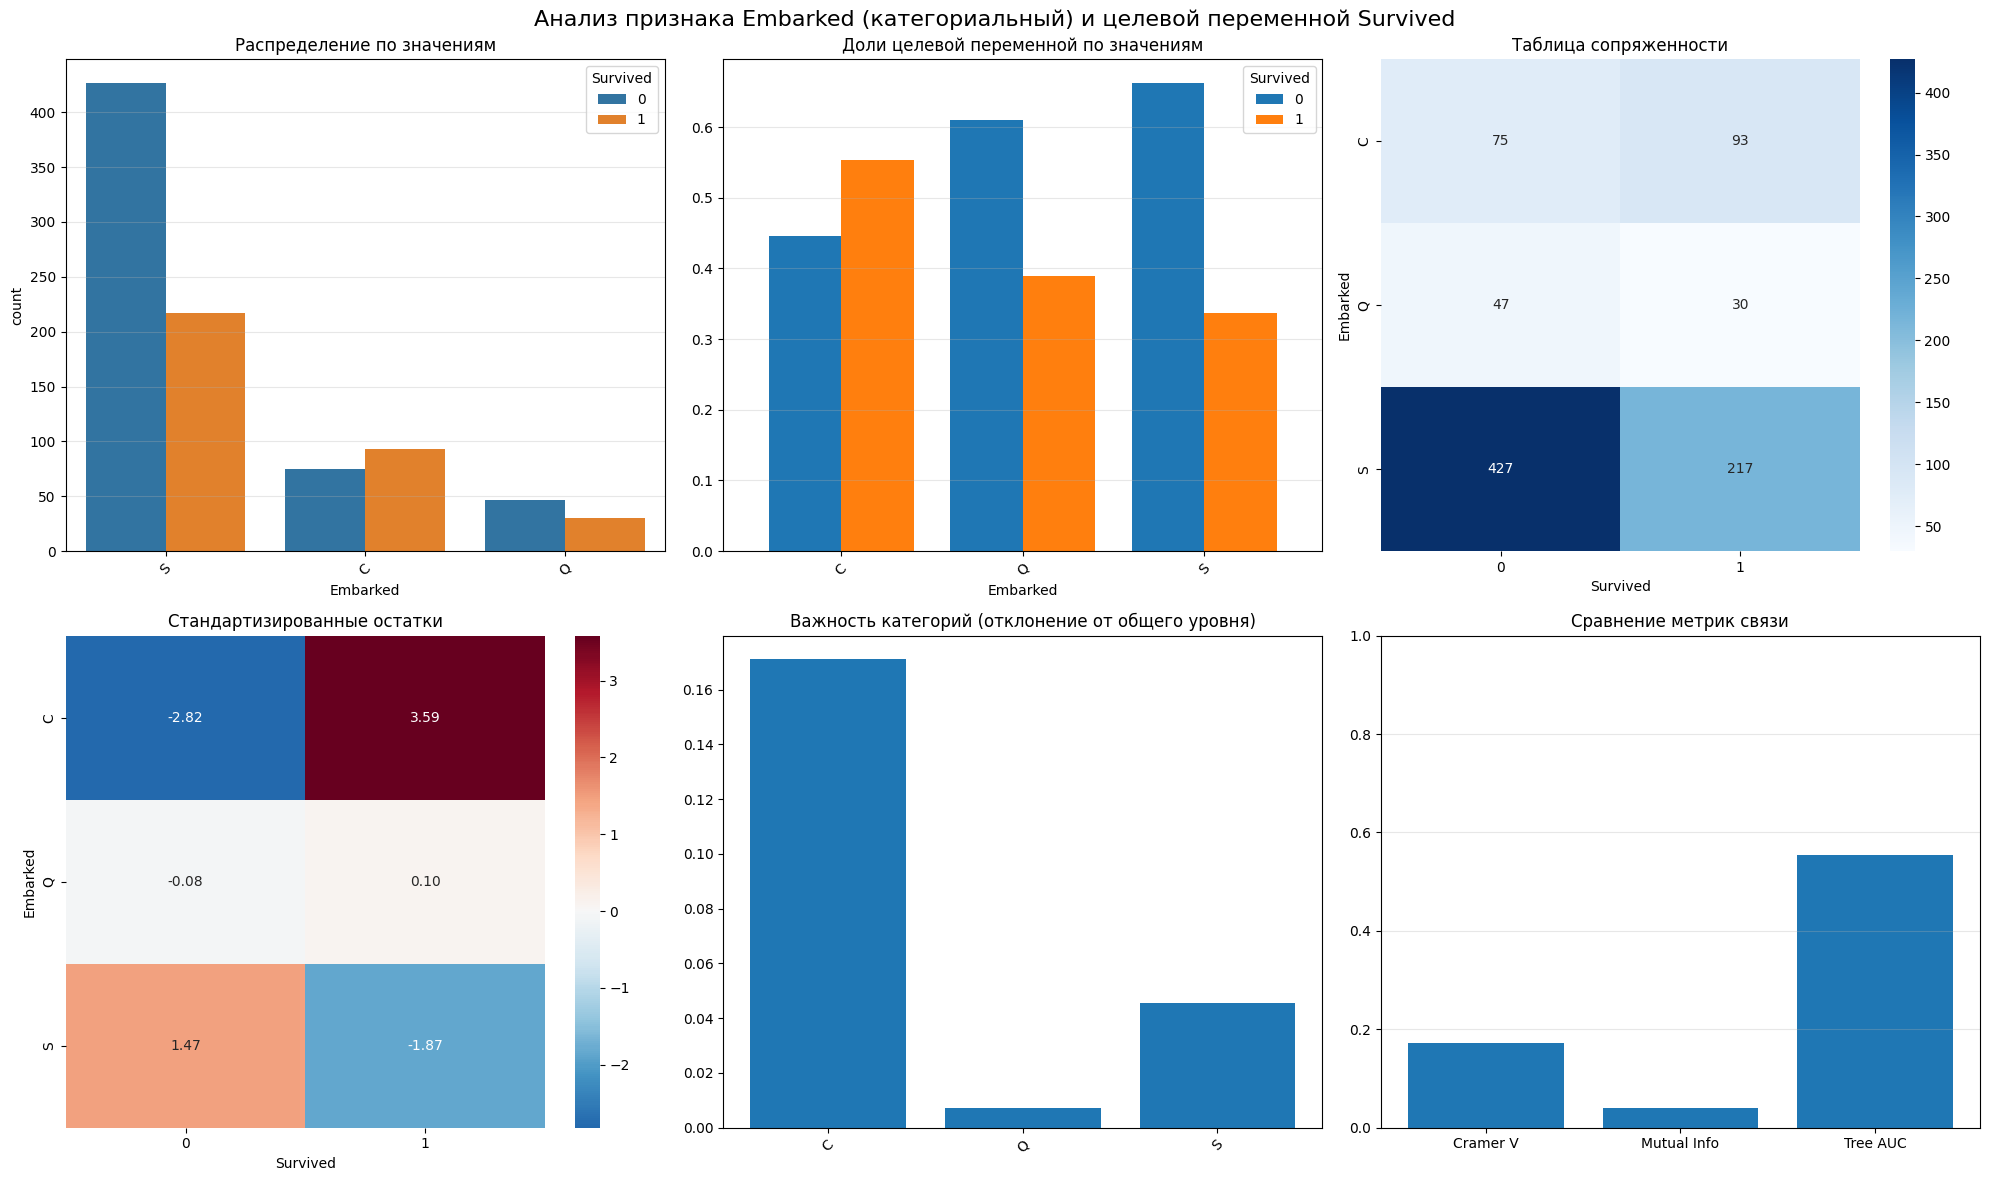


🔍 ДИАГНОСТИКА ПРИЧИН СЛАБОЙ СВЯЗИ:
   • Ячеек с ожидаемой частотой < 5: 0/6 (0.0%)

🛠️  РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ:
   • Рассмотреть различные методы кодирования:
     - One-Hot Encoding для независимых категорий
     - Target Encoding для категорий с разным влиянием
     - Binary Encoding для категорий с естественным порядком

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ СВЯЗЬ ОБНАРУЖЕНА: χ²-тест
   • Наилучшая метрика: 0.5540
   • Преобладает нелинейная связь

🎯 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ ПРИЗНАКА:
   ✅ РЕКОМЕНДУЕТСЯ использовать в моделях
   • Рекомендуются нелинейные модели (деревья, нейросети)
   • Можно использовать One-Hot Encoding

--- Конец расширенного анализа ---
--------------------------------------------------------------------------------


{'chi2_pvalue': np.float64(1.769922284120912e-06),
 'cramers_v': np.float64(0.17261682709984438),
 'mutual_info': np.float64(0.04108371147581469),
 'tree_auc': np.float64(0.5539996080437565),
 'is_significant': True,
 'best_metric': np.float64(0.17261682709984438),
 'is_numeric': False,
 'recommendations': ['• Рассмотреть объединение категорий со схожим распределением'],
 'issues_found': ["НЕИНФОРМАТИВНЫЕ КАТЕГОРИИ: ['Q', 'S']"]}

In [16]:
binary_analyze_categorical(df, 'Embarked', 'Survived')

--- Анализ высококардинального категориального признака 'Ticket' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Количество уникальных значений: 681
   • Отношение кардинальности к размеру выборки: 0.7643
   • Размер групп целевой переменной: {0: np.int64(549), 1: np.int64(342)}
   • Тип кардинальности: Очень высокая кардинальность

📈 Анализ распределения частот:
   • Среднее количество наблюдений на категорию: 1.31
   • Медианное количество: 1
   • Максимальное количество: 7
   • Минимальное количество: 1
   • Категории с частотой < 5: 673 (98.8%)
   • Частые категории (≥ 5): 8 (1.2%)

🔍 Извлечение паттернов из строковых значений:
   • Средняя длина строки: 6.8
   • Диапазон длин: 3-18
   • Уникальных префиксов (2 символа): 56
   • Найдено числовых значений: 887
   • Уникальных буквенных частей: 18

🔄 Группировка редких категорий:
   • После группировки уникальных значений: 9
   • Размер группы

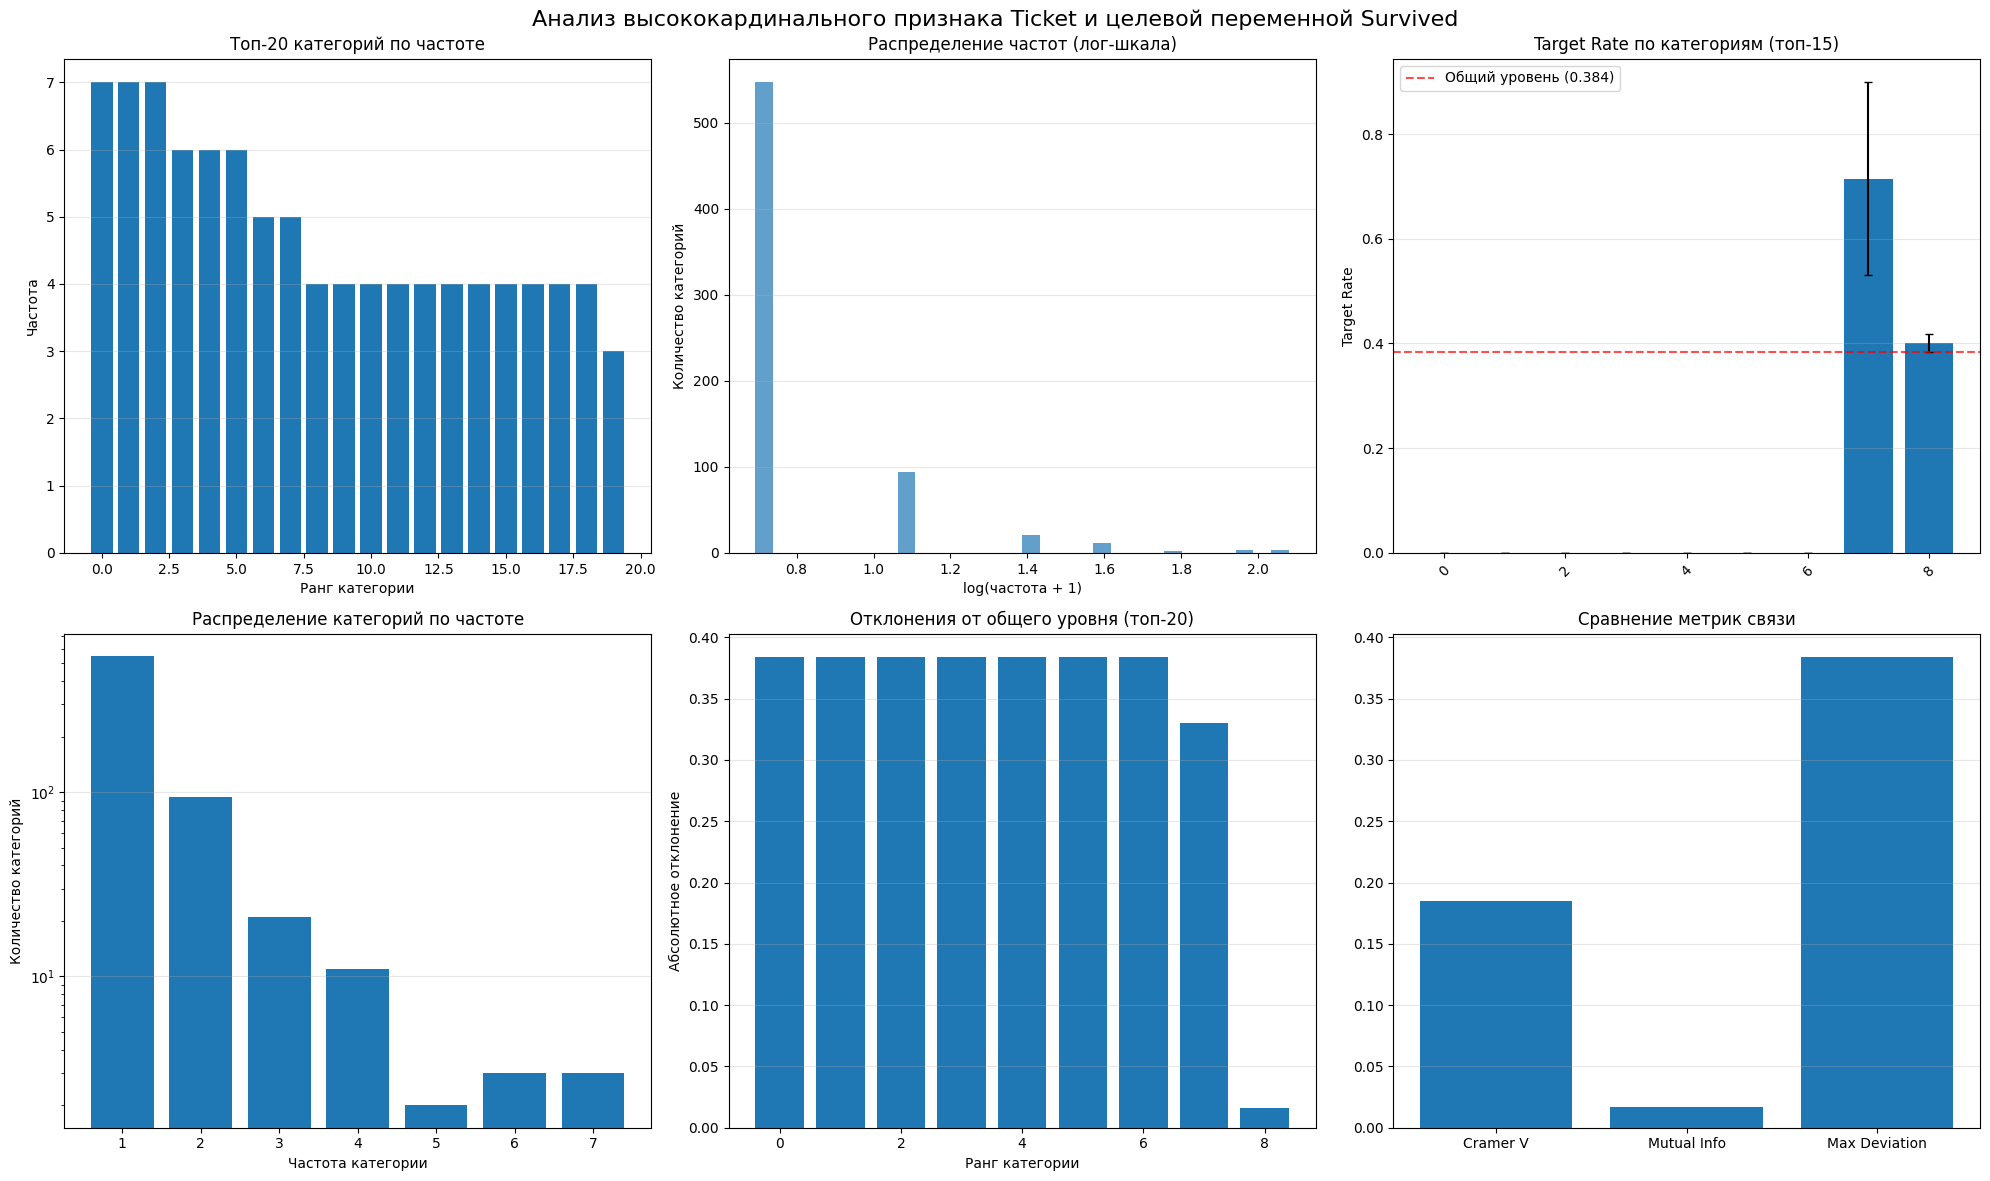


🔍 ДИАГНОСТИКА ВЫСОКОЙ КАРДИНАЛЬНОСТИ:

💡 РЕКОМЕНДАЦИИ ПО КОДИРОВАНИЮ:
   ✅ ВЫСОКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

🎨 РЕКОМЕНДАЦИИ ПО РАБОТЕ С ПАТТЕРНАМИ:

🤖 РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
   • Деревья решений с min_samples_leaf > 1
   • CatBoost (хорошо работает с категориальными)
   • Embedding слои в нейросетях
   • Избегать линейных моделей без регуляризации

📋 ИТОГОВЫЙ АНАЛИЗ:
✅ ПРИЗНАК РЕКОМЕНДУЕТСЯ К ИСПОЛЬЗОВАНИЮ
   • Наилучшая метрика: 0.3838
   • Статистическая значимость: p = 0.000183
   • Очень сильная предсказательная способность

🚨 ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ:
   • ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
   • МНОГО РЕДКИХ КАТЕГОРИЙ (673/681)
   • РАЗРЕЖЕННАЯ ТАБЛИЦА СОПРЯЖЕННОСТИ (88.9% ячеек < 5)

🛠️  СПИСОК РЕКОМЕНДАЦИЙ:
   1. • Обязательно применить регуляризацию в моделях
   2. • Рассмотреть частотное кодирование
   3. • Группировать редкие категории
   4. • Использовать min_samples_leaf в деревьях
   5. • Использовать точные статистические тесты
   6. • Target Encodin

{'cardinality': 681,
 'cardinality_ratio': 0.7643097643097643,
 'cardinality_type': 'Очень высокая кардинальность',
 'missing_rate': 0.0,
 'chi2_pvalue': np.float64(0.00018303535056519123),
 'cramers_v': np.float64(0.1845712295085834),
 'mutual_info': np.float64(0.016631525040440742),
 'max_deviation': np.float64(0.3838383838383838),
 'is_significant': np.True_,
 'rare_categories_count': 673,
 'patterns_extracted': ['prefixes', 'numeric_ranges', 'alpha_parts'],
 'top_categories': {'RARE_CATEGORIES': 842,
  '347082': 7,
  'CA. 2343': 7,
  '1601': 7,
  '3101295': 6,
  '347088': 6,
  'CA 2144': 6,
  '382652': 5,
  'S.O.C. 14879': 5},
 'target_encoding_potential': np.float64(0.3838383838383838),
 'recommendations': ['• Обязательно применить регуляризацию в моделях',
  '• Рассмотреть частотное кодирование',
  '• Группировать редкие категории',
  '• Использовать min_samples_leaf в деревьях',
  '• Использовать точные статистические тесты',
  '• Target Encoding с кросс-валидацией',
  '• Bayesi

In [17]:
analyze_high_cardinality_categorical(df, 'Ticket', 'Survived')

--- Анализ высококардинального категориального признака 'Cabin' и 'Survived' ---
📊 Базовая информация:
   • Исходный размер выборки: 891
   • После удаления пропусков: 204
   • Доля пропусков: 77.10%
   • Количество уникальных значений: 147
   • Отношение кардинальности к размеру выборки: 0.7206
   • Размер групп целевой переменной: {1: np.int64(136), 0: np.int64(68)}
   • Тип кардинальности: Очень высокая кардинальность

📈 Анализ распределения частот:
   • Среднее количество наблюдений на категорию: 1.39
   • Медианное количество: 1
   • Максимальное количество: 4
   • Минимальное количество: 1
   • Категории с частотой < 5: 147 (100.0%)
   • Частые категории (≥ 5): 0 (0.0%)

🔍 Извлечение паттернов из строковых значений:
   • Средняя длина строки: 3.6
   • Диапазон длин: 1-15
   • Уникальных префиксов (2 символа): 47
   • Найдено числовых значений: 200
   • Уникальных буквенных частей: 8

🔄 Группировка редких категорий:
   • После группировки уникальных значений: 1
   • Размер группы 

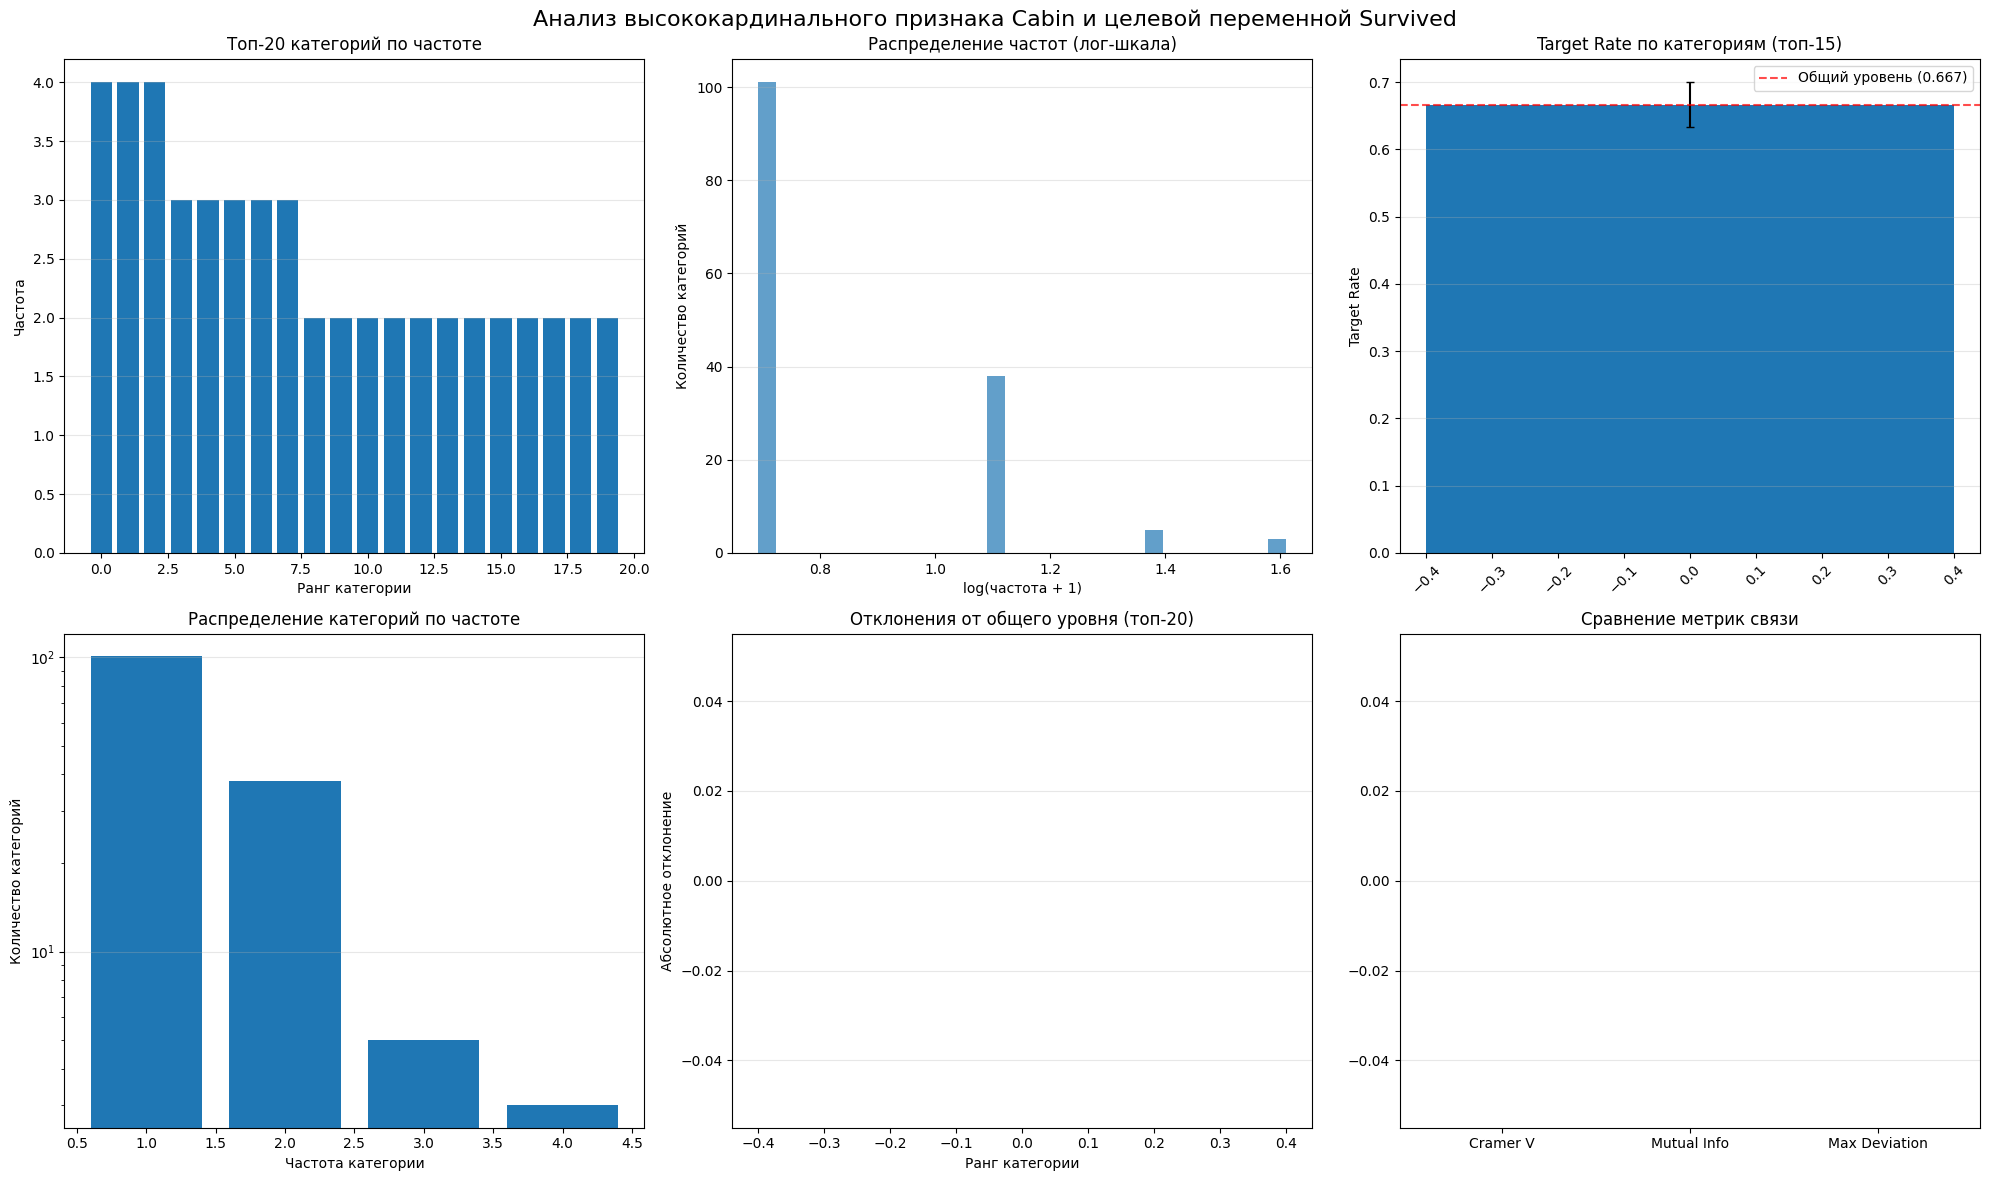


🔍 ДИАГНОСТИКА ВЫСОКОЙ КАРДИНАЛЬНОСТИ:

💡 РЕКОМЕНДАЦИИ ПО КОДИРОВАНИЮ:
   ❌ НИЗКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

🎨 РЕКОМЕНДАЦИИ ПО РАБОТЕ С ПАТТЕРНАМИ:

🤖 РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
   • Деревья решений с min_samples_leaf > 1
   • CatBoost (хорошо работает с категориальными)
   • Embedding слои в нейросетях
   • Избегать линейных моделей без регуляризации

📋 ИТОГОВЫЙ АНАЛИЗ:
❌ ПРИЗНАК НЕ РЕКОМЕНДУЕТСЯ В ТЕКУЩЕМ ВИДЕ
   • Рассмотреть удаление или радикальное преобразование

🚨 ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ:
   • ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (77.1%)
   • ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
   • МНОГО РЕДКИХ КАТЕГОРИЙ (147/147)

🛠️  СПИСОК РЕКОМЕНДАЦИЙ:
   1. • Создать отдельную категорию для пропусков
   2. • Обязательно применить регуляризацию в моделях
   3. • Рассмотреть частотное кодирование
   4. • Группировать редкие категории
   5. • Использовать min_samples_leaf в деревьях
   6. • Frequency/Count Encoding
   7. • Рассмотреть исключение признака
   8. • Использовать префиксы как о

{'cardinality': 147,
 'cardinality_ratio': 0.7205882352941176,
 'cardinality_type': 'Очень высокая кардинальность',
 'missing_rate': 0.7710437710437711,
 'chi2_pvalue': 1.0,
 'cramers_v': 0,
 'mutual_info': np.int64(0),
 'max_deviation': np.float64(0.0),
 'is_significant': False,
 'rare_categories_count': 147,
 'patterns_extracted': ['prefixes', 'numeric_ranges', 'alpha_parts'],
 'top_categories': {'RARE_CATEGORIES': 204},
 'target_encoding_potential': np.float64(0.0),
 'recommendations': ['• Создать отдельную категорию для пропусков',
  '• Обязательно применить регуляризацию в моделях',
  '• Рассмотреть частотное кодирование',
  '• Группировать редкие категории',
  '• Использовать min_samples_leaf в деревьях',
  '• Frequency/Count Encoding',
  '• Рассмотреть исключение признака',
  '• Использовать префиксы как отдельный признак',
  '• Извлечь числовые части и использовать биннинг',
  '• Создать признаки на основе буквенных частей'],
 'issues_found': ['ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (77.1%)',


In [18]:
analyze_high_cardinality_categorical(df, 'Cabin', 'Survived')

### Анализ на дисбаланс классов

Analyzing Feature: 'SibSp'
Data Type: int64
Number of Unique Values: 7
Number of Missing Values: 0 (0.00%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: MODERATELY IMBALANCED (Degree: 0.523)
------------------------------------------------------------
Feature treated as LOW-CARDINALITY.

       Count Proportion
SibSp                  
0        608     68.24%
1        209     23.46%
2         28      3.14%
4         18      2.02%
3         16      1.80%
8          7      0.79%
5          5      0.56%

[!] Categories with proportion < 10%:
  - 2: 3.14%
  - 4: 2.02%
  - 3: 1.80%
  - 8: 0.79%
  - 5: 0.56%


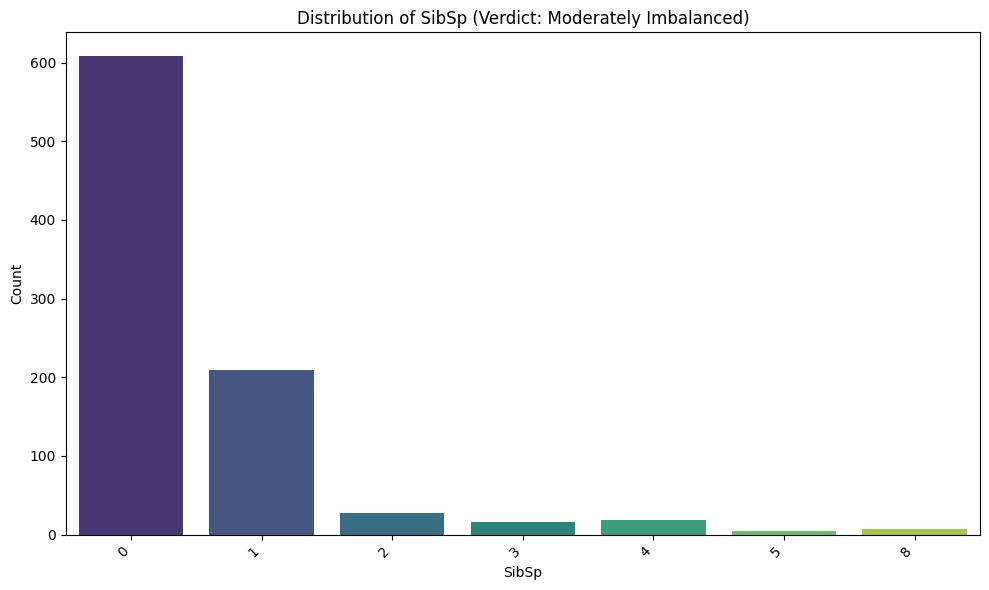

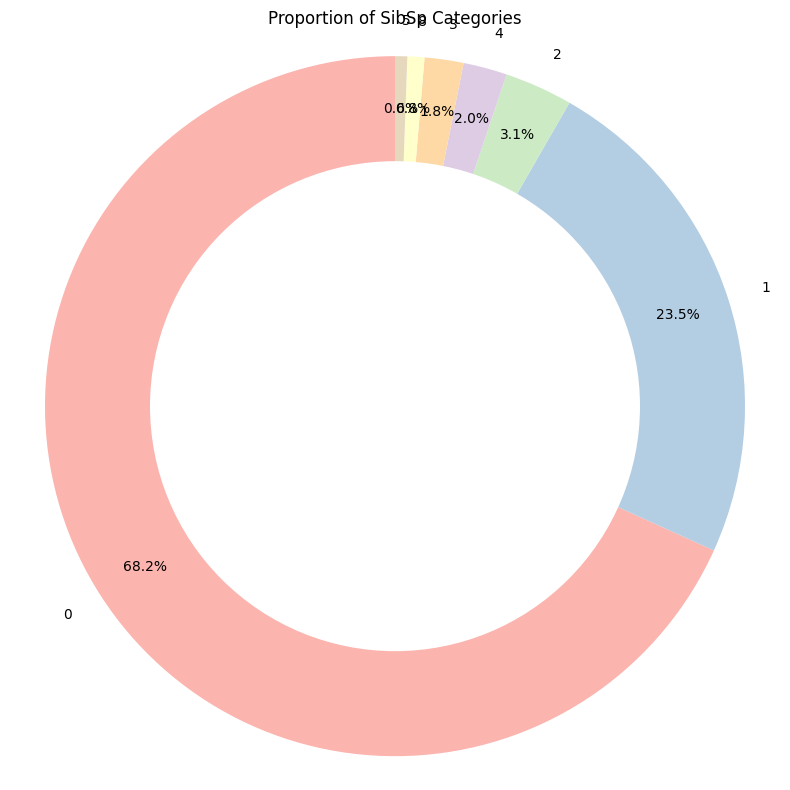

{'column_name': 'SibSp',
 'dtype': 'int64',
 'n_unique': 7,
 'n_missing': np.int64(0),
 'imbalance_info': {'degree': np.float64(0.5231956013756748),
  'verdict': 'Moderately Imbalanced',
  'under_represented_categories': [2, 4, 3, 8, 5]},
 'type': 'low_cardinality'}

In [19]:
detect_categorical_imbalance(df, 'SibSp')

Analyzing Feature: 'Parch'
Data Type: int64
Number of Unique Values: 7
Number of Missing Values: 0 (0.00%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: MODERATELY IMBALANCED (Degree: 0.598)
------------------------------------------------------------
Feature treated as LOW-CARDINALITY.

       Count Proportion
Parch                  
0        678     76.09%
1        118     13.24%
2         80      8.98%
5          5      0.56%
3          5      0.56%
4          4      0.45%
6          1      0.11%

[!] Categories with proportion < 10%:
  - 2: 8.98%
  - 5: 0.56%
  - 3: 0.56%
  - 4: 0.45%
  - 6: 0.11%


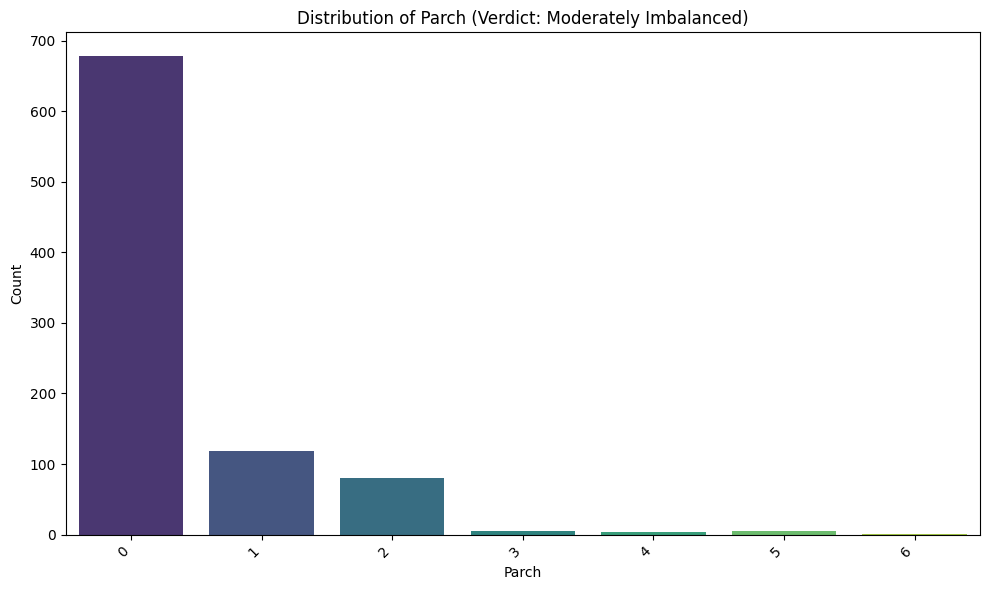

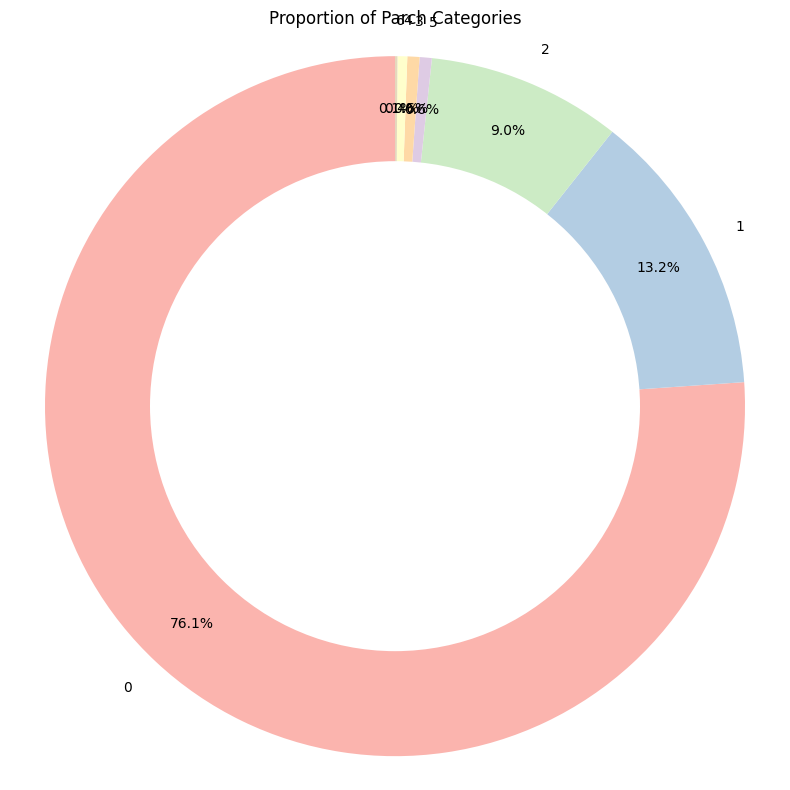

{'column_name': 'Parch',
 'dtype': 'int64',
 'n_unique': 7,
 'n_missing': np.int64(0),
 'imbalance_info': {'degree': np.float64(0.5980781162310977),
  'verdict': 'Moderately Imbalanced',
  'under_represented_categories': [2, 5, 3, 4, 6]},
 'type': 'low_cardinality'}

In [20]:
detect_categorical_imbalance(df, 'Parch')

Analyzing Feature: 'Pclass'
Data Type: int64
Number of Unique Values: 3
Number of Missing Values: 0 (0.00%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: BALANCED (Degree: 0.092)
------------------------------------------------------------
Feature treated as LOW-CARDINALITY.

        Count Proportion
Pclass                  
3         491     55.11%
1         216     24.24%
2         184     20.65%


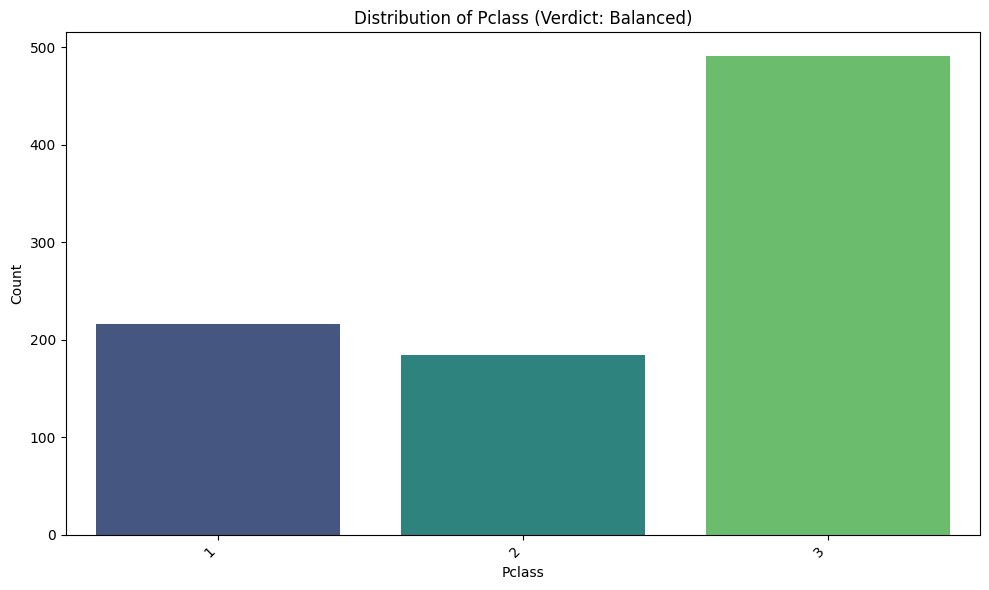

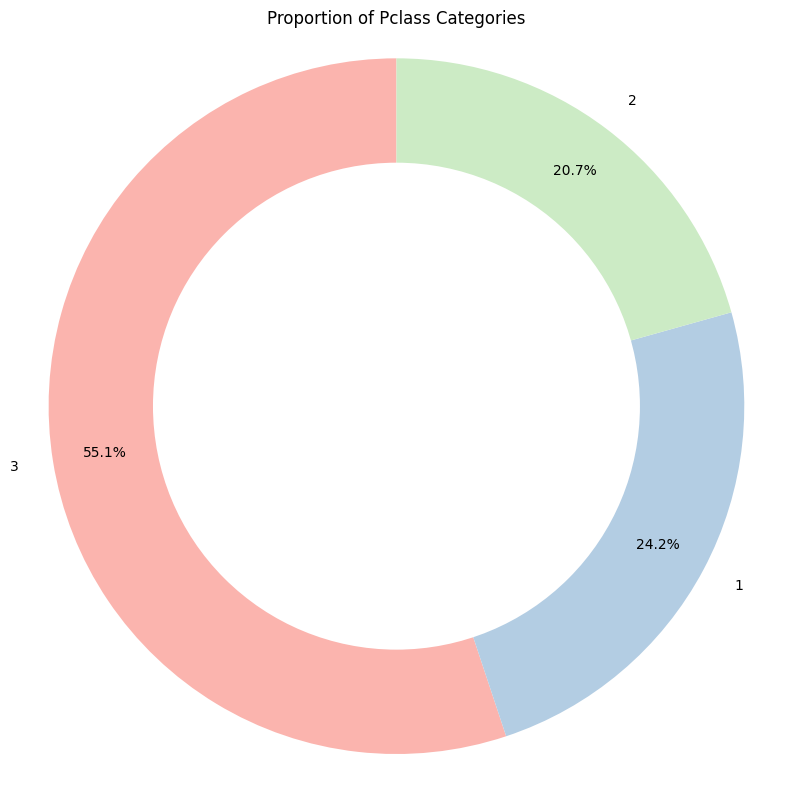

{'column_name': 'Pclass',
 'dtype': 'int64',
 'n_unique': 3,
 'n_missing': np.int64(0),
 'imbalance_info': {'degree': np.float64(0.09188925934257808),
  'verdict': 'Balanced'},
 'type': 'low_cardinality'}

In [21]:
detect_categorical_imbalance(df, 'Pclass')

Analyzing Feature: 'Sex'
Data Type: object
Number of Unique Values: 2
Number of Missing Values: 0 (0.00%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: BALANCED (Degree: 0.064)
------------------------------------------------------------
Feature treated as LOW-CARDINALITY.

        Count Proportion
Sex                     
male      577     64.76%
female    314     35.24%


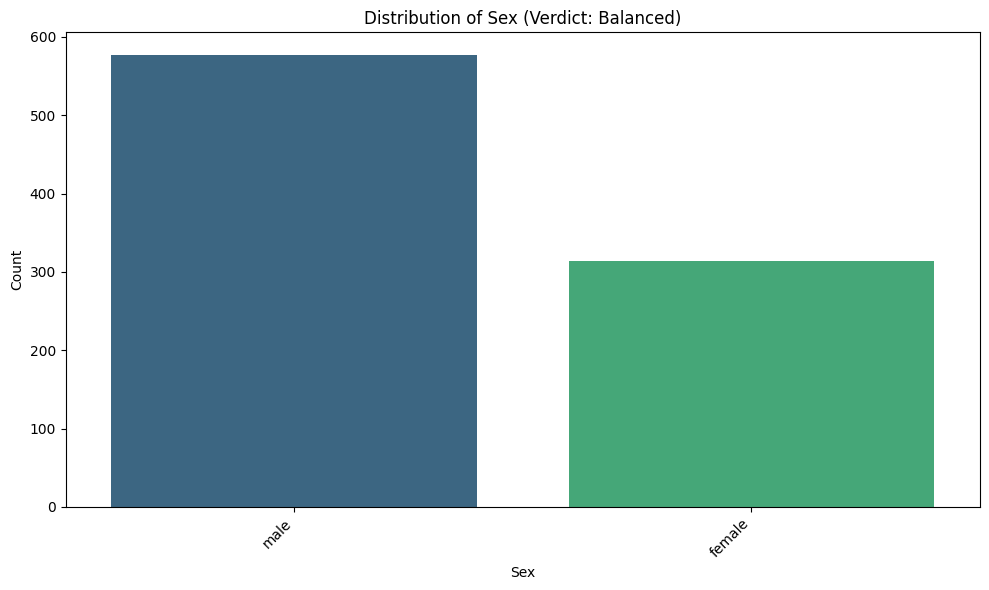

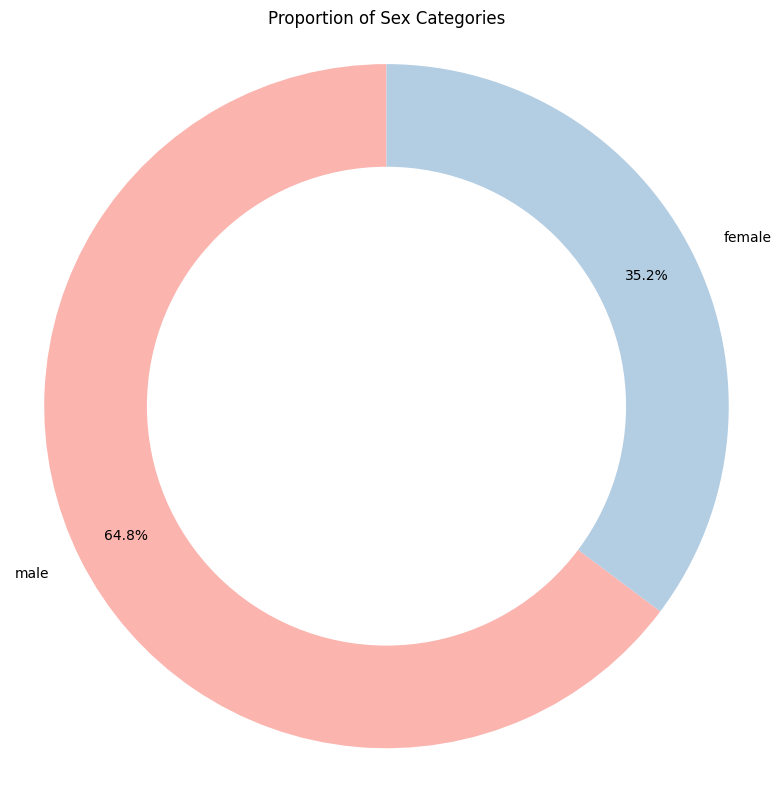

{'column_name': 'Sex',
 'dtype': 'object',
 'n_unique': 2,
 'n_missing': np.int64(0),
 'imbalance_info': {'degree': np.float64(0.06379535675014791),
  'verdict': 'Balanced'},
 'type': 'low_cardinality'}

In [22]:
detect_categorical_imbalance(df, 'Sex')

Analyzing Feature: 'Embarked'
Data Type: object
Number of Unique Values: 3
Number of Missing Values: 2 (0.22%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: SLIGHTLY IMBALANCED (Degree: 0.308)
------------------------------------------------------------
Feature treated as LOW-CARDINALITY.

          Count Proportion
Embarked                  
S           644     72.44%
C           168     18.90%
Q            77      8.66%

[!] Categories with proportion < 10%:
  - Q: 8.66%


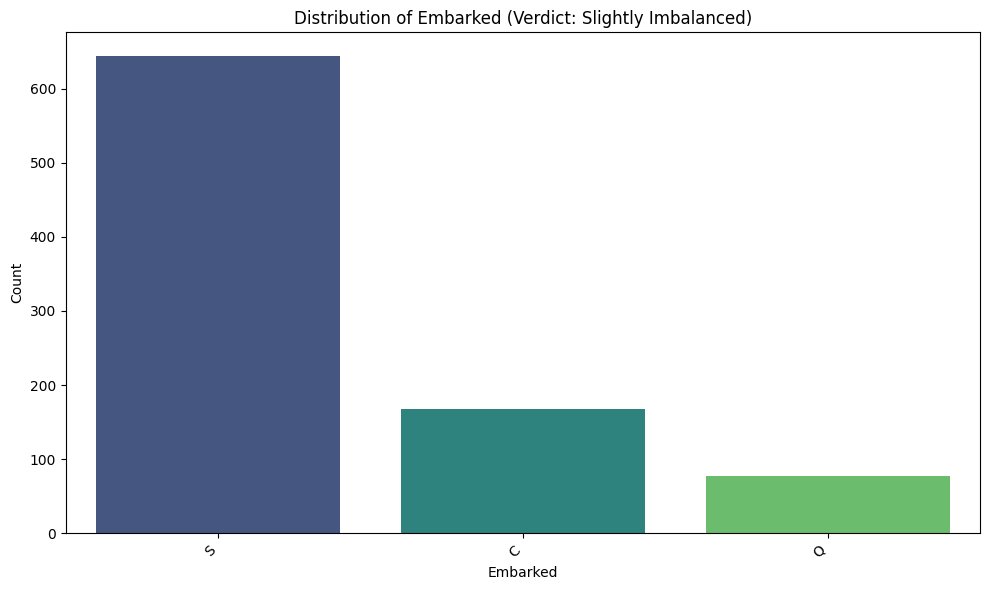

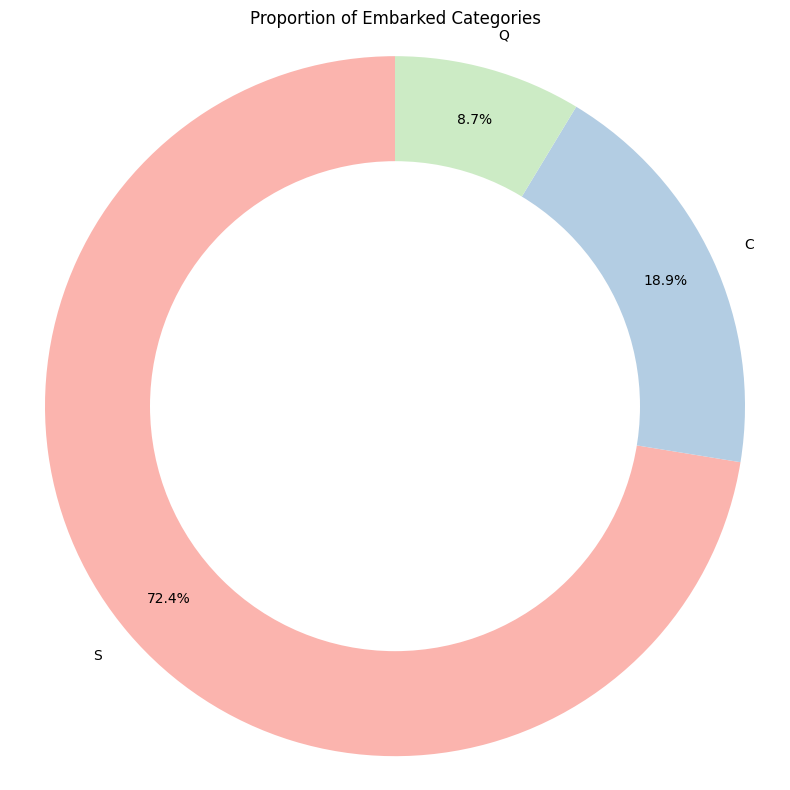

{'column_name': 'Embarked',
 'dtype': 'object',
 'n_unique': 3,
 'n_missing': np.int64(2),
 'imbalance_info': {'degree': np.float64(0.30795249135160163),
  'verdict': 'Slightly Imbalanced',
  'under_represented_categories': ['Q']},
 'type': 'low_cardinality'}

In [23]:
detect_categorical_imbalance(df, 'Embarked')

Analyzing Feature: 'Ticket'
Data Type: object
Number of Unique Values: 681
Number of Missing Values: 0 (0.00%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: BALANCED (Degree: 0.019)
------------------------------------------------------------
Feature treated as HIGH-CARDINALITY (Unique values > 25).

--- Top 15 Most Frequent Values ---
Ticket
347082          7
1601            7
CA. 2343        7
3101295         6
CA 2144         6
347088          6
382652          5
S.O.C. 14879    5
113781          4
347077          4
PC 17757        4
19950           4
349909          4
W./C. 6608      4
113760          4
Name: count, dtype: int64

--- Bottom 15 Least Frequent Values ---
Ticket
345777              1
349248              1
695                 1
345765              1
2667                1
349212              1
349217              1
349257              1
7552                1
C.A./SOTON 34068    1
SOTON/OQ 392076     1
211536              1
112053   

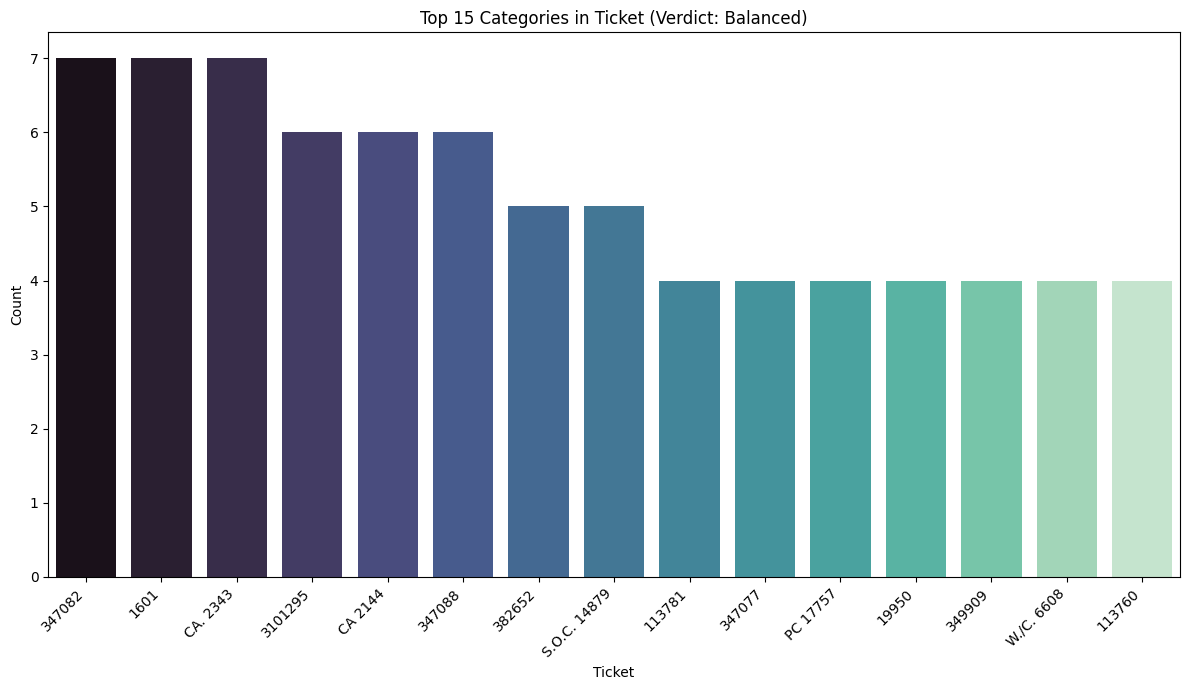

{'column_name': 'Ticket',
 'dtype': 'object',
 'n_unique': 681,
 'n_missing': np.int64(0),
 'imbalance_info': {'degree': np.float64(0.0189671573585537),
  'verdict': 'Balanced'},
 'type': 'high_cardinality',
 'top_n_coverage': {'n': 15,
  'coverage_ratio': np.float64(0.08641975308641978)}}

In [24]:
detect_categorical_imbalance(df, 'Ticket')

Analyzing Feature: 'Cabin'
Data Type: object
Number of Unique Values: 147
Number of Missing Values: 687 (77.10%)
------------------------------------------------------------
[!] IMBALANCE VERDICT: BALANCED (Degree: 0.019)
------------------------------------------------------------
Feature treated as HIGH-CARDINALITY (Unique values > 25).

--- Top 15 Most Frequent Values ---
Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
E101           3
C22 C26        3
F33            3
C83            2
C123           2
B28            2
D26            2
B58 B60        2
E33            2
D33            2
Name: count, dtype: int64

--- Bottom 15 Least Frequent Values ---
Cabin
F38        1
D6         1
B3         1
B82 B84    1
A36        1
B102       1
B69        1
E49        1
C47        1
D28        1
E17        1
A24        1
C50        1
B42        1
C148       1
Name: count, dtype: int64

--- Concentration Analysis ---
[*] The top 15 categories account f

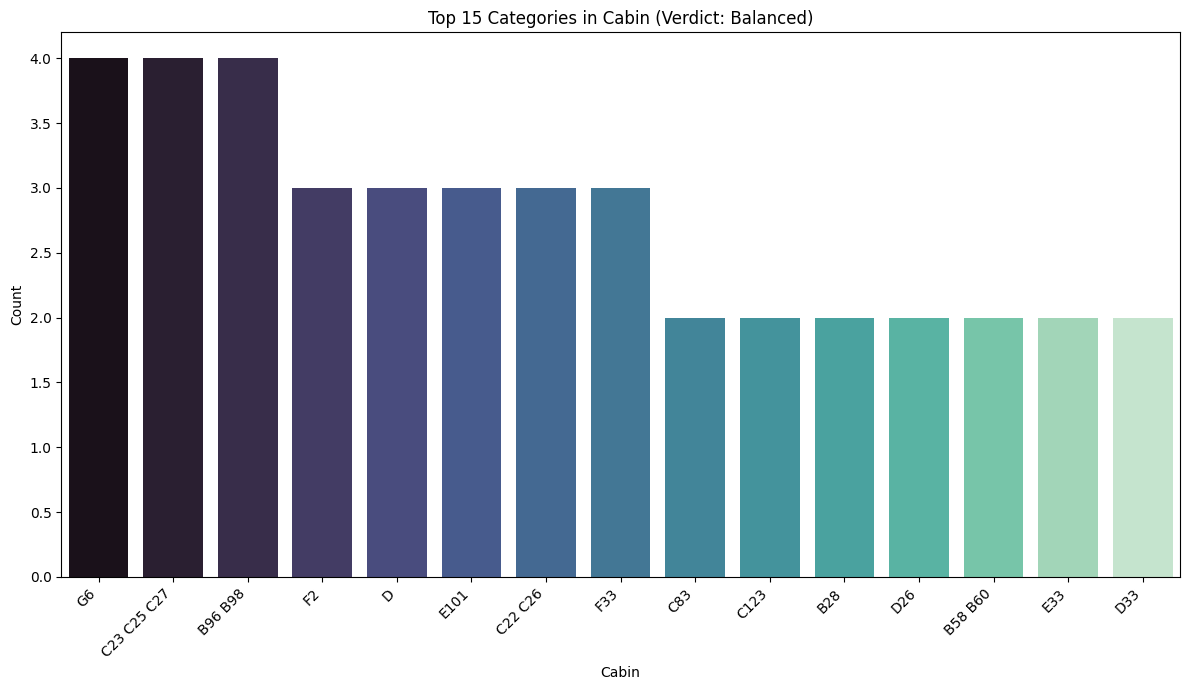

{'column_name': 'Cabin',
 'dtype': 'object',
 'n_unique': 147,
 'n_missing': np.int64(687),
 'imbalance_info': {'degree': np.float64(0.018609797116597937),
  'verdict': 'Balanced'},
 'type': 'high_cardinality',
 'top_n_coverage': {'n': 15, 'coverage_ratio': np.float64(0.2009803921568627)}}

In [25]:
detect_categorical_imbalance(df, 'Cabin')

## Анализ взаимосвязей между признаками (Мультивариантный анализ)

МУЛЬТИВАРИАНТНЫЙ EDA АНАЛИЗ (УЛУЧШЕННАЯ ВЕРСИЯ)
⚠️  Признак 'Cabin' исключен: слишком много уникальных значений (147)
⚠️  Признак 'Ticket' исключен: слишком много уникальных значений (681)
📊 Обнаружено 4 числовых и 3 категориальных признаков
🎯 Целевая переменная: Survived
📈 Числовые признаки: ['SibSp', 'Parch', 'Fare', 'Age']
📋 Категориальные признаки: ['Pclass', 'Sex', 'Embarked']

🔗 АНАЛИЗ ВЗАИМОСВЯЗЕЙ МЕЖДУ ВСЕМИ ПРИЗНАКАМИ

    Корреляционная матрица — это таблица, которая показывает коэффициенты корреляции между парами признаков в вашем наборе данных. Коэффициент корреляции варьируется от -1 до 1:

    1: Сильная положительная линейная связь (если один признак растёт, другой тоже растёт).
    -1: Сильная отрицательная линейная связь (если один признак растёт, другой уменьшается).
    0: Линейной связи нет.

    Высокие значения (близкие к 1 или -1): Признаки сильно связаны. Это может указывать на:

    Мультиколлинеарность: Два признака содержат похожую информацию. Например, в дан

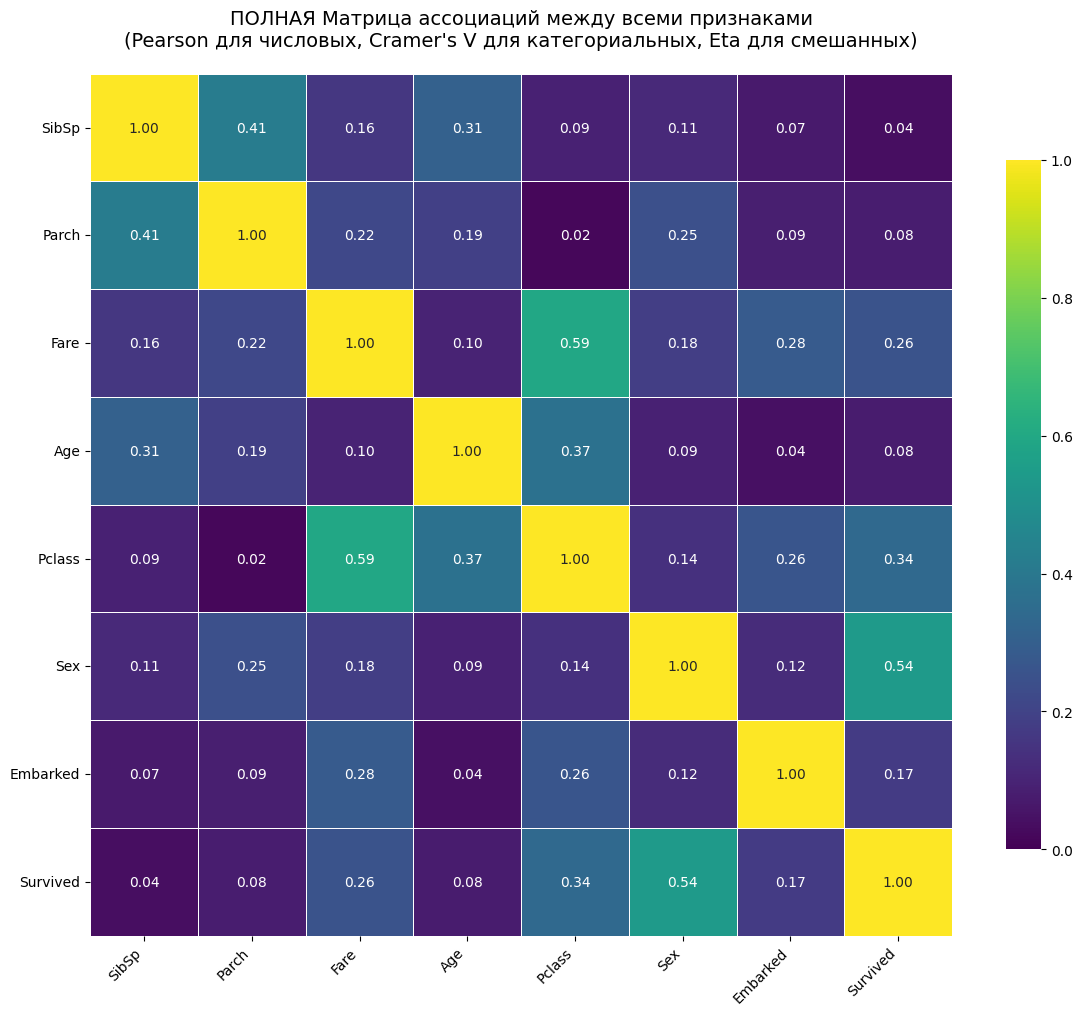


📊 КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ


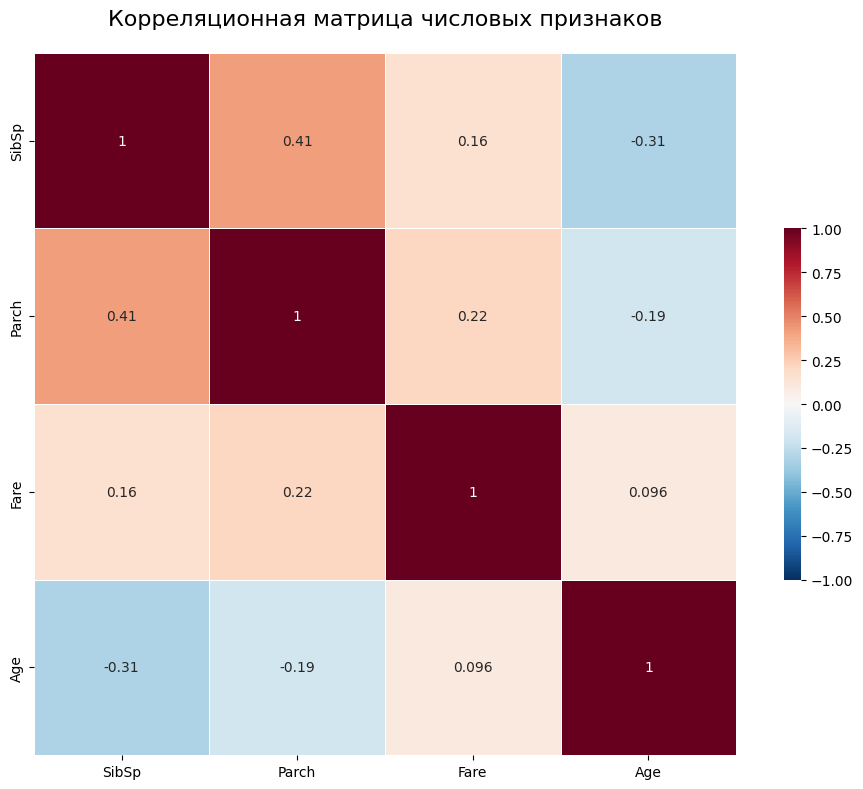

⚠️  Сильные корреляции между числовыми признаками:
   • SibSp ↔ Parch: r = 0.415
   • SibSp ↔ Age: r = -0.308

🕳️  АНАЛИЗ ПРОПУСКОВ И РЕКОМЕНДАЦИИ
Пропуски в данных:
   • Age: 177 (19.9%)
     💡 Для заполнения можно использовать: Pclass (связь: Eta = 0.373)
   • Embarked: 2 (0.2%)
     💡 Для заполнения можно использовать: Fare (связь: Eta = 0.282)

💡 ИТОГОВЫЕ РЕКОМЕНДАЦИИ
1. Проанализируйте 6 сильных связей между признаками
2. Используйте обнаруженные связи для заполнения пропусков

📋 ИНТЕРПРЕТАЦИЯ МЕТРИК:
   • Pearson: Линейная корреляция (-1 до 1, 0 = нет связи)
   • Cramer's V: Связь между категориями (0 до 1, 0 = независимы)
   • Eta: Связь числовое-категориальное (0 до 1, 0 = нет связи)
   • Порог сильной связи: 0.3

✅ АНАЛИЗ ЗАВЕРШЕН


{'association_matrix':              SibSp     Parch      Fare       Age    Pclass       Sex  \
 SibSp     1.000000  0.414838  0.159651  0.308247  0.092652  0.114631   
 Parch     0.414838  1.000000  0.216225  0.189119  0.018653  0.245489   
 Fare      0.159651  0.216225  1.000000  0.096067  0.594217  0.182333   
 Age       0.308247  0.189119  0.096067  1.000000  0.372971  0.093254   
 Pclass    0.092652  0.018653  0.594217  0.372971  1.000000  0.138013   
 Sex       0.114631  0.245489  0.182333  0.093254  0.138013  1.000000   
 Embarked  0.070046  0.085037  0.281550  0.042340  0.263821  0.122569   
 Survived  0.035322  0.081629  0.257307  0.077221  0.339817  0.540936   
 
           Embarked  Survived  
 SibSp     0.070046  0.035322  
 Parch     0.085037  0.081629  
 Fare      0.281550  0.257307  
 Age       0.042340  0.077221  
 Pclass    0.263821  0.339817  
 Sex       0.122569  0.540936  
 Embarked  1.000000  0.172617  
 Survived  0.172617  1.000000  ,
 'association_details': [{'fea

In [26]:
multivariate_eda_analysis(df, target_column='Survived', numerical_features=['SibSp','Parch','Fare','Age'], categorical_features=['Pclass','Sex','Embarked','Cabin','Ticket'])

#### Анализ значимых связей

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Pclass' ↔ 'Fare'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Уникальных значений в 'Pclass': 3
   • Уникальных значений в 'Fare': 248
   • Тип 'Pclass': categorical
   • Тип 'Fare': numerical

📊 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ (Pclass) ↔ ЧИСЛОВАЯ (Fare)
--------------------------------------------------
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА ПО ГРУППАМ:
        count    mean     std  median  min      max
Pclass                                             
1         216  84.155  78.380  60.287  0.0  512.329
2         184  20.662  13.417  14.250  0.0   73.500
3         491  13.676  11.778   8.050  0.0   69.550

📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
   • F-статистика: 242.3442
   • p-value: 0.000000
   • Eta-squared: 0.3531
   • Различия между группами: значимые
   • Размер эффекта: большой

📋 POST-HOC ТЕСТ (Tukey HSD):
   • 3 vs 1: p = 0.0000 (значимо)
   • 3 vs 2: p = 0.0000 (значимо)
   • 1 vs 2: p = 0.1080 (нез

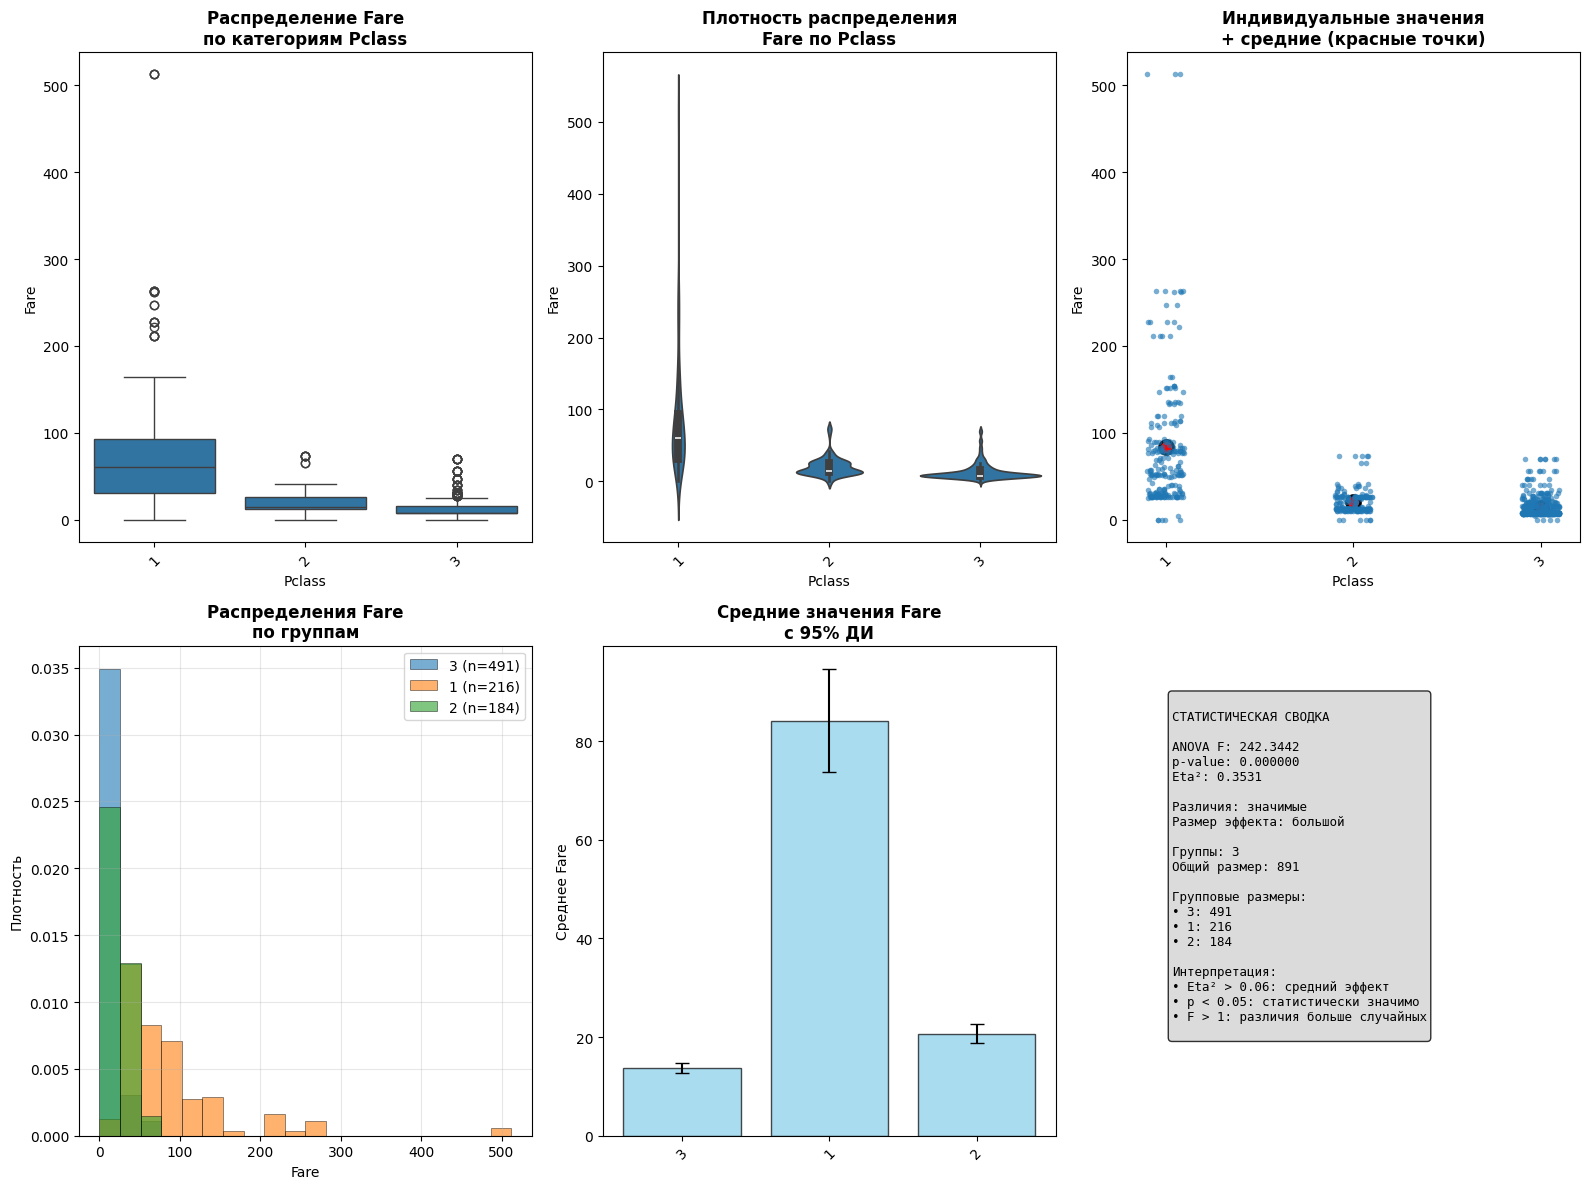


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'ANOVA',
 'f_statistic': np.float64(242.34415651744814),
 'p_value': np.float64(1.0313763209141171e-84),
 'eta_squared': np.float64(0.35309422279795755),
 'significant': np.True_,
 'group_stats':         count       mean        std   median  min       max
 Pclass                                                     
 1         216  84.154687  78.380373  60.2875  0.0  512.3292
 2         184  20.662183  13.417399  14.2500  0.0   73.5000
 3         491  13.675550  11.778142   8.0500  0.0   69.5500,
 'n_groups': 3}

In [27]:
analyze_variable_relationship(df, 'Pclass', 'Fare')

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Age' ↔ 'Pclass'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 714
   • Доля пропусков: 19.87%
   • Уникальных значений в 'Age': 88
   • Уникальных значений в 'Pclass': 3
   • Тип 'Age': numerical
   • Тип 'Pclass': categorical

📊 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ (Pclass) ↔ ЧИСЛОВАЯ (Age)
--------------------------------------------------
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА ПО ГРУППАМ:
        count    mean     std  median   min   max
Pclass                                           
1         186  38.233  14.803    37.0  0.92  80.0
2         173  29.878  14.001    29.0  0.67  70.0
3         355  25.141  12.495    24.0  0.42  74.0

📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
   • F-статистика: 57.4435
   • p-value: 0.000000
   • Eta-squared: 0.1391
   • Различия между группами: значимые
   • Размер эффекта: средний

📋 POST-HOC ТЕСТ (Tukey HSD):
   • 3 vs 1: p = 0.0000 (значимо)
   • 3 vs 2: p = 0.0000 (значимо)
   • 1 vs 2: p = 0.0005 (значимо)


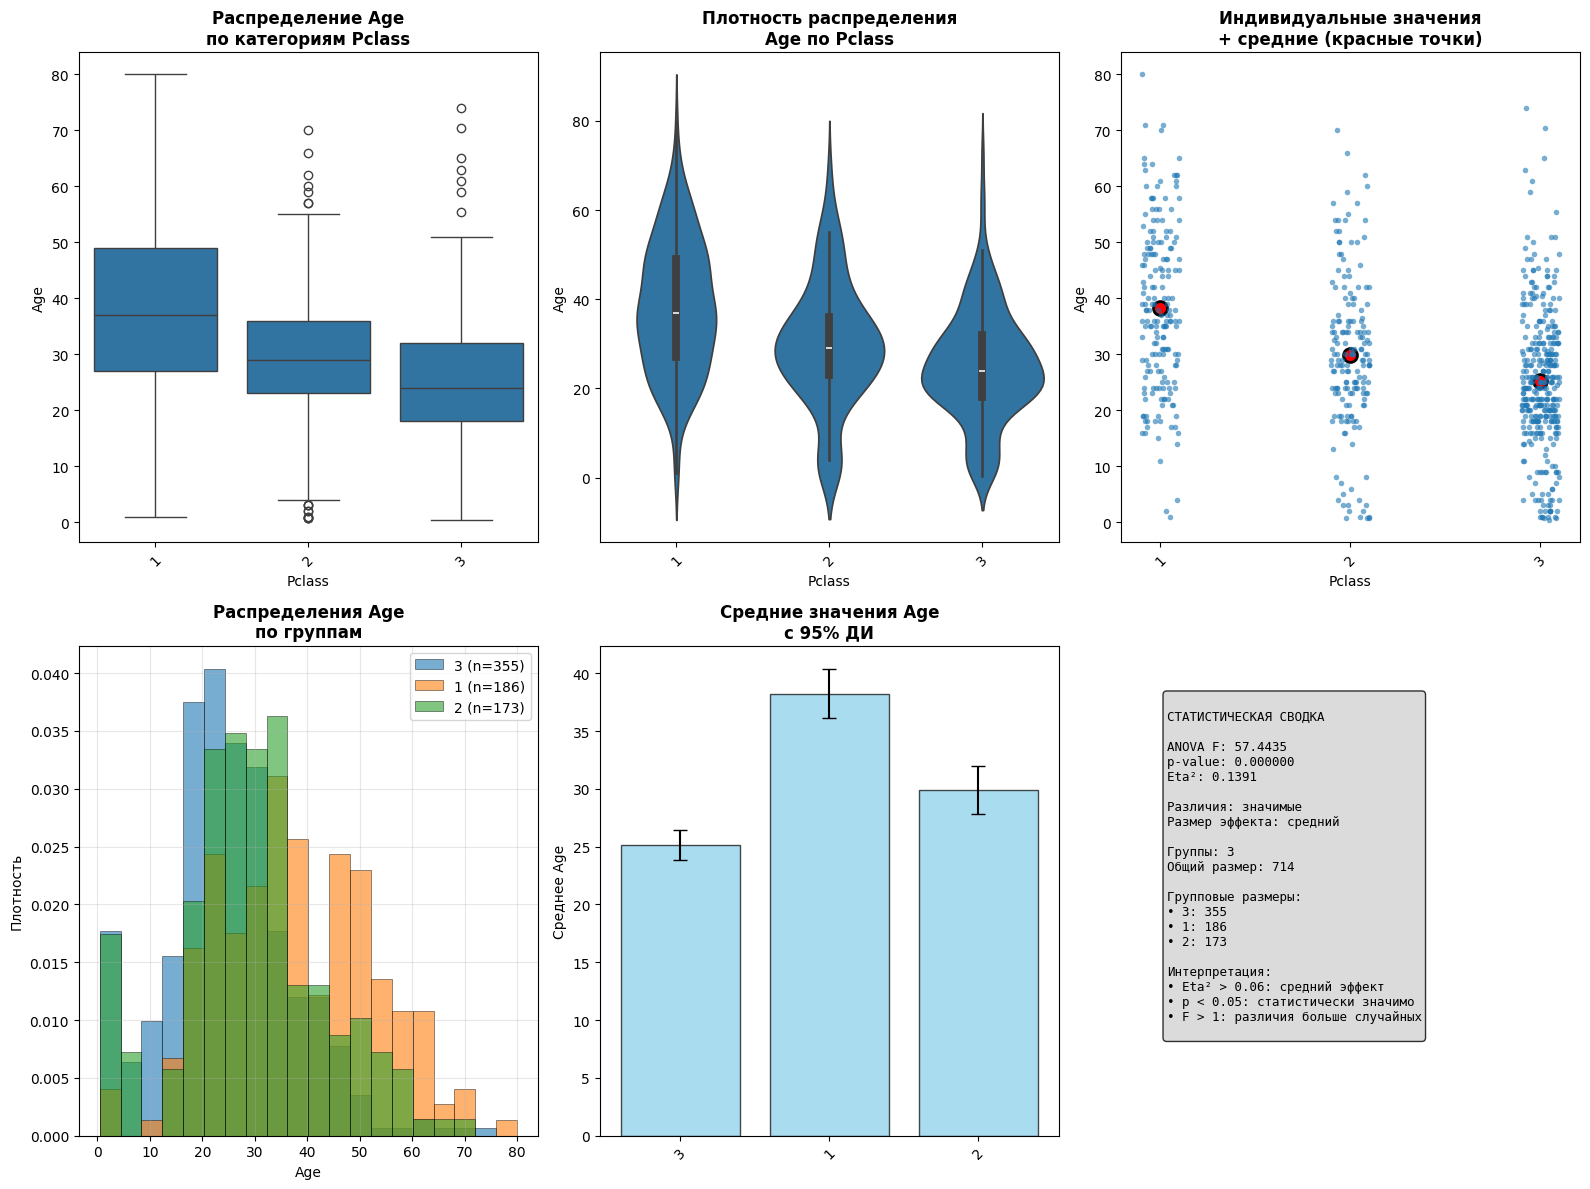


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'ANOVA',
 'f_statistic': np.float64(57.443484340676214),
 'p_value': np.float64(7.487984171959904e-24),
 'eta_squared': np.float64(0.13910737551021785),
 'significant': np.True_,
 'group_stats':         count       mean        std  median   min   max
 Pclass                                                 
 1         186  38.233441  14.802856    37.0  0.92  80.0
 2         173  29.877630  14.001077    29.0  0.67  70.0
 3         355  25.140620  12.495398    24.0  0.42  74.0,
 'n_groups': 3}

In [28]:
analyze_variable_relationship(df, 'Age', 'Pclass')

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Age' ↔ 'SibSp'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 714
   • Доля пропусков: 19.87%
   • Уникальных значений в 'Age': 88
   • Уникальных значений в 'SibSp': 6
   • Тип 'Age': numerical
   • Тип 'SibSp': categorical

📊 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ (SibSp) ↔ ЧИСЛОВАЯ (Age)
--------------------------------------------------
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА ПО ГРУППАМ:
       count    mean     std  median   min   max
SibSp                                           
0        471  31.398  13.648    29.0  0.42  80.0
1        183  30.090  14.645    30.0  0.67  70.0
2         25  22.620  14.679    23.0  0.75  53.0
3         12  13.917  11.317     9.5  2.00  33.0
4         18   7.056   4.881     6.5  1.00  17.0
5          5  10.200   5.805    11.0  1.00  16.0

📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
   • F-статистика: 17.7492
   • p-value: 0.000000
   • Eta-squared: 0.1114
   • Различия между группами: значимые
   • Размер эффекта: средний

📋 

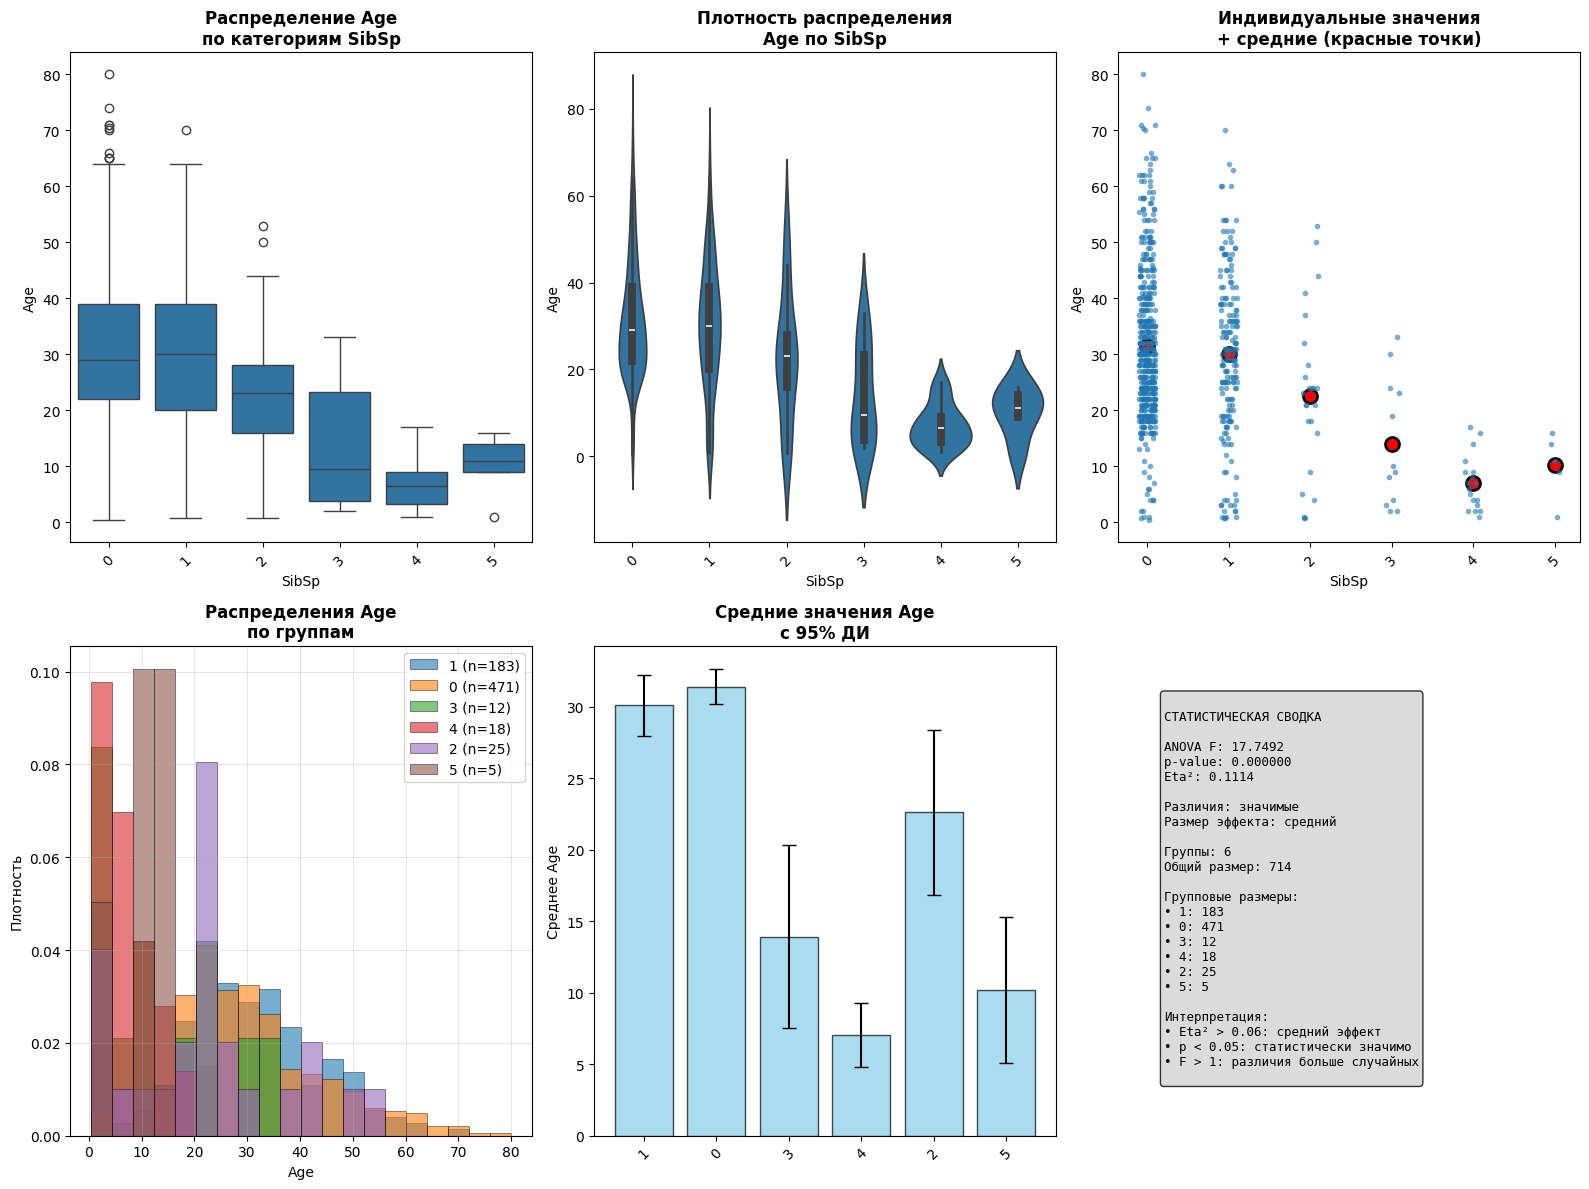


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'ANOVA',
 'f_statistic': np.float64(17.749235384605633),
 'p_value': np.float64(1.3535110302292563e-16),
 'eta_squared': np.float64(0.11138575809144015),
 'significant': np.True_,
 'group_stats':        count       mean        std  median   min   max
 SibSp                                                 
 0        471  31.397558  13.647767    29.0  0.42  80.0
 1        183  30.089727  14.645033    30.0  0.67  70.0
 2         25  22.620000  14.679230    23.0  0.75  53.0
 3         12  13.916667  11.317391     9.5  2.00  33.0
 4         18   7.055556   4.880601     6.5  1.00  17.0
 5          5  10.200000   5.805170    11.0  1.00  16.0,
 'n_groups': 6}

In [29]:
analyze_variable_relationship(df, 'Age', 'SibSp')

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Parch' ↔ 'SibSp'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Уникальных значений в 'Parch': 7
   • Уникальных значений в 'SibSp': 7
   • Тип 'Parch': categorical
   • Тип 'SibSp': categorical

📋 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ ↔ КАТЕГОРИАЛЬНАЯ
--------------------------------------------------
📊 Таблица сопряженности:
SibSp    0    1   2   3   4  5  8  All
Parch                                 
0      537  123  16   2   0  0  0  678
1       38   57   7   7   9  0  0  118
2       29   19   4   7   9  5  7   80
3        1    3   1   0   0  0  0    5
4        1    3   0   0   0  0  0    4
5        2    3   0   0   0  0  0    5
6        0    1   0   0   0  0  0    1
All    608  209  28  16  18  5  7  891

📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
   • Chi-square статистика: 341.6820
   • p-value: 0.000000
   • Степени свободы: 36
   • Cramer's V: 0.2528
   • Связь: значимая (α = 0.05)
   • Сила связи: слаба

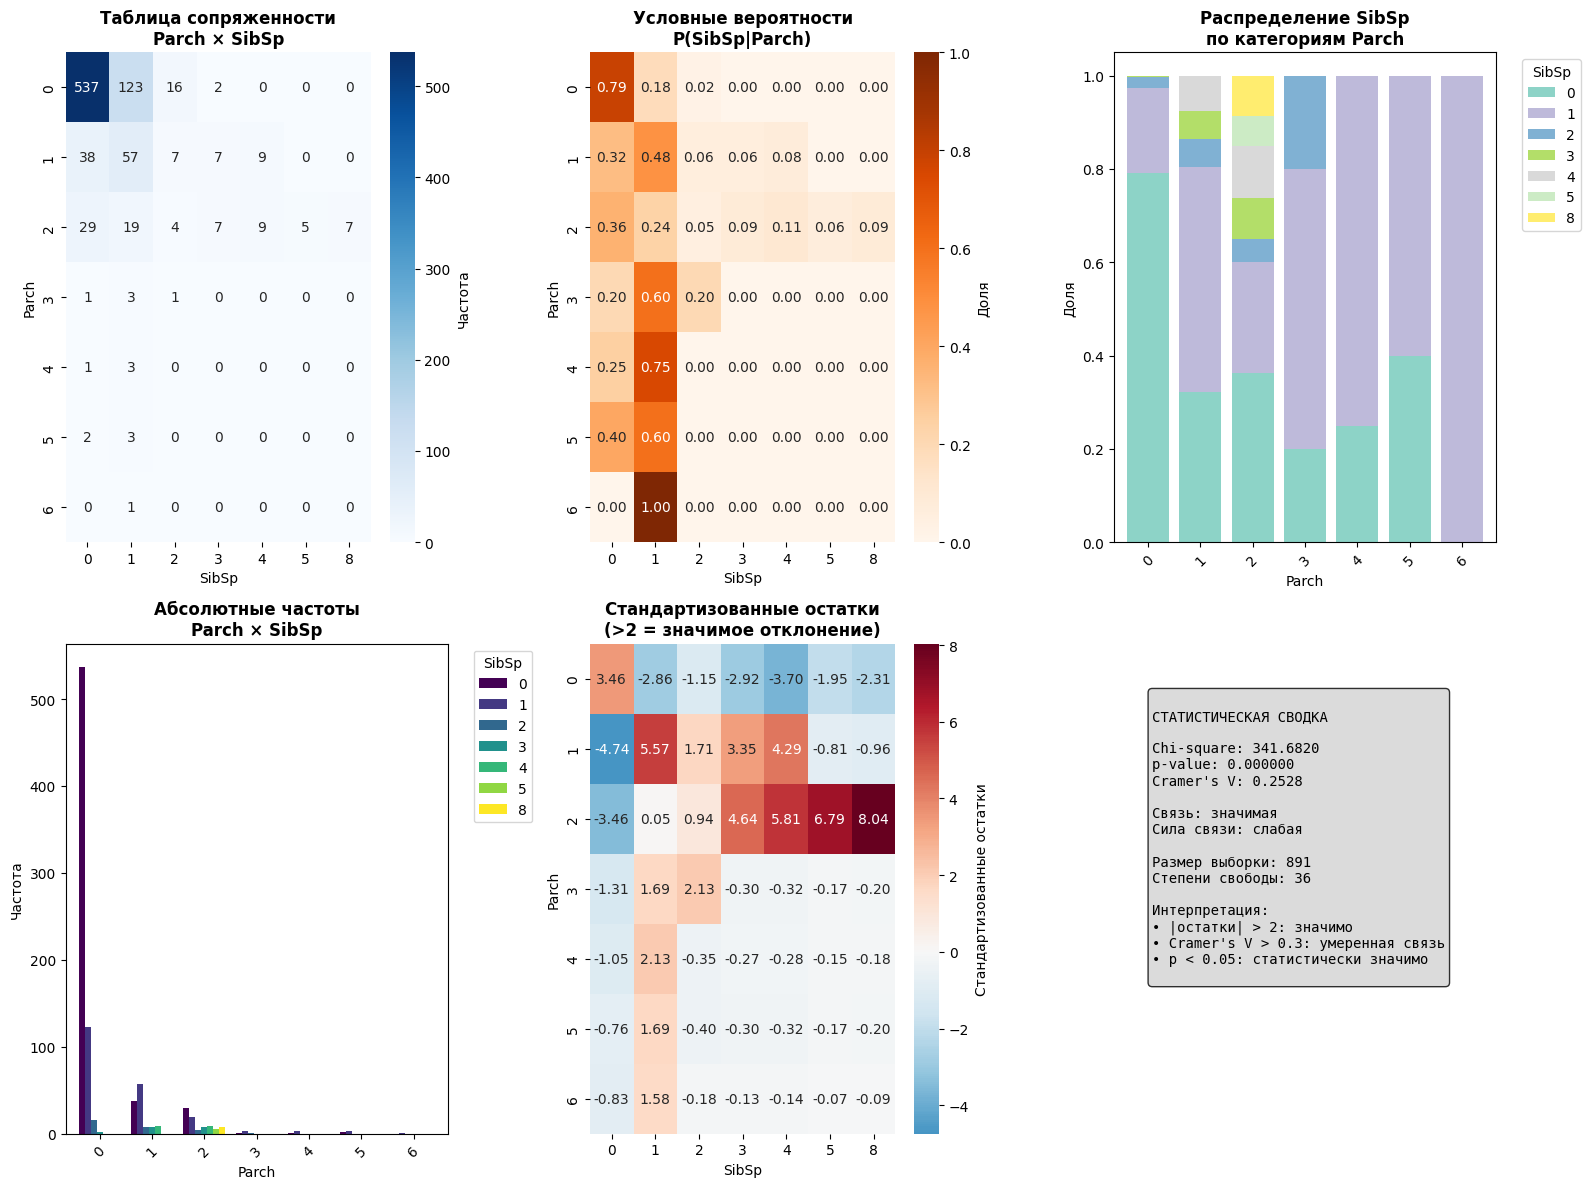


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'Chi-square',
 'statistic': np.float64(341.6819870377193),
 'p_value': np.float64(1.7902298345649077e-51),
 'effect_size': np.float64(0.25281134828611734),
 'effect_size_name': 'Cramers_V',
 'significant': np.True_,
 'contingency_table': SibSp    0    1   2  3  4  5  8
 Parch                          
 0      537  123  16  2  0  0  0
 1       38   57   7  7  9  0  0
 2       29   19   4  7  9  5  7
 3        1    3   1  0  0  0  0
 4        1    3   0  0  0  0  0
 5        2    3   0  0  0  0  0
 6        0    1   0  0  0  0  0,
 'residuals': SibSp         0         1         2         3         4         5         8
 Parch                                                                      
 0      3.456484 -2.857590 -1.149595 -2.916097 -3.700942 -1.950568 -2.307943
 1     -4.738568  5.573183  1.709437  3.353124  4.285167 -0.813743 -0.962833
 2     -3.463524  0.054149  0.937185  4.641679  5.808176  6.792381  8.036853
 3     -1.305752  1.687164  2.126361 -0.299644 -0.317

In [30]:
analyze_variable_relationship(df, 'Parch', 'SibSp')

# Выводы о проблемах

#### Fare

Признак статистически значимо связан с целевой переменной

- ВОЗМОЖНА НЕЛИНЕЙНАЯ СВЯЗЬ
- ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ
- МНОГО ВЫБРОСОВ (13.0%)
- Рассмотреть полиномиальные признаки, биннинг или нелинейные модели
- Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы

#### Age

Признак показывает слабую, но заметную предсказательную способность

- ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (19.9%)
- ПРОПУСКИ НЕ СЛУЧАЙНЫ (связаны с целевой переменной)
- ДАННЫЕ НЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ
- Рассмотреть методы заполнения пропусков или анализ механизма пропусков
- Пропуски могут нести информацию - рассмотреть индикаторные переменные
- Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы

#### SibSp

Признак показывает хорошую предсказательную способность
Умеренно несбалансированный 

Преобладает нелинейная связь

- Объединить редкие категории в группу 'Другие': [8, 5]
- Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Можно использовать как категориальный (One-Hot)
- Рекомендуются нелинейные модели (деревья, нейросети)

#### Parch

Преобладает нелинейная связь
Умеренно несбалансированный  

- Объединить редкие категории в группу 'Другие': [5, 3, 4, 6]
- Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать как категориальный (One-Hot)

#### Pclass

Признак показывает хорошую предсказательную способность

Преобладает нелинейная связь

- Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Использование дерева решений для извлечения правил
- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать как категориальный (One-Hot)

#### Sex

Признак показывает хорошую предсказательную способность

Преобладает нелинейная связь

- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать One-Hot Encoding

#### Embarked

Преобладает нелинейная связь
Слабо несбалансированный 

Заменить пропуски средним

Рассмотреть различные методы кодирования:
 - One-Hot Encoding для независимых категорий
 - Target Encoding для категорий с разным влиянием
 - Binary Encoding для категорий с естественным порядком
 - Рекомендуются нелинейные модели (деревья, нейросети)
 - Можно использовать One-Hot Encoding

#### Ticket

ВЫСОКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

- ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
- МНОГО РЕДКИХ КАТЕГОРИЙ (673/681)
- РАЗРЕЖЕННАЯ ТАБЛИЦА СОПРЯЖЕННОСТИ (88.9% ячеек < 5)

РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
- Деревья решений с min_samples_leaf > 1
- CatBoost (хорошо работает с категориальными)
- Embedding слои в нейросетях
- Избегать линейных моделей без регуляризации

   1. • Обязательно применить регуляризацию в моделях
   2. • Рассмотреть частотное кодирование
   3. • Группировать редкие категории
   4. • Использовать min_samples_leaf в деревьях
   5. • Использовать точные статистические тесты
   6. • Target Encoding с кросс-валидацией
   7. • Bayesian Target Encoding для стабильности
   8. • Leave-One-Out Encoding
   9. • Использовать префиксы как отдельный признак
   10. • Извлечь числовые части и использовать биннинг
   11. • Создать признаки на основе буквенных частей

#### Cabin

НИЗКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

- ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (77.1%)
- ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
- МНОГО РЕДКИХ КАТЕГОРИЙ (147/147)

РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
- Деревья решений с min_samples_leaf > 1
- CatBoost (хорошо работает с категориальными)
- Embedding слои в нейросетях
- Избегать линейных моделей без регуляризации

- Рассмотреть удаление или радикальное преобразование

   1. • Создать отдельную категорию для пропусков
   2. • Обязательно применить регуляризацию в моделях
   3. • Рассмотреть частотное кодирование
   4. • Группировать редкие категории
   5. • Использовать min_samples_leaf в деревьях
   6. • Frequency/Count Encoding
   7. • Рассмотреть исключение признака
   8. • Использовать префиксы как отдельный признак
   9. • Извлечь числовые части и использовать биннинг
   10. • Создать признаки на основе буквенных частей

## Выводы о решении проблем 

Для пропусков в данных одно из - Удалить строки/столбцы, импутировать средним, медианой, модой или использовать KNN, добавить индикатор пропусков. Выявить закономерности и подставить примерные значения.

Для выбросов - Удалить, преобразовать (например, логарифмическое преобразование), использовать устойчивые модели (деревья решений).

Для масштабирования - Мин-макс масштабирование для нейронок, стандартизация (z-score), робастное масштабирование RobustScaler если есть выбросы. 

Для кодирвания категории - One-hot encoding, label encoding, target encoding.

Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.

В случае если много признаков к примеру изза One Hot - Анализ корреляций, рекурсивное исключение признаков (RFE) + PCA сжатие. Если из них есть какая то переменная которая почти никогда не меняется тогда ее следует удалить.


#### Age

Для масштабирования - Мин-макс масштабирование, стандартизация (z-score), робастное масштабирование. 
Рассмотреть методы заполнения пропусков или анализ механизма пропусков
Пропуски могут нести информацию - рассмотреть индикаторные переменные
Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.
Для пропусков в данных одно из - Удалить строки/столбцы, импутировать средним, медианой, модой или использовать KNN, добавить индикатор пропусков. Выявить закономерности и подставить примерные значения.

#### Fare

Рассмотреть полиномиальные признаки, биннинг или нелинейные модели.
Для масштабирования - Мин-макс масштабирование, стандартизация (z-score), робастное масштабирование. 
Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.
Удалить, преобразовать (например, логарифмическое преобразование), использовать устойчивые модели (деревья решений).

#### SibSp

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.
Для масштабирования - Мин-макс масштабирование, стандартизация (z-score), робастное масштабирование. 
Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.
Объединить редкие категории в группу 'Другие': [8, 5]
Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Можно использовать как категориальный (One-Hot)
- Рекомендуются нелинейные модели (деревья, нейросети)

Для кодирвания категории - One-hot encoding, label encoding, target encoding.
В случае если много признаков к примеру изза One Hot - Анализ корреляций, рекурсивное исключение признаков (RFE) + PCA сжатие. Если из них есть какая то переменная которая почти никогда не меняется тогда ее следует удалить.

Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.


#### Parch

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.

- Объединить редкие категории в группу 'Другие': [5, 3, 4, 6]
- Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать как категориальный (One-Hot)

Для кодирвания категории - One-hot encoding, label encoding, target encoding.
В случае если много признаков к примеру изза One Hot - Анализ корреляций, рекурсивное исключение признаков (RFE) + PCA сжатие. Если из них есть какая то переменная которая почти никогда не меняется тогда ее следует удалить.

Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.

#### Pclass

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.

Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Использование дерева решений для извлечения правил
- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать как категориальный (One-Hot)

Для кодирвания категории - One-hot encoding, label encoding, target encoding.


#### Sex

Преобладает нелинейная связь

- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать One-Hot Encoding

Для кодирвания категории - One-hot encoding, label encoding, target encoding.

#### Embarked

Преобладает нелинейная связь

Заменить пропуски средним

Рассмотреть различные методы кодирования:
 - One-Hot Encoding для независимых категорий
 - Target Encoding для категорий с разным влиянием
 - Binary Encoding для категорий с естественным порядком
 - Рекомендуются нелинейные модели (деревья, нейросети)
 - Можно использовать One-Hot Encoding


#### Ticket

ВЫСОКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

- ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
- МНОГО РЕДКИХ КАТЕГОРИЙ (673/681)
- РАЗРЕЖЕННАЯ ТАБЛИЦА СОПРЯЖЕННОСТИ (88.9% ячеек < 5)

РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
- Деревья решений с min_samples_leaf > 1
- CatBoost (хорошо работает с категориальными)
- Embedding слои в нейросетях
- Избегать линейных моделей без регуляризации

   1. • Обязательно применить регуляризацию в моделях
   2. • Рассмотреть частотное кодирование
   3. • Группировать редкие категории
   4. • Использовать min_samples_leaf в деревьях
   5. • Использовать точные статистические тесты
   6. • Target Encoding с кросс-валидацией
   7. • Bayesian Target Encoding для стабильности
   8. • Leave-One-Out Encoding
   9. • Использовать префиксы как отдельный признак
   10. • Извлечь числовые части и использовать биннинг
   11. • Создать признаки на основе буквенных частей

#### Cabin

НИЗКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

- ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (77.1%)
- ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
- МНОГО РЕДКИХ КАТЕГОРИЙ (147/147)

РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
- Деревья решений с min_samples_leaf > 1
- CatBoost (хорошо работает с категориальными)
- Embedding слои в нейросетях
- Избегать линейных моделей без регуляризации

- Рассмотреть удаление или радикальное преобразование

   1. • Создать отдельную категорию для пропусков
   2. • Обязательно применить регуляризацию в моделях
   3. • Рассмотреть частотное кодирование
   4. • Группировать редкие категории
   5. • Использовать min_samples_leaf в деревьях
   6. • Frequency/Count Encoding
   7. • Рассмотреть исключение признака
   8. • Использовать префиксы как отдельный признак
   9. • Извлечь числовые части и использовать биннинг
   10. • Создать признаки на основе буквенных частей

# PREPROCESSING

Обработка с исправлением ошибок для каждого признака с нормализацией и скалированием

#### Age

Для масштабирования - Мин-макс масштабирование, стандартизация (z-score), робастное масштабирование. 

Рассмотреть методы заполнения пропусков или анализ механизма пропусков
Пропуски могут нести информацию - рассмотреть индикаторные переменные
Для пропусков в данных одно из - Удалить строки/столбцы, импутировать средним, медианой, модой или использовать KNN, добавить индикатор пропусков. Выявить закономерности и подставить примерные значения.

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.

In [31]:
# Если SibSp 0 то медиана Age 29.0 итд:  
# 1  =   30.0 
# 2  =   23.0  
# 3  =   9.5  
# 4  =   6.5 
# 5  =   11.0    

# Если Pclass 1 тогда медиана Age 37.0 итд:
# 2  =   29.0  
# 3  =   24.0  

# 1. Заполнение по группе SibSp
df['Age'] = df.groupby('SibSp')['Age'].transform(lambda x: x.fillna(x.median()))

# 2. Заполнение по группе Pclass (для оставшихся NaN)
df['Age'] = df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# 3. Заполнение оставшихся NaN общей медианой (на случай, если группы были полностью пустыми)
df['Age'].fillna(df['Age'].median(), inplace=True)

In [32]:
df["Age"], f_lambda = stats.boxcox(df["Age"])

In [33]:
object = RobustScaler()
df['Age'] = object.fit_transform(df[['Age']])

#### Fare

Рассмотреть полиномиальные признаки, биннинг или нелинейные модели.
Для масштабирования - робастное масштабирование. 
Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.
Выбросы Удалить, преобразовать (например, логарифмическое преобразование), использовать устойчивые модели (деревья решений).

In [34]:
df["Fare"].min()

np.float64(0.0)

In [35]:
df["Fare"], f_lambda = stats.boxcox(df["Fare"] + 0.000001)

In [36]:
object = RobustScaler()
df['Fare'] = object.fit_transform(df[['Fare']])

#### SibSp

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.

Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.
Объединить редкие категории в группу 'Другие': [8, 5]
Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Можно использовать как категориальный (One-Hot)
- Рекомендуются нелинейные модели (деревья, нейросети)

Для кодирвания категории - One-hot encoding, label encoding, target encoding.
В случае если много признаков к примеру изза One Hot - Анализ корреляций, рекурсивное исключение признаков (RFE) + PCA сжатие. Если из них есть какая то переменная которая почти никогда не меняется тогда ее следует удалить.

Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.
Но SMOTE-NC применяется ко всему датасету . Придется пропустить этот шаг и сделать его в конце.

In [37]:
df = apply_one_hot_encoding(df, 'SibSp')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  SibSp_0      891 non-null    int64  
 12  SibSp_1      891 non-null    int64  
 13  SibSp_2      891 non-null    int64  
 14  SibSp_3      891 non-null    int64  
 15  SibSp_4      891 non-null    int64  
 16  SibSp_5      891 non-null    int64  
 17  SibSp_8      891 non-null    int64  
dtypes: float64(2), int64(11), object(5)
memory usage: 

In [39]:
df['SibSp_5'] = df['SibSp_5'] | df['SibSp_8'] 
df = df.drop(['SibSp_8'], axis=1)

#### Parch

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.

- Объединить редкие категории в группу 'Другие': [5, 3, 4, 6]
- Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать как категориальный (One-Hot)

Для кодирвания категории - One-hot encoding, label encoding, target encoding.
В случае если много признаков к примеру изза One Hot - Анализ корреляций, рекурсивное исключение признаков (RFE) + PCA сжатие. Если из них есть какая то переменная которая почти никогда не меняется тогда ее следует удалить.

Для не сбалансированных классов - Oversampling (например, SMOTE), undersampling, взвешивание классов в моделях.

In [40]:
df = apply_one_hot_encoding(df, 'Parch')

In [41]:
df['Parch_3'] = df['Parch_3'] | df['Parch_4'] | df['Parch_5'] | df['Parch_6'] 
df = df.drop(['Parch_4', 'Parch_5', 'Parch_6'], axis=1) 

#### Pclass

Рассмотреть трансформации (log, sqrt, Box-Cox) или непараметрические методы для нормализации.

Для числового признака рассмотреть:
- Биннинг (разбиение на интервалы)
- Полиномиальные признаки для нелинейности
- Логарифмическое или другое преобразование
- Использование дерева решений для извлечения правил
- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать как категориальный (One-Hot)

Для кодирвания категории - One-hot encoding, label encoding, target encoding.

In [42]:
df = apply_one_hot_encoding(df, 'Pclass')

#### Sex

Преобладает нелинейная связь

- Рекомендуются нелинейные модели (деревья, нейросети)
- Можно использовать One-Hot Encoding

Для кодирвания категории - One-hot encoding, label encoding, target encoding.

In [43]:
df = apply_one_hot_encoding(df, 'Sex')

#### Embarked

Преобладает нелинейная связь

Заменить пропуски средним

Рассмотреть различные методы кодирования:
 - One-Hot Encoding для независимых категорий
 - Target Encoding для категорий с разным влиянием
 - Binary Encoding для категорий с естественным порядком
 - Рекомендуются нелинейные модели (деревья, нейросети)
 - Можно использовать One-Hot Encoding

In [66]:
px.histogram(df,'Embarked')

In [44]:
df['Embarked'] = df['Embarked'].fillna('S')

In [45]:
df = apply_one_hot_encoding(df, 'Embarked')

#### Ticket

ВЫСОКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

- ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
- МНОГО РЕДКИХ КАТЕГОРИЙ (673/681)
- РАЗРЕЖЕННАЯ ТАБЛИЦА СОПРЯЖЕННОСТИ (88.9% ячеек < 5)

РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ:
- Деревья решений с min_samples_leaf > 1
- CatBoost (хорошо работает с категориальными)
- Embedding слои в нейросетях
- Избегать линейных моделей без регуляризации

   1. • Обязательно применить регуляризацию в моделях
   2. • Рассмотреть частотное кодирование
   3. • Группировать редкие категории
   4. • Использовать min_samples_leaf в деревьях
   5. • Использовать точные статистические тесты
   6. • Target Encoding с кросс-валидацией
   7. • Bayesian Target Encoding для стабильности
   8. • Leave-One-Out Encoding
   9. • Использовать префиксы как отдельный признак
   10. • Извлечь числовые части и использовать биннинг
   11. • Создать признаки на основе буквенных частей

In [46]:

import re

def get_ticket_prefix(ticket):
    match = re.match(r'([A-Za-z./]+)', str(ticket))
    return match.group(1).replace('.', '').replace('/', '').strip().upper() if match else 'NO_PREFIX'

df['Ticket_Prefix'] = df['Ticket'].apply(get_ticket_prefix)

# --- 2. Частотное кодирование ---
df['Ticket_Freq'] = df['Ticket'].map(df['Ticket'].value_counts())
df['Ticket_Prefix_Freq'] = df['Ticket_Prefix'].map(df['Ticket_Prefix'].value_counts())

# --- 3. Target Encoding с кросс-валидацией ---
# Создаем копию для кодирования, чтобы не затрагивать исходный df
df_encoded = df.copy()
X = df_encoded[['Ticket', 'Ticket_Prefix']]
y = df_encoded['Survived']

# Инициализируем TargetEncoder (можно настроить smoothing и min_samples_leaf)
encoder = TargetEncoder(cols=['Ticket', 'Ticket_Prefix'], smoothing=1.0, min_samples_leaf=20)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем новые столбцы для закодированных значений
df_encoded['Ticket_TargetEncoded'] = np.nan
df_encoded['Ticket_Prefix_TargetEncoded'] = np.nan

# Применяем Target Encoding внутри циклов кросс-валидации
for train_index, val_index in kf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold = y.iloc[train_index]

    encoder.fit(X_train_fold, y_train_fold)
    df_encoded.loc[val_index, 'Ticket_TargetEncoded'] = encoder.transform(X_val_fold)['Ticket']
    df_encoded.loc[val_index, 'Ticket_Prefix_TargetEncoded'] = encoder.transform(X_val_fold)['Ticket_Prefix']

# Вывод первых нескольких строк с новыми признаками
print(df_encoded[['Ticket', 'Ticket_Prefix', 'Ticket_Freq', 'Ticket_Prefix_Freq',
                  'Ticket_TargetEncoded', 'Ticket_Prefix_TargetEncoded', 'Survived']].head())


             Ticket Ticket_Prefix  Ticket_Freq  Ticket_Prefix_Freq  \
0         A/5 21171             A            1                  28   
1          PC 17599            PC            1                  60   
2  STON/O2. 3101282         STONO            1                  18   
3            113803     NO_PREFIX            2                 661   
4            373450     NO_PREFIX            1                 661   

   Ticket_TargetEncoded  Ticket_Prefix_TargetEncoded  Survived  
0              0.384292                     0.101058         0  
1              0.382889                     0.644444         1  
2              0.384292                     0.384125         1  
3              0.384292                     0.390625         1  
4              0.383427                     0.375465         0  


In [51]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PassengerId                  891 non-null    int64  
 1   Survived                     891 non-null    int64  
 2   Name                         891 non-null    object 
 3   Age                          891 non-null    float64
 4   Ticket                       891 non-null    object 
 5   Fare                         891 non-null    float64
 6   Cabin                        204 non-null    object 
 7   SibSp_0                      891 non-null    int64  
 8   SibSp_1                      891 non-null    int64  
 9   SibSp_2                      891 non-null    int64  
 10  SibSp_3                      891 non-null    int64  
 11  SibSp_4                      891 non-null    int64  
 12  SibSp_5                      891 non-null    int64  
 13  Parch_0             

#### Cabin

НИЗКАЯ ПРЕДСКАЗАТЕЛЬНАЯ СПОСОБНОСТЬ

- ВЫСОКАЯ ДОЛЯ ПРОПУСКОВ (77.1%)
- ОЧЕНЬ ВЫСОКАЯ КАРДИНАЛЬНОСТЬ - возможно переобучение
- МНОГО РЕДКИХ КАТЕГОРИЙ (147/147)

- Рассмотреть радикальное преобразование (я сам его сделаю допустим что я уже заполнил пропуски)

   1. • Создать отдельную категорию для пропусков
   2. • Обязательно применить регуляризацию в моделях
   3. • Рассмотреть частотное кодирование
   4. • Группировать редкие категории
   5. • Использовать min_samples_leaf в деревьях
   6. • Frequency/Count Encoding
   8. • Использовать префиксы как отдельный признак
   9. • Извлечь числовые части и использовать биннинг
   10. • Создать признаки на основе буквенных частей

In [47]:


df_encoded['Cabin_Clean'] = df_encoded['Cabin'].fillna('Missing')
print(f"\nКоличество 'Missing' в 'Cabin_Clean': {df_encoded['Cabin_Clean'].value_counts().get('Missing', 0)}")


df_encoded['Deck'] = df_encoded['Cabin_Clean'].apply(lambda x: x[0] if x != 'Missing' else 'Missing')
print(f"\nУникальные значения 'Deck' (палуб):\n{df_encoded['Deck'].value_counts()}")


deck_counts = df_encoded['Deck'].value_counts()
df_encoded['Deck_Freq'] = df_encoded['Deck'].map(deck_counts)
print("\nПример частотного кодирования 'Deck_Freq':")
print(df_encoded[['Cabin', 'Deck', 'Deck_Freq']].head())

min_freq_ratio = 0.01 
total_passengers = len(df_encoded)
rare_decks = df_encoded['Deck'].value_counts()[df_encoded['Deck'].value_counts() / total_passengers < min_freq_ratio].index

df_encoded['Deck_Grouped'] = df_encoded['Deck'].replace(rare_decks, 'Rare_Deck')


Количество 'Missing' в 'Cabin_Clean': 687

Уникальные значения 'Deck' (палуб):
Deck
Missing    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

Пример частотного кодирования 'Deck_Freq':
  Cabin     Deck  Deck_Freq
0   NaN  Missing        687
1   C85        C         59
2   NaN  Missing        687
3  C123        C         59
4   NaN  Missing        687


МУЛЬТИВАРИАНТНЫЙ EDA АНАЛИЗ (УЛУЧШЕННАЯ ВЕРСИЯ)
⚠️  Признак 'Name' исключен: слишком много уникальных значений (891)
⚠️  Признак 'Ticket' исключен: слишком много уникальных значений (681)
⚠️  Признак 'Cabin' исключен: слишком много уникальных значений (147)
⚠️  Признак 'Ticket_Prefix' исключен: слишком много уникальных значений (28)
⚠️  Признак 'Cabin_Clean' исключен: слишком много уникальных значений (148)
📊 Обнаружено 19 числовых и 2 категориальных признаков
🎯 Целевая переменная: Survived
📈 Числовые признаки: ['Age', 'Fare', 'Deck_Freq', 'Ticket_TargetEncoded', 'Ticket_Prefix_TargetEncoded', 'Ticket_Freq', 'Ticket_Prefix_Freq', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male', 'Sex_female', 'Pclass_3', 'Pclass_2', 'Pclass_1', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_5']
📋 Категориальные признаки: ['Deck', 'Deck_Grouped']

🔗 АНАЛИЗ ВЗАИМОСВЯЗЕЙ МЕЖДУ ВСЕМИ ПРИЗНАКАМИ

    Корреляционная матрица — это таблица, которая показывает коэффициенты корреляции между парами признаков в вашем

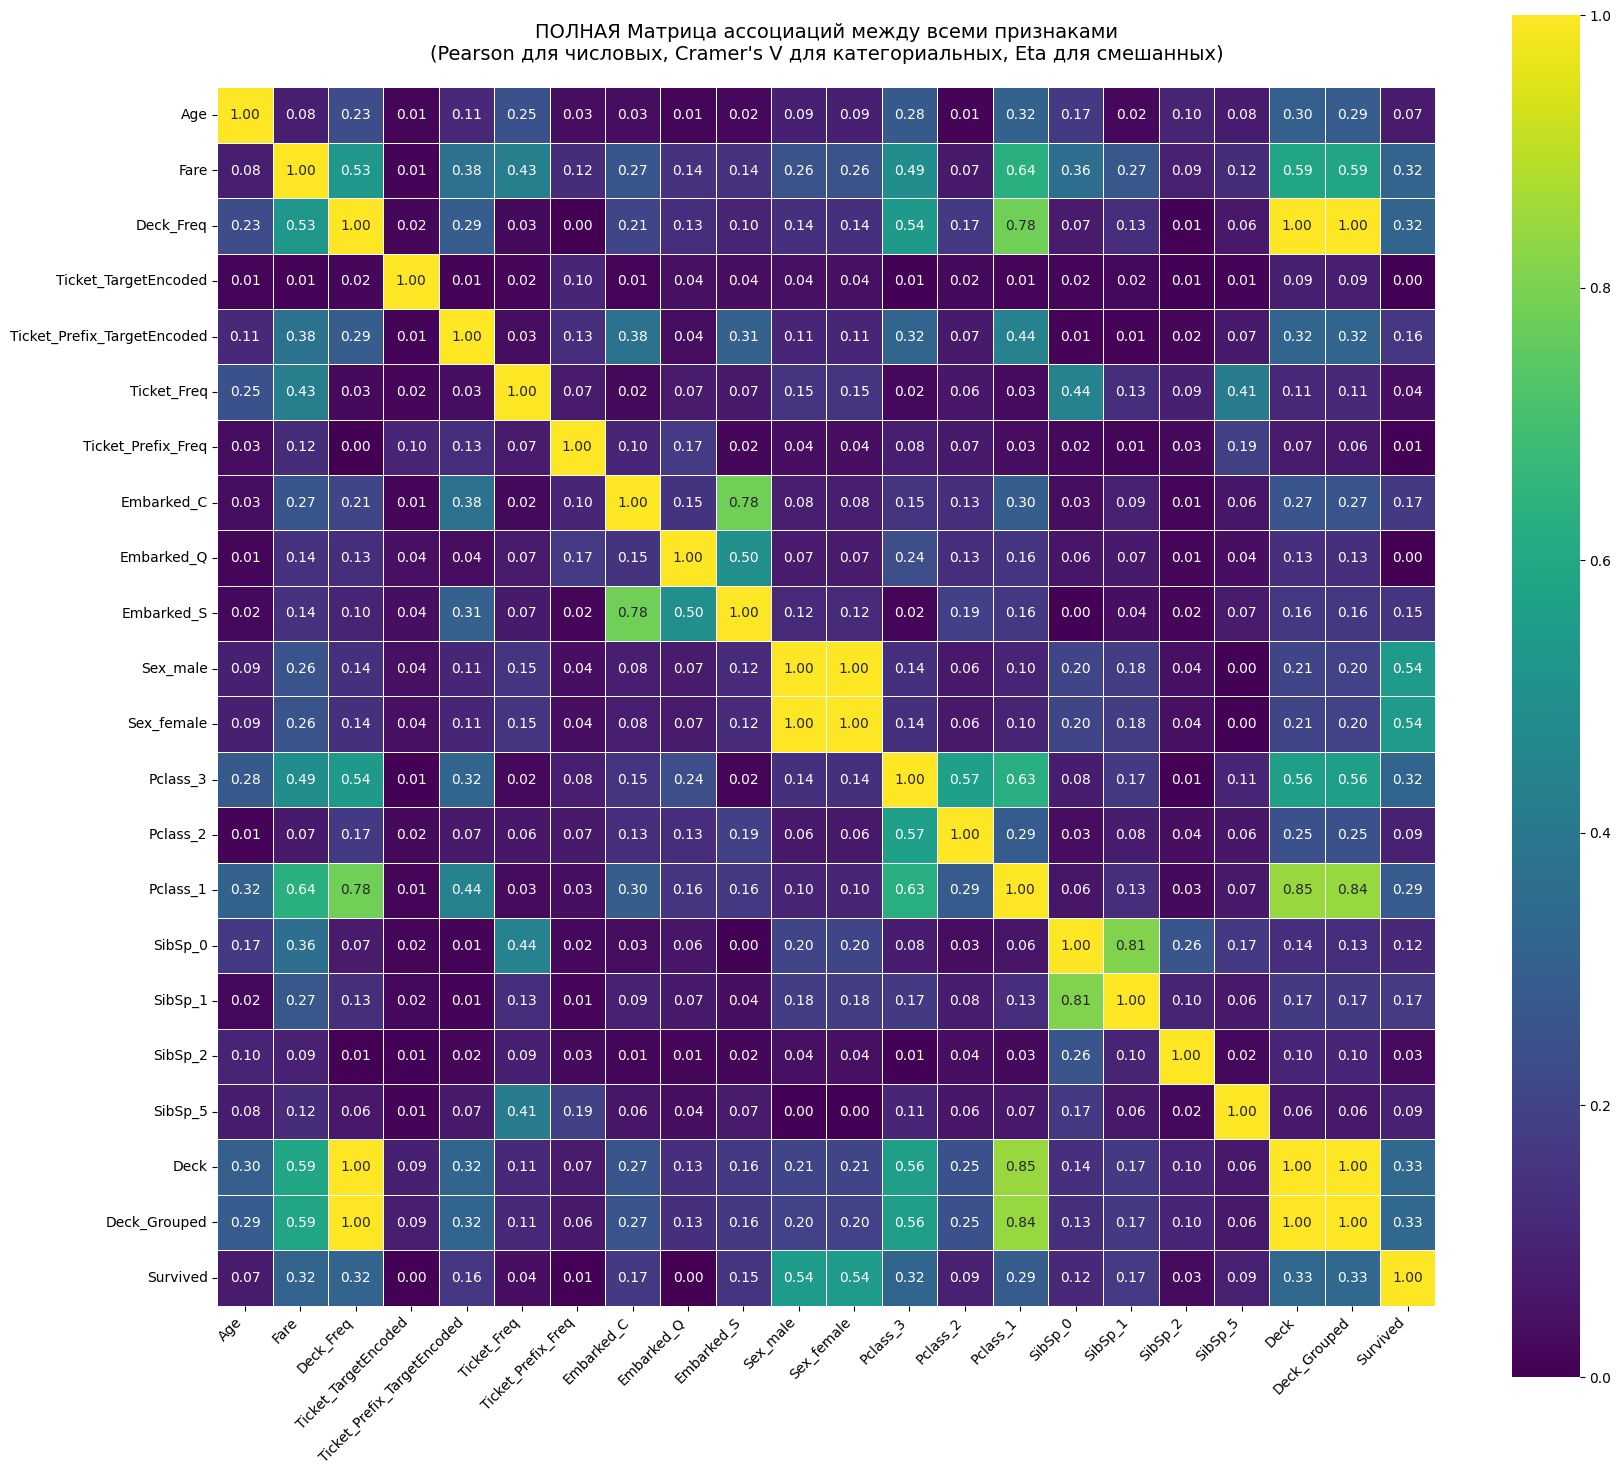


📊 КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ


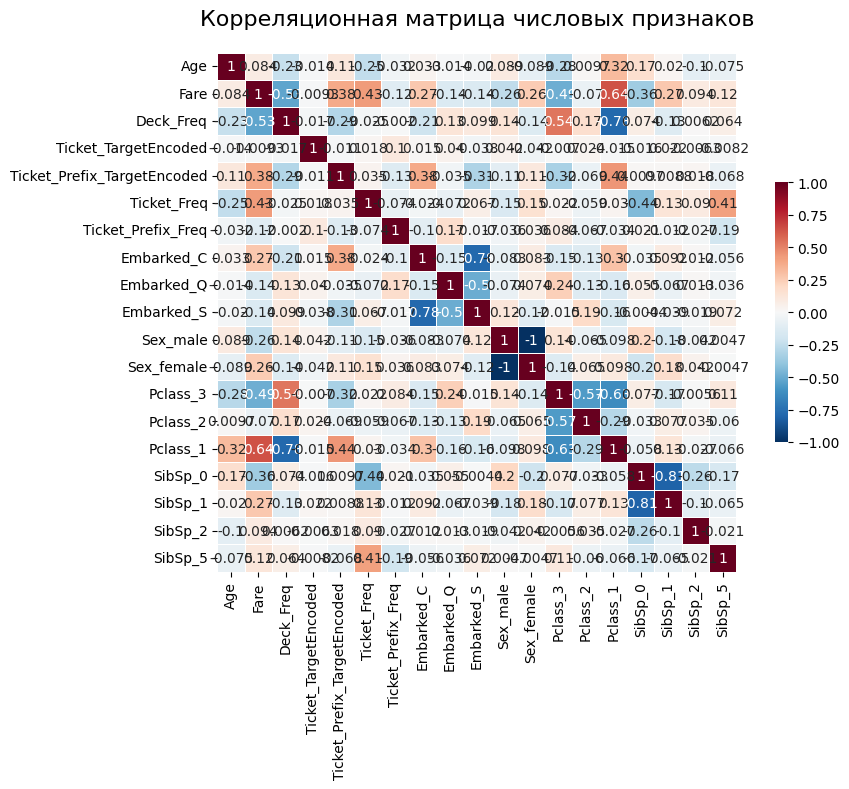

⚠️  Сильные корреляции между числовыми признаками:
   • Age ↔ Pclass_1: r = 0.316
   • Fare ↔ Deck_Freq: r = -0.530
   • Fare ↔ Ticket_Prefix_TargetEncoded: r = 0.377
   • Fare ↔ Ticket_Freq: r = 0.426
   • Fare ↔ Pclass_3: r = -0.492
   • Fare ↔ Pclass_1: r = 0.637
   • Fare ↔ SibSp_0: r = -0.357
   • Deck_Freq ↔ Pclass_3: r = 0.537
   • Deck_Freq ↔ Pclass_1: r = -0.783
   • Ticket_Prefix_TargetEncoded ↔ Embarked_C: r = 0.375
   • Ticket_Prefix_TargetEncoded ↔ Embarked_S: r = -0.307
   • Ticket_Prefix_TargetEncoded ↔ Pclass_3: r = -0.322
   • Ticket_Prefix_TargetEncoded ↔ Pclass_1: r = 0.439
   • Ticket_Freq ↔ SibSp_0: r = -0.441
   • Ticket_Freq ↔ SibSp_5: r = 0.412
   • Embarked_C ↔ Embarked_S: r = -0.783
   • Embarked_Q ↔ Embarked_S: r = -0.499
   • Sex_male ↔ Sex_female: r = -1.000
   • Pclass_3 ↔ Pclass_2: r = -0.565
   • Pclass_3 ↔ Pclass_1: r = -0.627
   • SibSp_0 ↔ SibSp_1: r = -0.811

🕳️  АНАЛИЗ ПРОПУСКОВ И РЕКОМЕНДАЦИИ
✅ Пропуски не обнаружены

💡 ИТОГОВЫЕ РЕКОМЕНДАЦИИ
1. Про

{'association_matrix':                                   Age      Fare  Deck_Freq  \
 Age                          1.000000  0.084100   0.226625   
 Fare                         0.084100  1.000000   0.529942   
 Deck_Freq                    0.226625  0.529942   1.000000   
 Ticket_TargetEncoded         0.014152  0.009269   0.016981   
 Ticket_Prefix_TargetEncoded  0.114244  0.377339   0.289895   
 Ticket_Freq                  0.249395  0.426120   0.025445   
 Ticket_Prefix_Freq           0.032450  0.121754   0.002029   
 Embarked_C                   0.032792  0.267014   0.206315   
 Embarked_Q                   0.013859  0.142176   0.129548   
 Embarked_S                   0.020005  0.144444   0.099215   
 Sex_male                     0.088794  0.255293   0.139243   
 Sex_female                   0.088794  0.255293   0.139243   
 Pclass_3                     0.280138  0.491652   0.536533   
 Pclass_2                     0.009680  0.069822   0.169486   
 Pclass_1                     0.3

In [48]:
multivariate_eda_analysis(df_encoded, target_column="Survived", numerical_features=['Age','Fare','Deck_Freq','Ticket_TargetEncoded','Ticket_Prefix_TargetEncoded','Ticket_Freq','Ticket_Prefix_Freq', 
                                                                                    'Embarked_C','Embarked_Q','Embarked_S','Sex_male','Sex_female','Pclass_3','Pclass_2','Pclass_1','SibSp_0','SibSp_1','SibSp_2','SibSp_5'])
                           

Deck_Freq :
   Pclass_1, Pclass_3, Fare    

Deck_Grouped :
   Fare

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Pclass_1' ↔ 'Deck_Freq'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Уникальных значений в 'Pclass_1': 2
   • Уникальных значений в 'Deck_Freq': 9
   • Тип 'Pclass_1': categorical
   • Тип 'Deck_Freq': categorical

📋 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ ↔ КАТЕГОРИАЛЬНАЯ
--------------------------------------------------
📊 Таблица сопряженности:
Deck_Freq  1  4  13  15  32  33  47  59  687  All
Pclass_1                                         
0          0  4  13   0   7   4   0   0  647  675
1          1  0   0  15  25  29  47  59   40  216
All        1  4  13  15  32  33  47  59  687  891

📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
   • Chi-square статистика: 636.9639
   • p-value: 0.000000
   • Степени свободы: 8
   • Cramer's V: 0.8455
   • Связь: значимая (α = 0.05)
   • Сила связи: сильная


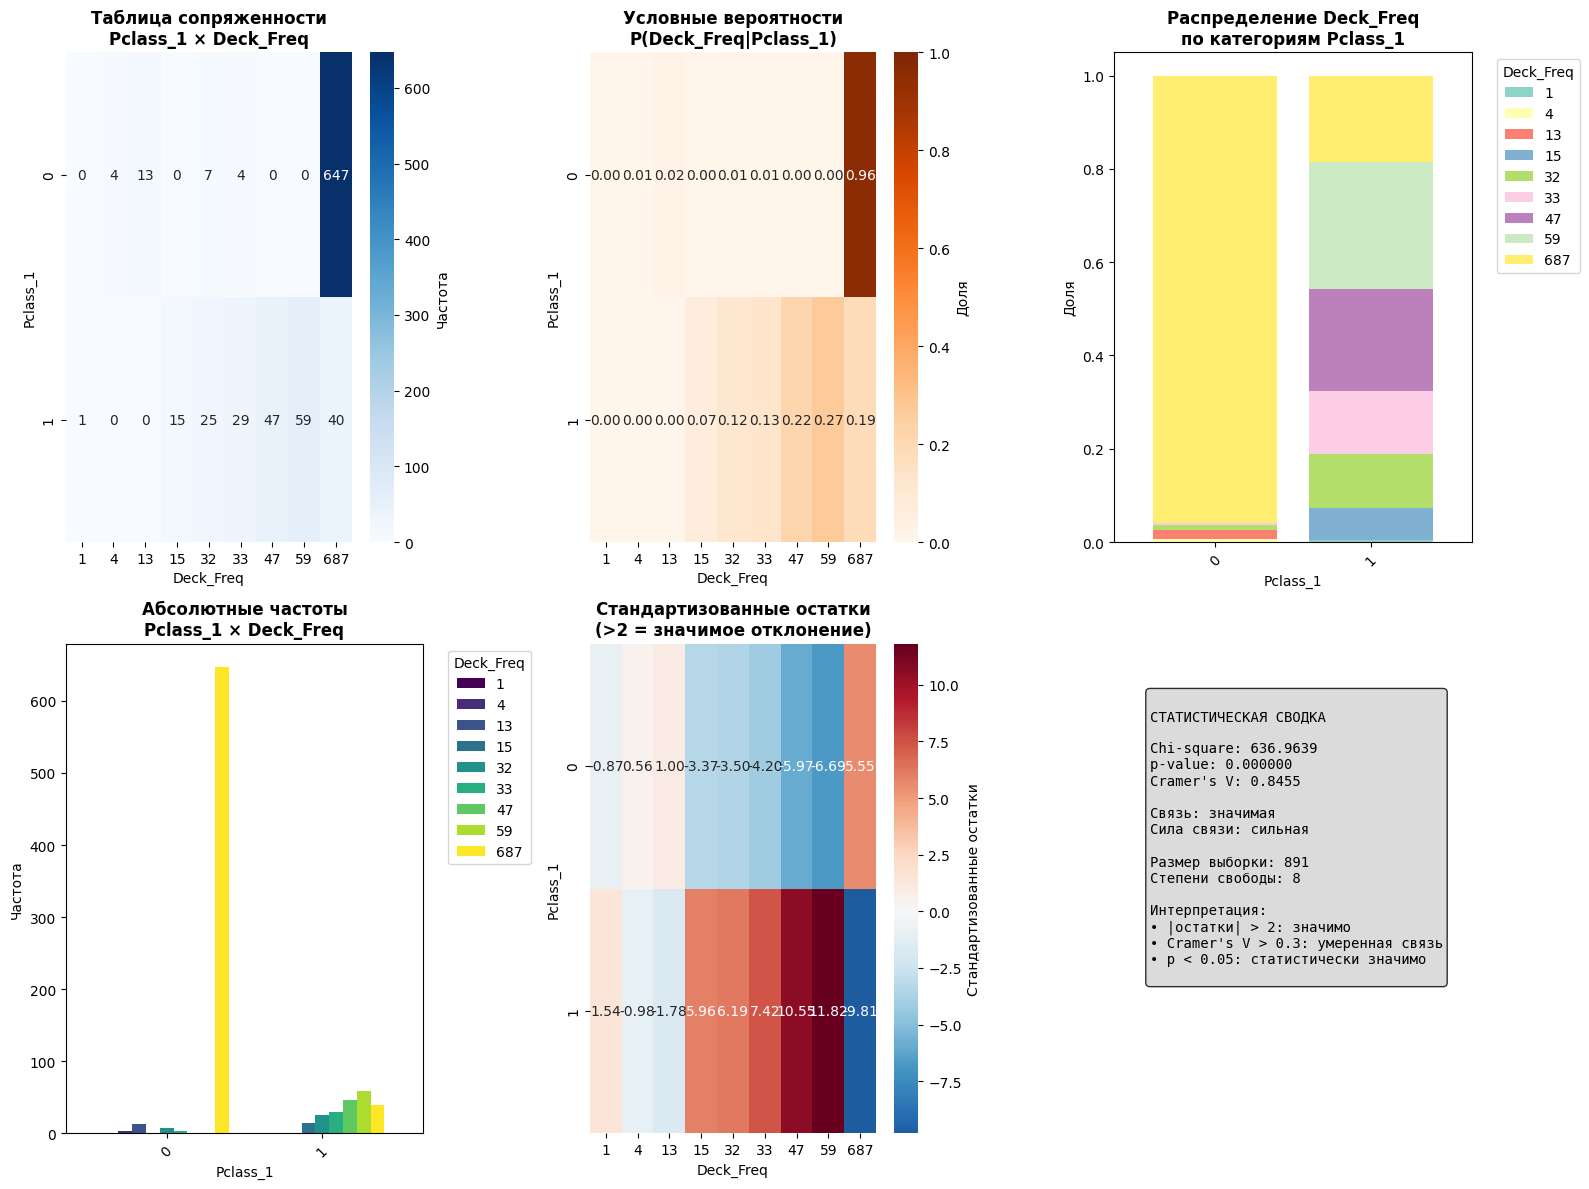


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'Chi-square',
 'statistic': np.float64(636.9638789574236),
 'p_value': np.float64(2.631792082780259e-132),
 'effect_size': np.float64(0.8455096145933075),
 'effect_size_name': 'Cramers_V',
 'significant': np.True_,
 'contingency_table': Deck_Freq  1    4    13   15   32   33   47   59   687
 Pclass_1                                              
 0            0    4   13    0    7    4    0    0  647
 1            1    0    0   15   25   29   47   59   40,
 'residuals': Deck_Freq       1         4         13        15        32        33   \
 Pclass_1                                                                
 0         -0.870388  0.557048  1.004233 -3.370999 -3.501953 -4.200000   
 1          1.538644 -0.984732 -1.775251  5.959141  6.190637  7.424621   
 
 Deck_Freq        47         59        687  
 Pclass_1                                   
 0          -5.967081  -6.685579  5.546961  
 1          10.548409  11.818546 -9.805735  }

In [49]:
analyze_variable_relationship(df_encoded, 'Pclass_1', 'Deck_Freq')

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Pclass_3' ↔ 'Deck_Freq'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Уникальных значений в 'Pclass_3': 2
   • Уникальных значений в 'Deck_Freq': 9
   • Тип 'Pclass_3': categorical
   • Тип 'Deck_Freq': categorical

📋 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ ↔ КАТЕГОРИАЛЬНАЯ
--------------------------------------------------
📊 Таблица сопряженности:
Deck_Freq  1  4  13  15  32  33  47  59  687  All
Pclass_3                                         
0          1  0   8  15  29  33  47  59  208  400
1          0  4   5   0   3   0   0   0  479  491
All        1  4  13  15  32  33  47  59  687  891

📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
   • Chi-square статистика: 281.3591
   • p-value: 0.000000
   • Степени свободы: 8
   • Cramer's V: 0.5619
   • Связь: значимая (α = 0.05)
   • Сила связи: сильная


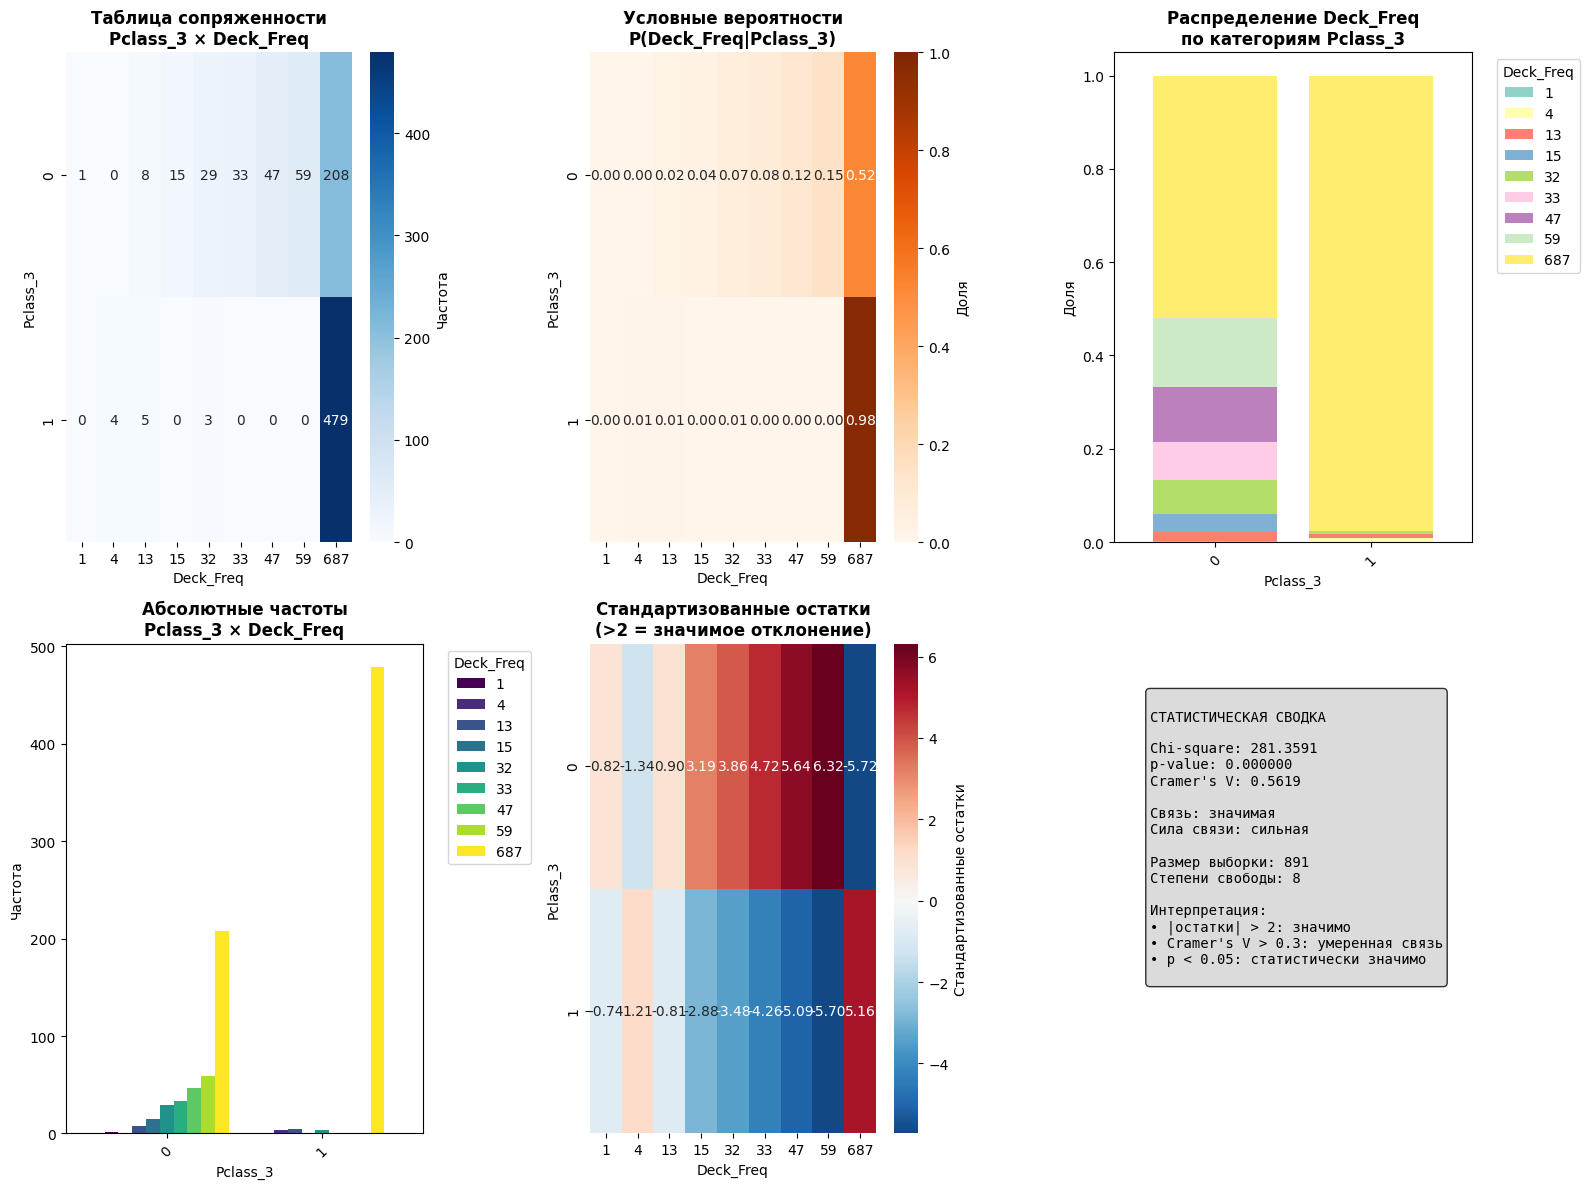


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'Chi-square',
 'statistic': np.float64(281.35914186808856),
 'p_value': np.float64(3.797294522016217e-56),
 'effect_size': np.float64(0.5619422206380985),
 'effect_size_name': 'Cramers_V',
 'significant': np.True_,
 'contingency_table': Deck_Freq  1    4    13   15   32   33   47   59   687
 Pclass_3                                              
 0            1    0    8   15   29   33   47   59  208
 1            0    4    5    0    3    0    0    0  479,
 'residuals': Deck_Freq       1         4         13        15        32        33   \
 Pclass_3                                                                
 0          0.822456 -1.340050  0.895708  3.185358  3.861006  4.724650   
 1         -0.742338  1.209513 -0.808455 -2.875064 -3.484895 -4.264409   
 
 Deck_Freq       47        59        687  
 Pclass_3                                 
 0          5.638474  6.317404 -5.717944  
 1         -5.089215 -5.702009  5.160944  }

In [50]:
analyze_variable_relationship(df_encoded, 'Pclass_3', 'Deck_Freq')

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СВЯЗИ: 'Fare' ↔ 'Deck_Freq'
📊 БАЗОВАЯ ИНФОРМАЦИЯ:
   • Исходный размер выборки: 891
   • После удаления пропусков: 891
   • Доля пропусков: 0.00%
   • Уникальных значений в 'Fare': 248
   • Уникальных значений в 'Deck_Freq': 9
   • Тип 'Fare': numerical
   • Тип 'Deck_Freq': categorical

📊 АНАЛИЗ: КАТЕГОРИАЛЬНАЯ (Deck_Freq) ↔ ЧИСЛОВАЯ (Fare)
--------------------------------------------------
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА ПО ГРУППАМ:
           count   mean    std  median    min    max
Deck_Freq                                           
1              1  0.715    NaN   0.715  0.715  0.715
4              4 -0.059  0.189  -0.059 -0.223  0.105
13            13  0.083  0.476  -0.075 -0.423  0.799
15            15  0.585  1.033   0.715 -3.008  1.529
32            32  0.773  0.674   0.926 -0.392  2.093
33            33  1.038  0.590   1.088 -0.082  1.890
47            47  1.465  1.303   1.504 -3.008  3.980
59            59  1.545  0.778   1.550  0.467  2.966
687          687 -

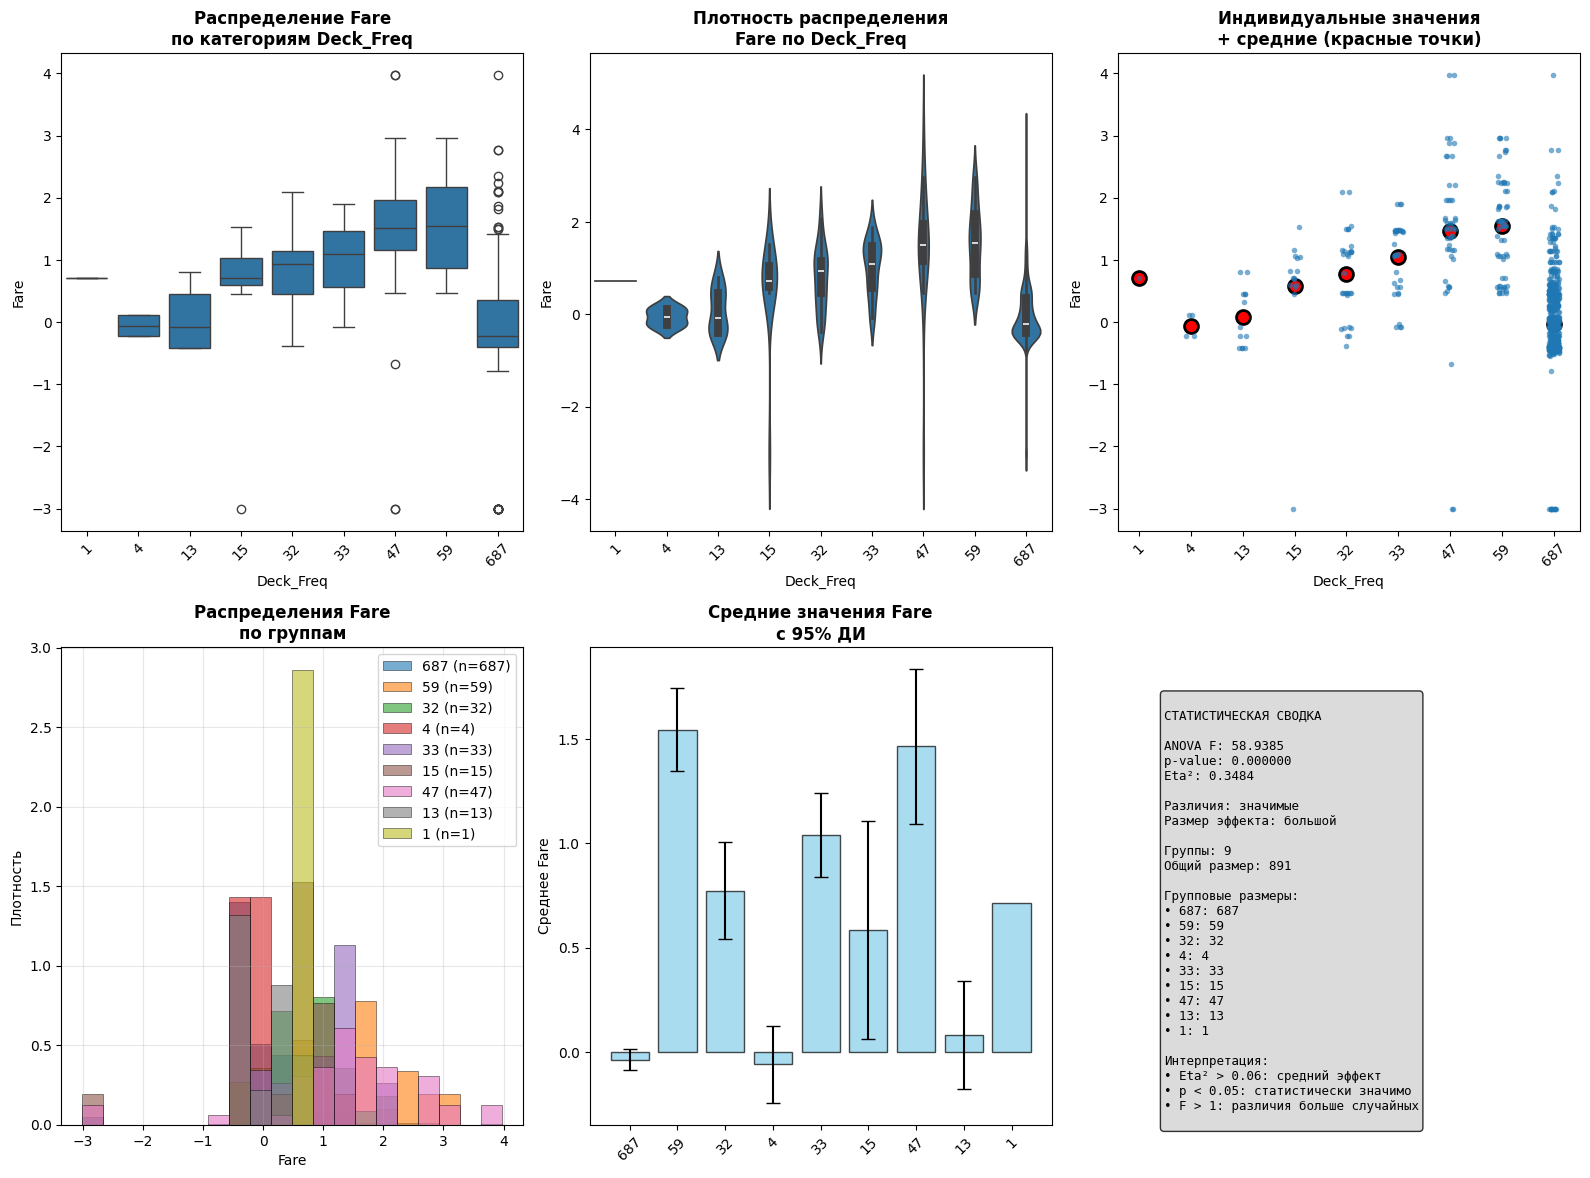


✅ АНАЛИЗ ЗАВЕРШЕН


{'test_type': 'ANOVA',
 'f_statistic': np.float64(58.93853595485818),
 'p_value': np.float64(5.889100638082718e-77),
 'eta_squared': np.float64(0.3483601038464203),
 'significant': np.True_,
 'group_stats':            count      mean       std    median       min       max
 Deck_Freq                                                         
 1              1  0.715225       NaN  0.715225  0.715225  0.715225
 4              4 -0.058841  0.189314 -0.058841 -0.222792  0.105110
 13            13  0.082829  0.475783 -0.074952 -0.423213  0.799087
 15            15  0.585448  1.032781  0.715225 -3.007504  1.528776
 32            32  0.773227  0.674139  0.926141 -0.391575  2.092862
 33            33  1.038425  0.590029  1.087595 -0.081690  1.890347
 47            47  1.465415  1.302682  1.504235 -3.007504  3.980220
 59            59  1.544573  0.778351  1.549780  0.467435  2.965883
 687          687 -0.035923  0.685907 -0.220417 -3.007504  3.980220,
 'n_groups': 9}

In [51]:
analyze_variable_relationship(df_encoded, 'Fare', 'Deck_Freq')

Похоже на F = -D^(3)-1.5 D^(2)+0.4

In [85]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Survived                     891 non-null    int64  
 1   Age                          891 non-null    float64
 2   Fare                         891 non-null    float64
 3   SibSp_0                      891 non-null    int64  
 4   SibSp_1                      891 non-null    int64  
 5   SibSp_2                      891 non-null    int64  
 6   SibSp_3                      891 non-null    int64  
 7   SibSp_4                      891 non-null    int64  
 8   SibSp_5                      891 non-null    int64  
 9   Parch_0                      891 non-null    int64  
 10  Parch_1                      891 non-null    int64  
 11  Parch_2                      891 non-null    int64  
 12  Parch_3                      891 non-null    int64  
 13  Pclass_1            

In [52]:
df_encoded = df_encoded.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Deck', 'Cabin_Clean'], axis=1)    

In [53]:
df_encoded['Deck_Freq'].unique()                    

array([687,  59,  32,   4,  33,  15,  47,  13,   1])

In [54]:
df_encoded['Deck_Grouped'].unique()                 

array(['Missing', 'C', 'E', 'Rare_Deck', 'D', 'A', 'B', 'F'], dtype=object)

In [55]:
df_encoded['Ticket_Prefix'].unique()    

array(['A', 'PC', 'STONO', 'NO_PREFIX', 'PP', 'CA', 'SCPARIS', 'SCA',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SOP', 'FA', 'LINE',
       'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS', 'SOPP', 'FC',
       'SOTONO', 'CASOTON'], dtype=object)

In [56]:
def predict_missing_values(df_encoded):
    """
    Предсказывает пропущенные значения Deck_Grouped, Deck_Freq и Ticket_Prefix
    на основе найденных закономерностей в данных
    """
    df_work = df_encoded.copy()
    
    # =============================================================================
    # 1. ПРЕДСКАЗАНИЕ DECK_GROUPED И DECK_FREQ
    # =============================================================================
    print("🔍 ПРЕДСКАЗАНИЕ ЗНАЧЕНИЙ ПАЛУБЫ (DECK)")
    print("=" * 60)
    
    # Создаем маски для пропущенных значений
    missing_deck_mask = df_work['Deck_Grouped'] == 'Missing'
    print(f"Количество пропущенных значений палубы: {missing_deck_mask.sum()}")
    
    if missing_deck_mask.sum() > 0:
        # Признаки для предсказания палубы (на основе найденных корреляций)
        deck_features = [
            'Pclass_1', 'Pclass_2', 'Pclass_3',  # Сильная связь с палубой
            'Fare',  # r = -0.530 с Deck_Freq
            'Age',   # Может влиять на размещение
            'Sex_male', 'Sex_female',
            'SibSp_0', 'SibSp_1', 'SibSp_2',  # Размер семьи
            'Parch_0', 'Parch_1', 'Parch_2',
            'Embarked_C', 'Embarked_S', 'Embarked_Q',
            'Ticket_Freq', 'Ticket_Prefix_TargetEncoded'  # Связанные признаки
        ]
        
        # Данные для обучения (без пропущенных значений)
        train_mask = ~missing_deck_mask
        X_train_deck = df_work.loc[train_mask, deck_features]
        y_train_deck = df_work.loc[train_mask, 'Deck_Grouped']
        
        # Данные для предсказания
        X_pred_deck = df_work.loc[missing_deck_mask, deck_features]
        
        # Обучение модели для Deck_Grouped
        rf_deck = RandomForestClassifier(
            n_estimators=200, 
            max_depth=10, 
            min_samples_split=5,
            random_state=42,
            class_weight='balanced'  # Учитываем дисбаланс классов
        )
        
        rf_deck.fit(X_train_deck, y_train_deck)
        
        # Оценка качества модели
        cv_scores = cross_val_score(rf_deck, X_train_deck, y_train_deck, cv=5, scoring='accuracy')
        print(f"Точность модели предсказания палубы: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        # Предсказание пропущенных значений
        deck_predictions = rf_deck.predict(X_pred_deck)
        
        # Замена пропущенных значений
        df_work.loc[missing_deck_mask, 'Deck_Grouped'] = deck_predictions
        
        # Обновление Deck_Freq на основе новых значений
        # Пересчитываем частоты для всех значений палубы
        deck_freq_mapping = df_work['Deck_Grouped'].value_counts().to_dict()
        df_work['Deck_Freq'] = df_work['Deck_Grouped'].map(deck_freq_mapping)
        
        print(f"✅ Предсказано {len(deck_predictions)} значений палубы")
        print("Распределение предсказанных значений палубы:")
        pred_counts = pd.Series(deck_predictions).value_counts()
        for deck, count in pred_counts.items():
            print(f"  {deck}: {count}")
    
    # =============================================================================
    # 2. ПРЕДСКАЗАНИЕ TICKET_PREFIX
    # =============================================================================
    print("\n🎫 ПРЕДСКАЗАНИЕ ПРЕФИКСОВ БИЛЕТОВ (TICKET_PREFIX)")
    print("=" * 60)
    
    missing_ticket_mask = df_work['Ticket_Prefix'] == 'NO_PREFIX'
    print(f"Количество пропущенных префиксов билетов: {missing_ticket_mask.sum()}")
    
    if missing_ticket_mask.sum() > 0:
        # Признаки для предсказания префикса билета
        ticket_features = [
            'Pclass_1', 'Pclass_2', 'Pclass_3',
            'Fare',  # r = 0.377 с Ticket_Prefix_TargetEncoded
            'Embarked_C', 'Embarked_S', 'Embarked_Q',  # r = 0.375 с Embarked_C
            'Age',
            'Sex_male', 'Sex_female',
            'SibSp_0', 'SibSp_1', 'SibSp_2',
            'Parch_0', 'Parch_1', 'Parch_2',
            'Deck_Freq',  # Обновленные значения палубы
            'Ticket_Freq'
        ]
        
        # Данные для обучения
        train_mask_ticket = ~missing_ticket_mask
        X_train_ticket = df_work.loc[train_mask_ticket, ticket_features]
        y_train_ticket = df_work.loc[train_mask_ticket, 'Ticket_Prefix']
        
        # Данные для предсказания
        X_pred_ticket = df_work.loc[missing_ticket_mask, ticket_features]
        
        # Обучение модели для Ticket_Prefix
        rf_ticket = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=3,
            random_state=42,
            class_weight='balanced'
        )
        
        rf_ticket.fit(X_train_ticket, y_train_ticket)
        
        # Оценка качества модели
        cv_scores_ticket = cross_val_score(rf_ticket, X_train_ticket, y_train_ticket, cv=5, scoring='accuracy')
        print(f"Точность модели предсказания префиксов: {cv_scores_ticket.mean():.3f} ± {cv_scores_ticket.std():.3f}")
        
        # Предсказание пропущенных значений
        ticket_predictions = rf_ticket.predict(X_pred_ticket)
        
        # Замена пропущенных значений
        df_work.loc[missing_ticket_mask, 'Ticket_Prefix'] = ticket_predictions
        
        print(f"✅ Предсказано {len(ticket_predictions)} префиксов билетов")
        print("Распределение предсказанных префиксов:")
        pred_counts_ticket = pd.Series(ticket_predictions).value_counts().head(10)
        for prefix, count in pred_counts_ticket.items():
            print(f"  {prefix}: {count}")
        
        # Пересчитываем частотное кодирование префиксов
        prefix_freq_mapping = df_work['Ticket_Prefix'].value_counts().to_dict()
        df_work['Ticket_Prefix_Freq'] = df_work['Ticket_Prefix'].map(prefix_freq_mapping)
        
        # Пересчитываем Target Encoding для префиксов (упрощенная версия)
        # Используем общий средний survival rate для новых префиксов
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        df_work['Ticket_Prefix_Encoded'] = le.fit_transform(df_work['Ticket_Prefix'])
        
        # Обновляем Target Encoding на основе новых значений
        prefix_survival_rate = df_work.groupby('Ticket_Prefix')['Survived'].mean()
        df_work['Ticket_Prefix_TargetEncoded'] = df_work['Ticket_Prefix'].map(prefix_survival_rate)
    
    # =============================================================================
    # 3. ПОКАЗЫВАЕМ ВАЖНОСТЬ ПРИЗНАКОВ
    # =============================================================================
    print("\n📊 ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРЕДСКАЗАНИЯ ПАЛУБЫ:")
    if missing_deck_mask.sum() > 0:
        feature_importance_deck = pd.DataFrame({
            'feature': deck_features,
            'importance': rf_deck.feature_importances_
        }).sort_values('importance', ascending=False)
        
        for idx, row in feature_importance_deck.head(8).iterrows():
            print(f"  {row['feature']}: {row['importance']:.3f}")
    
    print("\n📊 ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРЕДСКАЗАНИЯ ПРЕФИКСОВ:")
    if missing_ticket_mask.sum() > 0:
        feature_importance_ticket = pd.DataFrame({
            'feature': ticket_features,
            'importance': rf_ticket.feature_importances_
        }).sort_values('importance', ascending=False)
        
        for idx, row in feature_importance_ticket.head(8).iterrows():
            print(f"  {row['feature']}: {row['importance']:.3f}")
    
    # =============================================================================
    # 4. ПРОВЕРКА РЕЗУЛЬТАТОВ
    # =============================================================================
    print("\n🔍 ПРОВЕРКА РЕЗУЛЬТАТОВ:")
    print("=" * 40)
    print(f"Deck_Grouped - уникальные значения: {df_work['Deck_Grouped'].nunique()}")
    print(f"Deck_Grouped - распределение:\n{df_work['Deck_Grouped'].value_counts()}")
    print(f"\nTicket_Prefix - уникальные значения: {df_work['Ticket_Prefix'].nunique()}")
    print(f"Ticket_Prefix - топ-10:\n{df_work['Ticket_Prefix'].value_counts().head(10)}")
    
    # Проверяем, что нет пропущенных значений
    missing_deck_after = (df_work['Deck_Grouped'] == 'Missing').sum()
    missing_ticket_after = (df_work['Ticket_Prefix'] == 'NO_PREFIX').sum()
    
    print(f"\n✅ Пропущенных значений палубы после обработки: {missing_deck_after}")
    print(f"✅ Пропущенных префиксов после обработки: {missing_ticket_after}")
    
    return df_work

def analyze_predictions_quality(df_original, df_predicted):
    """
    Анализирует качество предсказанных значений
    """
    print("\n📈 АНАЛИЗ КАЧЕСТВА ПРЕДСКАЗАНИЙ:")
    print("=" * 50)
    
    # Сравниваем распределения survival rate
    original_deck_survival = df_original[df_original['Deck_Grouped'] != 'Missing'].groupby('Deck_Grouped')['Survived'].mean()
    predicted_deck_survival = df_predicted.groupby('Deck_Grouped')['Survived'].mean()
    
    print("Survival rate по палубам (исходные vs с предсказаниями):")
    comparison_df = pd.DataFrame({
        'Original': original_deck_survival,
        'With_Predictions': predicted_deck_survival
    }).fillna(0)
    
    print(comparison_df.round(3))
    
    # Проверяем логичность предсказаний на основе известных закономерностей
    print("\n🔍 ПРОВЕРКА ЛОГИЧНОСТИ ПРЕДСКАЗАНИЙ:")
    
    # Анализ по классам
    class_deck_crosstab = pd.crosstab(
        df_predicted[['Pclass_1', 'Pclass_2', 'Pclass_3']].idxmax(axis=1),
        df_predicted['Deck_Grouped'],
        normalize='index'
    )
    print("\nРаспределение палуб по классам (доли):")
    print(class_deck_crosstab.round(3))

In [57]:
df_predicted = predict_missing_values(df_encoded)
analyze_predictions_quality(df_encoded, df_predicted)

🔍 ПРЕДСКАЗАНИЕ ЗНАЧЕНИЙ ПАЛУБЫ (DECK)
Количество пропущенных значений палубы: 687
Точность модели предсказания палубы: 0.406 ± 0.057
✅ Предсказано 687 значений палубы
Распределение предсказанных значений палубы:
  F: 529
  Rare_Deck: 68
  D: 42
  E: 18
  C: 15
  A: 8
  B: 7

🎫 ПРЕДСКАЗАНИЕ ПРЕФИКСОВ БИЛЕТОВ (TICKET_PREFIX)
Количество пропущенных префиксов билетов: 661
Точность модели предсказания префиксов: 0.635 ± 0.050
✅ Предсказано 661 префиксов билетов
Распределение предсказанных префиксов:
  PC: 149
  A: 128
  CA: 112
  STONO: 105
  PP: 27
  WC: 23
  SCOW: 17
  FCC: 17
  SCAH: 14
  SOTONOQ: 12

📊 ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРЕДСКАЗАНИЯ ПАЛУБЫ:
  Fare: 0.233
  Age: 0.154
  Ticket_Prefix_TargetEncoded: 0.108
  Pclass_1: 0.095
  Ticket_Freq: 0.064
  Pclass_3: 0.061
  Pclass_2: 0.037
  Parch_0: 0.036

📊 ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРЕДСКАЗАНИЯ ПРЕФИКСОВ:
  Fare: 0.285
  Age: 0.258
  Ticket_Freq: 0.078
  Deck_Freq: 0.061
  Pclass_2: 0.039
  Pclass_3: 0.035
  Embarked_C: 0.032
  Embarked_S: 0.03

In [111]:
df_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Survived                     891 non-null    int64  
 1   Age                          891 non-null    float64
 2   Fare                         891 non-null    float64
 3   SibSp_0                      891 non-null    int64  
 4   SibSp_1                      891 non-null    int64  
 5   SibSp_2                      891 non-null    int64  
 6   SibSp_3                      891 non-null    int64  
 7   SibSp_4                      891 non-null    int64  
 8   SibSp_5                      891 non-null    int64  
 9   Parch_0                      891 non-null    int64  
 10  Parch_1                      891 non-null    int64  
 11  Parch_2                      891 non-null    int64  
 12  Parch_3                      891 non-null    int64  
 13  Pclass_1            

In [58]:
df_predicted = apply_one_hot_encoding(df_predicted, 'Ticket_Prefix')

In [59]:
df_predicted = apply_one_hot_encoding(df_predicted, 'Deck_Grouped')

In [60]:
ma = MissingValueAnalyzer(df_predicted)
ma.basic_missing_analysis()

=== БАЗОВЫЙ АНАЛИЗ ПРОПУСКОВ ===
Общее количество ячеек: 54351
Количество пропусков: 0
Процент пропусков: 0.00%

Пропуски по столбцам:
Empty DataFrame
Columns: [Пропуски, Процент]
Index: []



Пропуски  Процент
Survived                       0      0.0
Age                            0      0.0
Fare                           0      0.0
SibSp_0                        0      0.0
SibSp_1                        0      0.0
...                          ...      ...
Deck_Grouped_C                 0      0.0
Deck_Grouped_D                 0      0.0
Deck_Grouped_E                 0      0.0
Deck_Grouped_F                 0      0.0
Deck_Grouped_Rare_Deck         0      0.0

[61 rows x 2 columns]

# Обучение моделей

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, 
                           roc_curve, precision_recall_curve, log_loss)

from sklearn.linear_model import LogisticRegression, Ridge, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                            AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [62]:

X = df_predicted.drop('Survived', axis=1)
y = df_predicted['Survived']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nОбучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка: {X_test.shape[0]} образцов")

# Определение моделей для сравнения
models = {
    # Линейные модели
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Ridge Classifier': Ridge(random_state=42),
    'SGD Classifier': SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
    
    # Наивный Байес
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    
    # Дискриминантный анализ
    'Linear DA': LinearDiscriminantAnalysis(),
    'Quadratic DA': QuadraticDiscriminantAnalysis(),
    
    # Деревья решений
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    
    # Ансамбли
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Bagging': BaggingClassifier(n_estimators=100, random_state=42),
    
    # Современные градиентные бустинги
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=False),
    
    # SVM
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    
    # k-NN
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'k-NN (k=10)': KNeighborsClassifier(n_neighbors=10),
    
    # Нейронные сети
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500),
}


Обучающая выборка: 712 образцов
Тестовая выборка: 179 образцов



ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ

Обучение Logistic Regression...
✓ Logistic Regression: Accuracy=0.8045, F1=0.7154, AUC-ROC=0.8337

Обучение Ridge Classifier...
✗ Ошибка при обучении Ridge Classifier: Classification metrics can't handle a mix of binary and continuous targets

Обучение SGD Classifier...
✓ SGD Classifier: Accuracy=0.7318, F1=0.5932, AUC-ROC=N/A

Обучение Gaussian NB...
✓ Gaussian NB: Accuracy=0.4804, F1=0.5674, AUC-ROC=0.7404

Обучение Multinomial NB...
✓ Multinomial NB: Accuracy=0.6648, F1=0.5775, AUC-ROC=0.6937

Обучение Linear DA...
✓ Linear DA: Accuracy=0.7933, F1=0.6891, AUC-ROC=0.8427

Обучение Quadratic DA...
✓ Quadratic DA: Accuracy=0.4358, F1=0.5430, AUC-ROC=0.5272

Обучение Decision Tree...
✓ Decision Tree: Accuracy=0.7430, F1=0.6618, AUC-ROC=0.7119

Обучение Random Forest...
✓ Random Forest: Accuracy=0.7877, F1=0.7164, AUC-ROC=0.8327

Обучение Extra Trees...
✓ Extra Trees: Accuracy=0.7542, F1=0.6667, AUC-ROC=0.7941

Обучение Gradient Boosting...
✓ Gradient Boosting

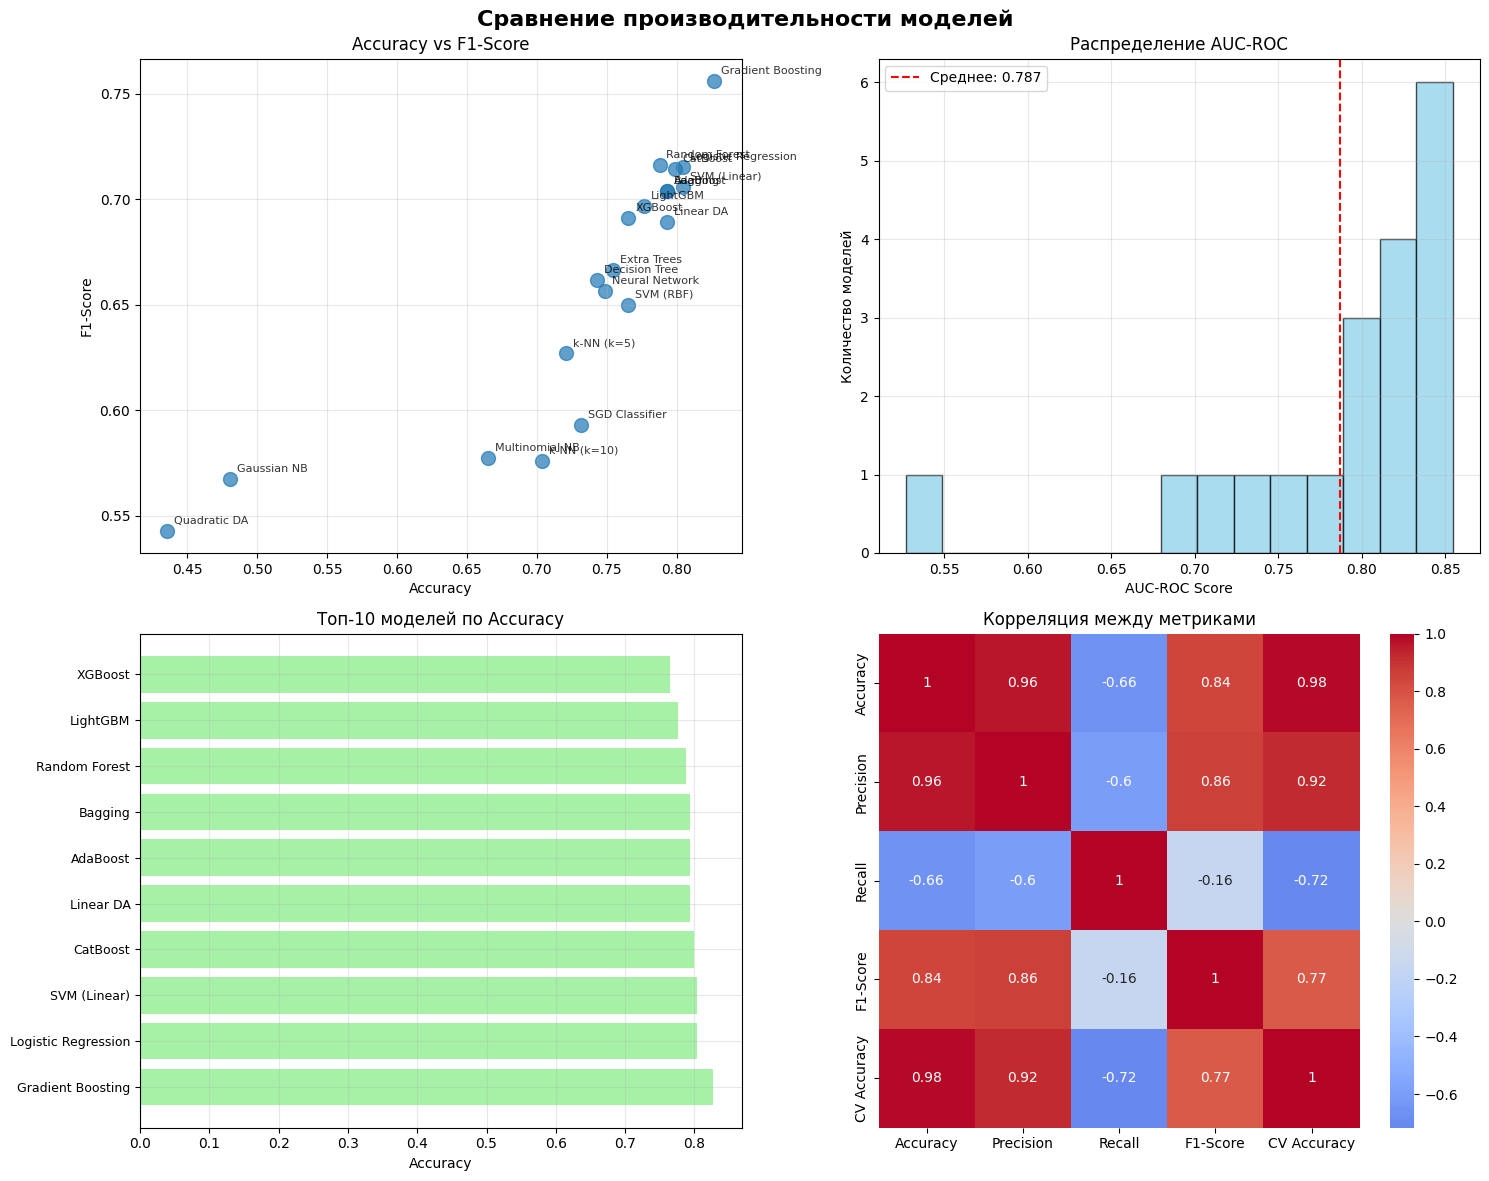

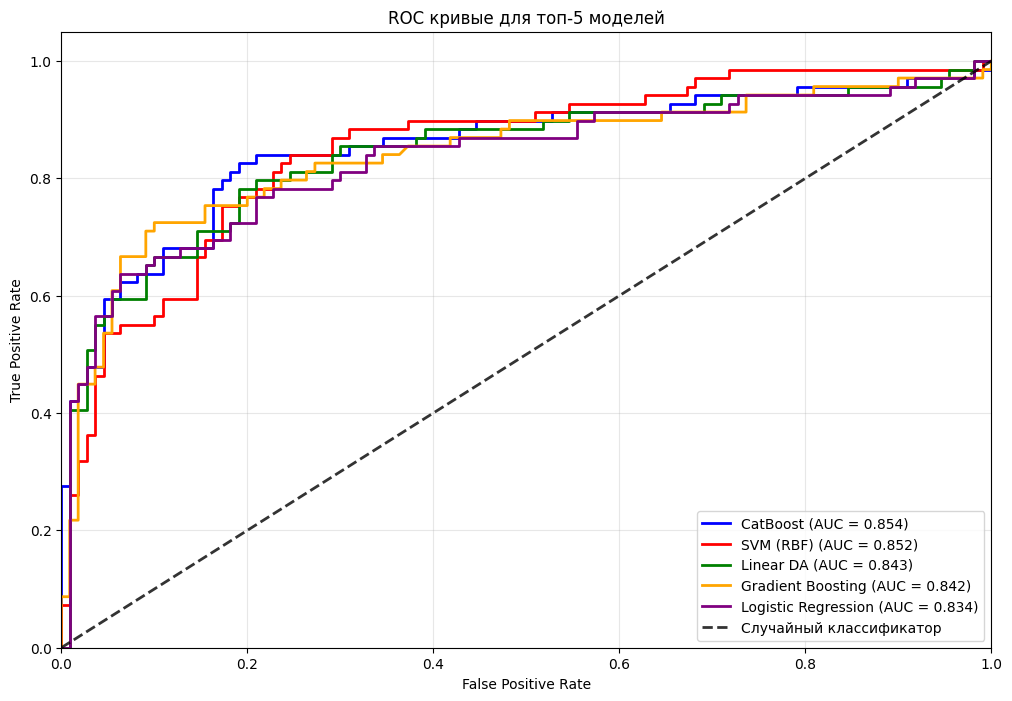

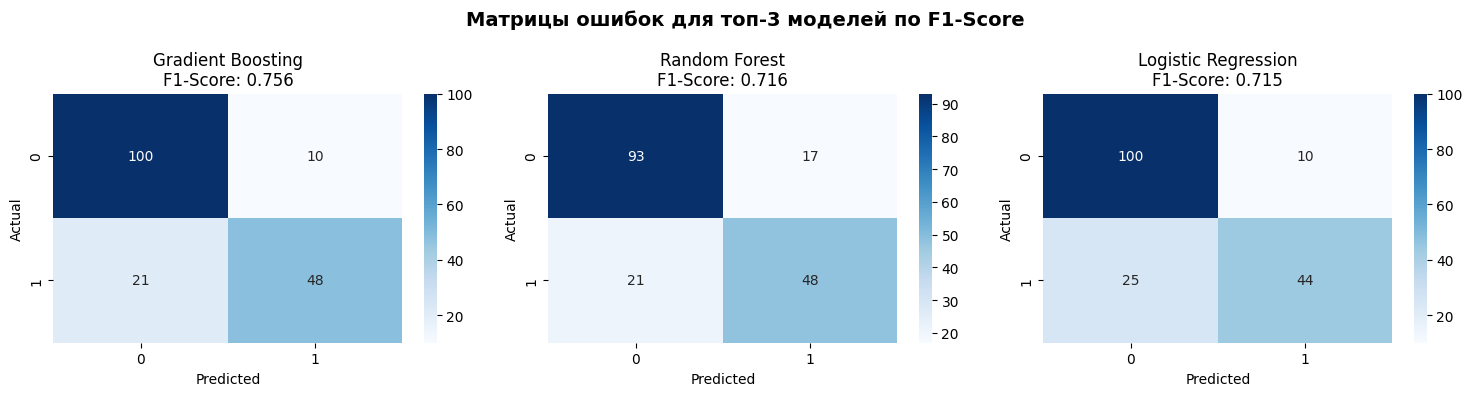


ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: Gradient Boosting
F1-Score: 0.7559
Accuracy: 0.8268
Precision: 0.8276
Recall: 0.6957
AUC-ROC: 0.8416
CV Accuracy: 0.8132

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179


Важность признаков для Gradient Boosting:
                    feature   importance
                 Sex_female 3.025892e-01
                   Sex_male 1.392049e-01
                        Age 1.228569e-01
                       Fare 1.102890e-01
                   Pclass_3 1.002608e-01
                Ticket_Freq 4.966597e-02
       Ticket_TargetEncoded 3.952993e-02
Ticket_Prefix_TargetEncoded 3.336357e-02
                 Embarked_S 2.032566e-02
                   Pclass_1 1.889461e-02
 

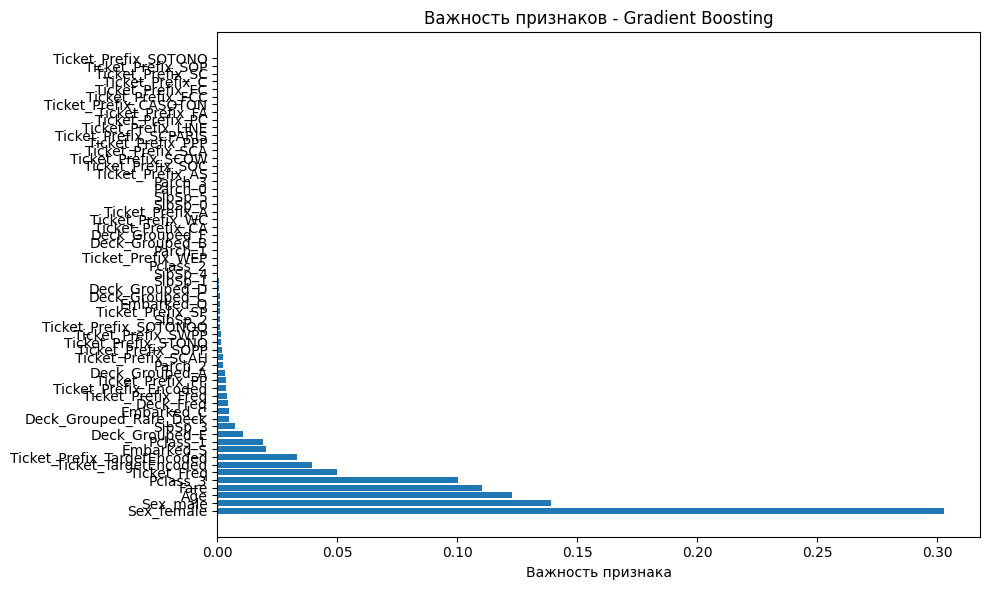


ГИПЕРПАРАМЕТРИЧЕСКАЯ ОПТИМИЗАЦИЯ

Оптимизация Random Forest...
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
CV F1-Score: 0.7468
Тестовый F1-Score: 0.7377
Улучшение F1: +0.0213

Оптимизация XGBoost...
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
CV F1-Score: 0.7473
Тестовый F1-Score: 0.7200
Улучшение F1: +0.0288

Оптимизация SVM (RBF)...
Лучшие параметры: {'C': 10, 'gamma': 'scale'}
CV F1-Score: 0.7134
Тестовый F1-Score: 0.7097
Улучшение F1: +0.0597

РЕКОМЕНДАЦИИ И ВЫВОДЫ
1. Лучшая модель по F1-Score: Gradient Boosting (0.7559)

2. Топ-3 модели по основным метрикам:
   Accuracy: Gradient Boosting, Logistic Regression, SVM (Linear)
   Precision: SVM (Linear), Gradient Boosting, Linear DA
   Recall: Gaussian NB, Quadratic DA, Random Forest
   F1-Score: Gradient Boosting, Random Forest, Logistic Regression
   AUC-ROC: CatBoost, SVM (RBF), Linear DA

3. Наиболее стабильные модели (высокая CV Accuracy):
   CatBoost: CV=0.82

In [63]:

results = {}
cv_scores = {}

print("\n" + "="*80)
print("ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ")
print("="*80)

for name, model in models.items():
    print(f"\nОбучение {name}...")
    
    try:
        # Определяем, нужно ли масштабирование для данной модели
        if name in ['Logistic Regression', 'Ridge Classifier', 'SGD Classifier', 
                   'SVM (RBF)', 'SVM (Linear)', 'k-NN (k=5)', 'k-NN (k=10)', 
                   'Neural Network', 'Linear DA', 'Quadratic DA']:
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test
            
        # Специальная обработка для MultinomialNB (требует неотрицательных значений)
        if name == 'Multinomial NB':
            X_train_use = X_train - X_train.min() + 1
            X_test_use = X_test - X_test.min() + 1
        
        # Обучение модели
        model.fit(X_train_use, y_train)
        
        # Предсказания
        y_pred = model.predict(X_test_use)
        y_pred_proba = model.predict_proba(X_test_use)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Кросс-валидация
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_score = cross_val_score(model, X_train_use, y_train, cv=cv, scoring='accuracy').mean()
        cv_scores[name] = cv_score
        
        # Расчет метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # AUC-ROC и Log Loss только для моделей с predict_proba
        if y_pred_proba is not None:
            auc_roc = roc_auc_score(y_test, y_pred_proba)
            logloss = log_loss(y_test, y_pred_proba)
        else:
            auc_roc = None  # Используем None вместо np.nan
            logloss = None
        
        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc_roc,
            'Log Loss': logloss,
            'CV Accuracy': cv_score,
            'Model': model,
            'Predictions': y_pred,
            'Probabilities': y_pred_proba
        }
        
        auc_display = f"{auc_roc:.4f}" if auc_roc is not None else "N/A"
        print(f"✓ {name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, AUC-ROC={auc_display}")
        
    except Exception as e:
        print(f"✗ Ошибка при обучении {name}: {str(e)}")
        continue

# Создание сводной таблицы результатов
results_df = pd.DataFrame(results).T
results_df = results_df.drop(['Model', 'Predictions', 'Probabilities'], axis=1)

# Преобразование в числовые типы с обработкой None
numeric_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss', 'CV Accuracy']
for col in numeric_columns:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

results_df = results_df.round(4)

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)
print(results_df.to_string())

# Сортировка по различным метрикам
print("\n" + "="*50)
print("ТОП-5 МОДЕЛЕЙ ПО РАЗЛИЧНЫМ МЕТРИКАМ")
print("="*50)

metrics_to_show = ['Accuracy', 'F1-Score', 'AUC-ROC', 'CV Accuracy']
for metric in metrics_to_show:
    print(f"\nТоп-5 по {metric}:")
    # Исключаем NaN значения и сортируем
    top_models = results_df[metric].dropna().nlargest(5)
    for i, (model, score) in enumerate(top_models.items(), 1):
        print(f"{i}. {model}: {score:.4f}")

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Сравнение производительности моделей', fontsize=16, fontweight='bold')

# 1. Accuracy vs F1-Score
ax1 = axes[0, 0]
ax1.scatter(results_df['Accuracy'], results_df['F1-Score'], alpha=0.7, s=100)
for i, model in enumerate(results_df.index):
    ax1.annotate(model, (results_df.loc[model, 'Accuracy'], results_df.loc[model, 'F1-Score']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('F1-Score')
ax1.set_title('Accuracy vs F1-Score')
ax1.grid(True, alpha=0.3)

# 2. AUC-ROC распределение
ax2 = axes[0, 1]
auc_scores = results_df['AUC-ROC'].dropna()
if len(auc_scores) > 0:
    ax2.hist(auc_scores, bins=min(15, len(auc_scores)), alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(auc_scores.mean(), color='red', linestyle='--', label=f'Среднее: {auc_scores.mean():.3f}')
    ax2.legend()
ax2.set_xlabel('AUC-ROC Score')
ax2.set_ylabel('Количество моделей')
ax2.set_title('Распределение AUC-ROC')
ax2.grid(True, alpha=0.3)

# 3. Сравнение топ-10 моделей по Accuracy
ax3 = axes[1, 0]
top_10_acc = results_df['Accuracy'].dropna().nlargest(10)
y_pos = np.arange(len(top_10_acc))
ax3.barh(y_pos, top_10_acc.values, alpha=0.8, color='lightgreen')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(top_10_acc.index, fontsize=9)
ax3.set_xlabel('Accuracy')
ax3.set_title('Топ-10 моделей по Accuracy')
ax3.grid(True, alpha=0.3)

# 4. Тепловая карта корреляций метрик
ax4 = axes[1, 1]
metrics_for_corr = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Accuracy']].dropna()
if len(metrics_for_corr) > 1:
    metrics_corr = metrics_for_corr.corr()
    sns.heatmap(metrics_corr, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Корреляция между метриками')

plt.tight_layout()
plt.show()

# ROC кривые для лучших моделей
plt.figure(figsize=(12, 8))

# Выбираем топ-5 моделей по AUC-ROC (исключая NaN)
models_with_auc = results_df['AUC-ROC'].dropna()
if len(models_with_auc) > 0:
    top_models_auc = models_with_auc.nlargest(min(5, len(models_with_auc)))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, (model_name, auc_score) in enumerate(top_models_auc.items()):
        if results[model_name]['Probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, results[model_name]['Probabilities'])
            plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, 
                    label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', alpha=0.8, label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые для топ-5 моделей')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Матрицы ошибок для топ-3 моделей
top_3_models = results_df['F1-Score'].dropna().nlargest(3)

fig, axes = plt.subplots(1, min(3, len(top_3_models)), figsize=(5*min(3, len(top_3_models)), 4))
if len(top_3_models) == 1:
    axes = [axes]
fig.suptitle('Матрицы ошибок для топ-3 моделей по F1-Score', fontsize=14, fontweight='bold')

for i, (model_name, f1_score_val) in enumerate(top_3_models.items()):
    if i < 3:  # Ограничиваем количество графиков
        cm = confusion_matrix(y_test, results[model_name]['Predictions'])
        ax = axes[i] if len(top_3_models) > 1 else axes[0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{model_name}\nF1-Score: {f1_score_val:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Детальный отчет для лучшей модели
best_model_name = results_df['F1-Score'].dropna().idxmax()
best_model_results = results[best_model_name]

print("\n" + "="*60)
print(f"ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
print("="*60)

print(f"F1-Score: {best_model_results['F1-Score']:.4f}")
print(f"Accuracy: {best_model_results['Accuracy']:.4f}")
print(f"Precision: {best_model_results['Precision']:.4f}")
print(f"Recall: {best_model_results['Recall']:.4f}")
if best_model_results['AUC-ROC'] is not None:
    print(f"AUC-ROC: {best_model_results['AUC-ROC']:.4f}")
print(f"CV Accuracy: {best_model_results['CV Accuracy']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, best_model_results['Predictions']))

# Анализ важности признаков (если доступно)
best_model = best_model_results['Model']
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nВажность признаков для {best_model_name}:")
    print(feature_importance.to_string(index=False))
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Важность признаков - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Гиперпараметрическая оптимизация для топ-3 моделей
print("\n" + "="*60)
print("ГИПЕРПАРАМЕТРИЧЕСКАЯ ОПТИМИЗАЦИЯ")
print("="*60)

# Параметры для оптимизации
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'SVM (RBF)': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
}

optimized_results = {}

for model_name in list(param_grids.keys()):
    if model_name in results:
        print(f"\nОптимизация {model_name}...")
        
        # Определяем данные для обучения
        if model_name in ['SVM (RBF)']:
            X_opt = X_train_scaled
        else:
            X_opt = X_train
            
        # Создаем новую модель для GridSearch
        if model_name == 'Random Forest':
            base_model = RandomForestClassifier(random_state=42)
        elif model_name == 'XGBoost':
            base_model = XGBClassifier(random_state=42, eval_metric='logloss')
        elif model_name == 'SVM (RBF)':
            base_model = SVC(kernel='rbf', probability=True, random_state=42)
        else:
            base_model = models[model_name]
            
        param_grid = param_grids[model_name]
        
        # GridSearchCV
        grid_search = GridSearchCV(
            base_model, param_grid, 
            cv=3, scoring='f1', 
            n_jobs=-1, verbose=0
        )
        
        grid_search.fit(X_opt, y_train)
        
        # Оценка оптимизированной модели
        if model_name in ['SVM (RBF)']:
            X_test_opt = X_test_scaled
        else:
            X_test_opt = X_test
            
        y_pred_opt = grid_search.predict(X_test_opt)
        
        optimized_results[model_name] = {
            'Best Params': grid_search.best_params_,
            'Best CV Score': grid_search.best_score_,
            'Test F1': f1_score(y_test, y_pred_opt),
            'Test Accuracy': accuracy_score(y_test, y_pred_opt),
            'Original F1': results[model_name]['F1-Score']
        }
        
        print(f"Лучшие параметры: {grid_search.best_params_}")
        print(f"CV F1-Score: {grid_search.best_score_:.4f}")
        print(f"Тестовый F1-Score: {f1_score(y_test, y_pred_opt):.4f}")
        print(f"Улучшение F1: {f1_score(y_test, y_pred_opt) - results[model_name]['F1-Score']:+.4f}")

# Финальные рекомендации
print("\n" + "="*60)
print("РЕКОМЕНДАЦИИ И ВЫВОДЫ")
print("="*60)

print(f"1. Лучшая модель по F1-Score: {best_model_name} ({best_model_results['F1-Score']:.4f})")

# Топ-3 модели по разным метрикам
print(f"\n2. Топ-3 модели по основным метрикам:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
    top_3 = results_df[metric].dropna().nlargest(3).index.tolist()
    print(f"   {metric}: {', '.join(top_3)}")

print(f"\n3. Наиболее стабильные модели (высокая CV Accuracy):")
stable_models = results_df['CV Accuracy'].dropna().nlargest(3)
for model, cv_score in stable_models.items():
    print(f"   {model}: CV={cv_score:.4f}")

print(f"\n4. Рекомендации по выбору модели:")
print(f"   - Для максимальной точности: {results_df['Accuracy'].dropna().idxmax()}")
print(f"   - Для сбалансированной классификации: {results_df['F1-Score'].dropna().idxmax()}")
if not results_df['AUC-ROC'].dropna().empty:
    print(f"   - Для ранжирования вероятностей: {results_df['AUC-ROC'].dropna().idxmax()}")
print(f"   - Для стабильности: {results_df['CV Accuracy'].dropna().idxmax()}")

print(f"\n5. Следующие шаги:")
print(f"   - Провести feature engineering")
print(f"   - Попробовать ансамбли лучших моделей")
print(f"   - Настроить пороги классификации")
print(f"   - Провести анализ ошибок")